# Black box

# Częśc 1

### Impot i Feature engeneering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.svm import SVC
from scipy import stats
from scipy.stats import mstats
from scipy.special import expit, logit
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, roc_curve
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

import shap
import lime
import lime.lime_tabular
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df = pd.read_csv('zbior_10.csv')
target_col = 'default' 

X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
def full_feature_engineering(df):
    cols_to_drop = [c for c in df.columns if c.startswith('wsk_') or c.startswith('schemat_')]
    cols_to_drop += ['RP_przeplywy_operacyjne', 'RP_amortyzacja']
    df_new = df.drop(columns=cols_to_drop, errors='ignore').copy()

    df_new['PKD_Kod'] = df_new['pkdKod'].fillna(0).astype(int).astype(str)
    df_new['PKD_Dzial'] = df_new['PKD_Kod'].str[:2].astype('category')
    df_new = df_new.drop(columns="PKD_Kod")
    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b != 0)

    df_new['New_Current_Ratio'] = safe_div(df_new['Aktywa_obrotowe'], df_new['Zobowiazania_krotkoterminowe'])
    df_new['New_Cash_Ratio'] = safe_div(df_new['Srodki_pieniezne'], df_new['Zobowiazania_krotkoterminowe'])

    zob_total = df_new['Zobowiazania_krotkoterminowe'] + df_new['Zobowiazania_dlugoterminowe']
    df_new['New_Debt_Ratio'] = safe_div(zob_total, df_new['Aktywa'])
    df_new['New_Equity_Multiplier'] = safe_div(df_new['Aktywa'], df_new['Kapital_wlasny'])

    df_new['New_ROA'] = safe_div(df_new['Zysk_netto'], df_new['Aktywa'])
    df_new['New_ROS'] = safe_div(df_new['Zysk_netto'], df_new['przychody'])
    df_new['New_Op_Margin'] = safe_div(df_new['zysk_operacyjny'], df_new['przychody'])

    df_new['New_Asset_Turnover'] = safe_div(df_new['przychody'], df_new['Aktywa'])
    df_new['New_Receivables_Cycle'] = safe_div(df_new['Naleznosci_krotkoterminowe'], df_new['przychody'])

    for col in ['Aktywa', 'przychody', 'zysk_brutto']:
        df_new[f'Log_{col}'] = np.log1p(df_new[col].clip(lower=0))

    ebitda = df_new['zysk_operacyjny'].fillna(0) + df_new['amortyzacja'].fillna(0)
    df_new['Calc_EBITDA'] = ebitda
    df_new['Ratio_Interest_Coverage'] = safe_div(ebitda, df_new['koszty_odsetki'].fillna(0))

    total_debt = df_new['Zobowiazania_krotkoterminowe'].fillna(0) + df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    net_debt = total_debt - df_new['Srodki_pieniezne'].fillna(0)
    df_new['Ratio_NetDebt_EBITDA'] = safe_div(net_debt, ebitda)

    df_new['Cycle_Receivables'] = safe_div(df_new['Naleznosci_krotkoterminowe'], df_new['przychody'])
    df_new['Cycle_Inventory'] = safe_div(df_new['Zapasy'], df_new['koszty_operacyjne'])
    df_new['Cycle_Payables'] = safe_div(df_new['Zobowiazania_krotkoterminowe'], df_new['koszty_operacyjne'])
    df_new['Cycle_Gap'] = df_new['Cycle_Payables'] - df_new['Cycle_Receivables']

    permanent_capital = df_new['Kapital_wlasny'].fillna(0) + df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    df_new['Rule_Golden'] = safe_div(permanent_capital, df_new['Aktywa_trwale'])
    df_new['Structure_Debt_LongTerm'] = safe_div(df_new['Zobowiazania_dlugoterminowe'], total_debt)

    rel_receivables = df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + df_new['Naleznosci_dostaw_uslug_pow12m_powiazane'].fillna(0)
    df_new['Risk_Related_Receivables'] = safe_div(rel_receivables, df_new['Aktywa'])

    rel_payables = df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0) + df_new['Zobowiazania_dostaw_uslug_pow12m_powiazane'].fillna(0)
    df_new['Risk_Related_Payables'] = safe_div(rel_payables, total_debt)

    # 1. Kapitał Obrotowy Netto / Aktywa (Kluczowy składnik modelu Altmana)
    nwc = df_new['Aktywa_obrotowe'] - df_new['Zobowiazania_krotkoterminowe']
    df_new['Altman_T1_WorkingCapital'] = safe_div(nwc, df_new['Aktywa'])

    # 2. Stabilność finansowa: Kapitał Zapasowy / Kapitał Własny
    df_new['Structure_Retained_Earnings'] = safe_div(df_new['Kapital_zapasowy'].fillna(0), df_new['Kapital_wlasny'])

    # 3. Finansowanie Handlowe (Relacja Zobowiązań do Należności handlowych)
    trade_receivables = (df_new['Naleznosci_dostaw_uslug_12m'].fillna(0) +
                         df_new['Naleznosci_dostaw_uslug_pow12m'].fillna(0))
    trade_payables = (df_new['Zobowiazania_dostaw_uslug_12m'].fillna(0) +
                      df_new['Zobowiazania_dostaw_uslug_pow12m'].fillna(0))
    df_new['Ratio_Trade_Financing'] = safe_div(trade_payables, trade_receivables)

    # 4. Obciążenie Kosztami Zarządu (Operating Efficiency)
    df_new['Ratio_Overhead_Burden'] = safe_div(df_new['koszty_ogolnego_zarzadu'], df_new['przychody'])

    # 5. Efektywna Stopa Podatkowa
    df_new['Ratio_Effective_Tax'] = safe_div(df_new['podatek_dochodowy'], df_new['zysk_brutto'])

    # 6. Jakość Aktywów (Asset Quality)
    df_new['Structure_Intangibles'] = safe_div(df_new['Wartosci_niematerialne_prawne'], df_new['Aktywa'])

    # 7. Wskaźnik "Sieroty" (Dla firm bez przychodów, ale z kosztami)
    df_new['Flag_No_Revenue'] = (df_new['przychody'] <= 0).astype(int)

    # 8. Pokrycie kosztów finansowych wynikiem operacyjnym (Szczegółowe)
    df_new['Ratio_FinCost_Coverage'] = safe_div(df_new['zysk_operacyjny'], df_new['koszty_finansowe'])

    df_new['Ratio_Legal_Proceedings'] = safe_div(
        df_new['Naleznosci_dostaw_uslug_pozostale_sadowe'].fillna(0),
        df_new['Aktywa']
    )
    # 10. Struktura wiekowa należności (Długoterminowe vs Krótkoterminowe)
    total_receivables = df_new['Naleznosci_dlugoterminowe'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Receivables_Long'] = safe_div(df_new['Naleznosci_dlugoterminowe'].fillna(0), total_receivables)

    # 11. Udział aktywów płynnych w majątku (Cash + Należności krótkie)
    liquid_assets = df_new['Srodki_pieniezne'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Liquidity_Share'] = safe_div(liquid_assets, df_new['Aktywa'])
    
    # 12. Zależność od jednostek powiązanych (Ryzyko transferu zysków)
    related_party_vol = (df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + 
                         df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0))
    df_new['Dependency_Related_Parties'] = safe_div(related_party_vol, df_new['Aktywa'])

    df_new['Log_EBITDA'] = np.log1p(df_new['Calc_EBITDA'].clip(lower=0))

    return df_new

X_fin = full_feature_engineering(X)


In [5]:
X_fin.shape

(3000, 256)

### Podział danych oraz kolejne trasformacje

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_fin, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"{X_train.shape}")
print(f"{X_val.shape}")
print(f"{X_test.shape}")

(1800, 256)
(600, 256)
(600, 256)


In [ ]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
skewness_before = X_train[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
print(skewness_before)

szczegolnaFormaPrawna_Symbol          NaN
formaWlasnosci_Symbol           -3.334566
pkdKod                          -0.313350
wsk_liczba_dni_istnienia         1.046774
Aktywa                          33.596870
                                  ...    
Ratio_Legal_Proceedings         19.789942
Structure_Receivables_Long       8.609469
Structure_Liquidity_Share        0.302925
Dependency_Related_Parties       9.100233
Flag_No_Revenue                  1.725951
Length: 253, dtype: float64


In [8]:
def winsorize_and_transform(X_train, X_test, X_val):
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    X_val_proc = X_val.copy()
    
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        q_low = X_train_proc[col].quantile(0.01)
        q_high = X_train_proc[col].quantile(0.99)
        
        X_train_proc[col] = np.clip(X_train_proc[col], q_low, q_high)
        X_test_proc[col] = np.clip(X_test_proc[col], q_low, q_high)
        X_val_proc[col] = np.clip(X_val_proc[col], q_low, q_high)
    
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_train_proc[numeric_cols] = pt.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = pt.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = pt.transform(X_val_proc[numeric_cols])
    
    return X_train_proc, X_test_proc, X_val_proc

X_train_vin, X_test_vin, X_val_vin = winsorize_and_transform(X_train, X_test, X_val)

print("Winsoryzacja i transformacja Yeo-Johnson zakończona")
print(f"X_train_vin shape: {X_train_vin.shape}")
print(f"X_test_vin shape: {X_test_vin.shape}")
print(f"X_val_vin shape: {X_val_vin.shape}")


ValueError: Input X contains infinity or a value too large for dtype('float64').

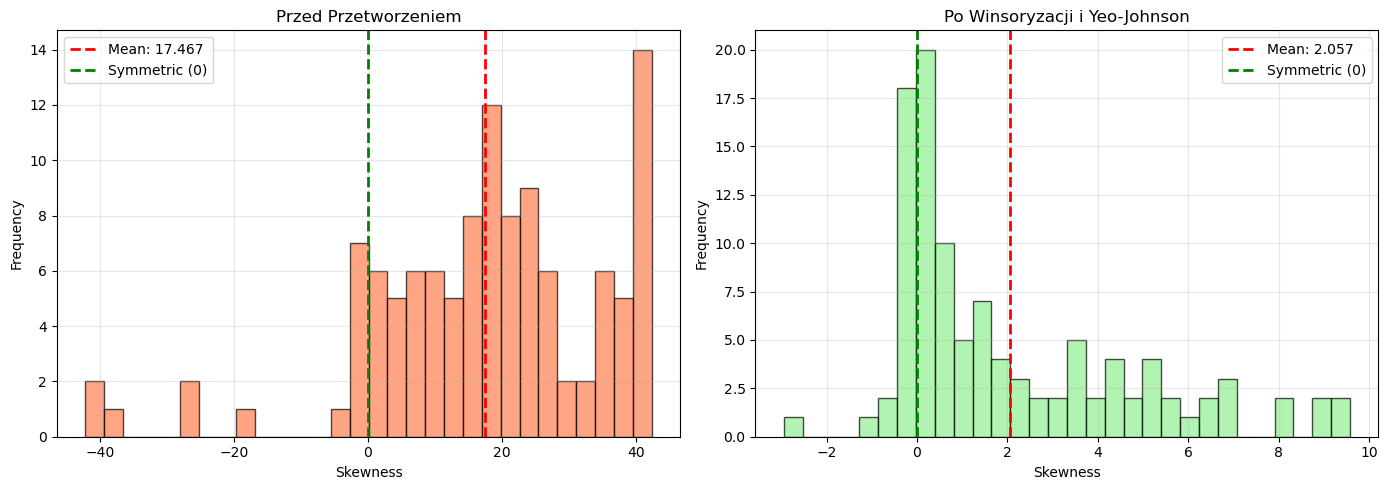

In [9]:
numeric_cols = X_train_vin.select_dtypes(include=[np.number]).columns.tolist()
skewness_after = X_train_vin[numeric_cols].apply(lambda x: stats.skew(x.dropna()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(skewness_before, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(skewness_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {skewness_before.mean():.3f}')
axes[0].axvline(0, color='green', linestyle='--', linewidth=2, label='Symmetric (0)')
axes[0].set_xlabel('Skewness')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Przed Przetworzeniem')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(skewness_after, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].axvline(skewness_after.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {skewness_after.mean():.3f}')
axes[1].axvline(0, color='green', linestyle='--', linewidth=2, label='Symmetric (0)')
axes[1].set_xlabel('Skewness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Po Winsoryzacji i Yeo-Johnson')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
def add_anomaly_feature(X_train, X_test, X_val):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    X_val_out = X_val.copy()
    
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    
    X_train_imputed = imputer.fit_transform(X_train[num_cols])
    X_test_imputed = imputer.transform(X_test[num_cols])
    X_val_imputed = imputer.transform(X_val[num_cols])
    
    iso = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1)
    iso.fit(X_train_imputed)
    
    X_train_out['Anomaly_Score'] = iso.decision_function(X_train_imputed)
    X_test_out['Anomaly_Score'] = iso.decision_function(X_test_imputed)
    X_val_out['Anomaly_Score'] = iso.decision_function(X_val_imputed)
    
    return X_train_out, X_test_out, X_val_out

X_train_final, X_test_final, X_val_final = add_anomaly_feature(X_train_vin, X_test_vin, X_val_vin)


KOLUMNY O KORELACJI > 0.95 (12 par)
                               Kolumna 1                  Kolumna 2  Korelacja
                   New_Receivables_Cycle          Cycle_Receivables   1.000000
                                  Aktywa                 Log_Aktywa   0.998187
                             zysk_brutto                 zysk_netto   0.996470
Naleznosci_dostaw_uslug_pozostale_sadowe    Ratio_Legal_Proceedings   0.992786
                              Zysk_netto                 zysk_netto   0.991517
                              Zysk_netto                zysk_brutto   0.988459
                 koszty_ogolnego_zarzadu      Ratio_Overhead_Burden   0.981830
                               przychody              Log_przychody   0.979185
                     przychody_sprzedazy                  przychody   0.974934
               Naleznosci_dlugoterminowe Structure_Receivables_Long   0.960856
                  Rzeczowe_aktywa_trwale              Srodki_trwale   0.958539
             Zob

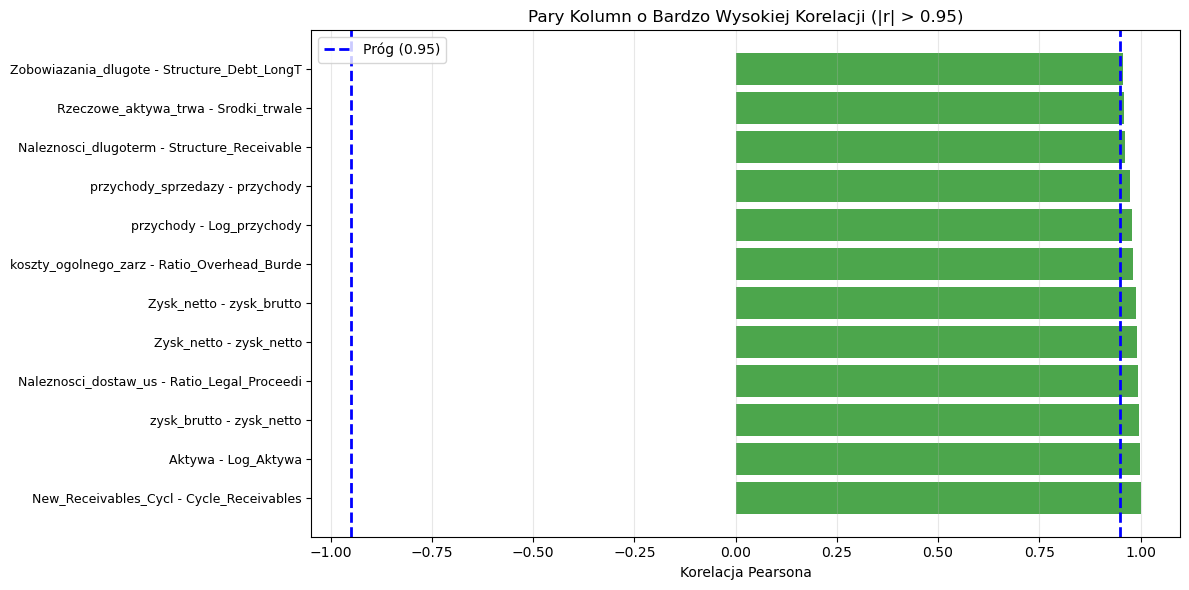


Liczba par kolumn: 5671
Średnia |korelacja|: 0.1791
Mediana |korelacja|: 0.1225
Max |korelacja|: 1.0000
Pary z |korelacją| > 0.8: 46
Pary z |korelacją| > 0.9: 21
Pary z |korelacją| > 0.95: 12


In [11]:

numeric_cols = X_train_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = X_train_final[numeric_cols].corr()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append({
                'Kolumna 1': corr_matrix.columns[i],
                'Kolumna 2': corr_matrix.columns[j],
                'Korelacja': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Korelacja', ascending=False, key=abs)
    
    print("=" * 80)
    print(f"KOLUMNY O KORELACJI > 0.95 ({len(high_corr_df)} par)")
    print("=" * 80)
    print(high_corr_df.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(high_corr_df) * 0.4)))
    pairs_labels = [f"{row['Kolumna 1'][:20]} - {row['Kolumna 2'][:20]}" 
                    for _, row in high_corr_df.iterrows()]
    colors = ['green' if x > 0 else 'red' for x in high_corr_df['Korelacja'].values]
    
    ax.barh(range(len(high_corr_df)), high_corr_df['Korelacja'].values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(high_corr_df)))
    ax.set_yticklabels(pairs_labels, fontsize=9)
    ax.axvline(x=0.95, color='blue', linestyle='--', linewidth=2, label='Próg (0.95)')
    ax.axvline(x=-0.95, color='blue', linestyle='--', linewidth=2)
    ax.set_xlabel('Korelacja Pearsona')
    ax.set_title('Pary Kolumn o Bardzo Wysokiej Korelacji (|r| > 0.95)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("  BRAK kolumn o korelacji wyższej niż 0.95")
    print(f"  Liczba kolumn: {len(numeric_cols)}")
    print(f"  Max korelacja między kolumnami: {corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().abs().max():.4f}")

print("\n" + "=" * 80)
print("=" * 80)
corr_values = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
print(f"Liczba par kolumn: {len(corr_values)}")
print(f"Średnia |korelacja|: {abs(corr_values).mean():.4f}")
print(f"Mediana |korelacja|: {abs(corr_values).median():.4f}")
print(f"Max |korelacja|: {abs(corr_values).max():.4f}")
print(f"Pary z |korelacją| > 0.8: {len(corr_values[abs(corr_values) > 0.8])}")
print(f"Pary z |korelacją| > 0.9: {len(corr_values[abs(corr_values) > 0.9])}")
print(f"Pary z |korelacją| > 0.95: {len(corr_values[abs(corr_values) > 0.95])}")


In [12]:
cols_to_drop = ['New_Receivables_Cycle'] 
if 'zysk_netto' in X_train_final.columns and 'Zysk_netto' in X_train_final.columns:
    cols_to_drop.append('zysk_netto')
if 'Zobowiazania_dostaw_uslug_pow12m' in X_train_final.columns:
    cols_to_drop.append('Zobowiazania_dostaw_uslug_pow12m')

X_train_final = X_train_final.drop(columns=cols_to_drop, errors='ignore')
X_test_final = X_test_final.drop(columns=cols_to_drop, errors='ignore')
X_val_final = X_val_final.drop(columns=cols_to_drop, errors='ignore')


print(f"  X_train_final: {X_train_final.shape}")
print(f"  X_test_final: {X_test_final.shape}")
print(f"  X_val_final: {X_val_final.shape}")


  X_train_final: (1800, 114)
  X_test_final: (600, 114)
  X_val_final: (600, 114)


##### dodatkowy kod na potem - żeby nie trzeba było szukać funkcji do ładowania i metryk

In [13]:
import json
def save_best_params(params_dict, model_name, filepath=None):
    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    params_serializable = {}
    for key, value in params_dict.items():
        if isinstance(value, (np.integer, np.int64, np.int32)):
            params_serializable[key] = int(value)
        elif isinstance(value, (np.floating, np.float64, np.float32)):
            params_serializable[key] = float(value)
        else:
            params_serializable[key] = value
    
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(params_serializable, f, indent=4, ensure_ascii=False)
    
    print(f"✓ Zapisano parametry {model_name} do: {filepath}")
    return filepath

def load_best_params(model_name, filepath=None):

    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            params = json.load(f)
        print(f"✓ Wczytano parametry {model_name} z: {filepath}")
        return params
    except FileNotFoundError:
        print(f"✗ Nie znaleziono pliku: {filepath}")
        return None
    except json.JSONDecodeError as e:
        print(f"✗ Błąd w parsowaniu JSON: {e}")
        return None

print("Funkcje save_best_params() i load_best_params() zostały zdefiniowane.")

Funkcje save_best_params() i load_best_params() zostały zdefiniowane.


In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, log_loss, brier_score_loss

def evaluate_model(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    ks_statistic = max(tpr - fpr)
    
    logloss = log_loss(y_true, y_pred_proba)
    
    brier = brier_score_loss(y_true, y_pred_proba)
    
    results = {
        'Model': model_name,
        'AUC-ROC': roc_auc,
        'PR-AUC': pr_auc,
        'KS Statistic': ks_statistic,
        'Log Loss': logloss,
        'Brier Score': brier
    }
    
    return results

def print_evaluation(results):
    print("=" * 70)
    print(f"WYNIKI EWALUACJI: {results['Model']}")
    print("=" * 70)
    print(f"AUC-ROC:       {results['AUC-ROC']:.4f}")
    print(f"PR-AUC:        {results['PR-AUC']:.4f}")
    print(f"KS Statistic:  {results['KS Statistic']:.4f}")
    print(f"Log Loss:      {results['Log Loss']:.4f}")
    print(f"Brier Score:   {results['Brier Score']:.4f}")
    print("=" * 70)


# Część 2
Trenowanie modeli Black Box

### Trenowanie

#### LightGMB

In [ ]:
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Trenowanie LightGBM...")
lgbm_model.fit(X_train_final, y_train)

# Predykcje na wszystkich zbiorach
y_pred_proba_lgbm_train = lgbm_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_lgbm_val = lgbm_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_lgbm_test = lgbm_model.predict_proba(X_test_final)[:, 1]

# Ewaluacja na wszystkich zbiorach

results_lgbm_train = evaluate_model(y_train, y_pred_proba_lgbm_train, model_name="LightGBM (Train)")
print_evaluation(results_lgbm_train)

results_lgbm_val = evaluate_model(y_val, y_pred_proba_lgbm_val, model_name="LightGBM (Val)")
print_evaluation(results_lgbm_val)

results_lgbm_test = evaluate_model(y_test, y_pred_proba_lgbm_test, model_name="LightGBM (Test)")
print_evaluation(results_lgbm_test)


Trenowanie LightGBM...
WYNIKI EWALUACJI: LightGBM (Train)
AUC-ROC:       0.9984
PR-AUC:        0.9818
KS Statistic:  0.9556
Log Loss:      0.0662
Brier Score:   0.0154
WYNIKI EWALUACJI: LightGBM (Val)
AUC-ROC:       0.7374
PR-AUC:        0.1433
KS Statistic:  0.4164
Log Loss:      0.2252
Brier Score:   0.0575
WYNIKI EWALUACJI: LightGBM (Test)
AUC-ROC:       0.7394
PR-AUC:        0.1570
KS Statistic:  0.3540
Log Loss:      0.2187
Brier Score:   0.0554
WYNIKI EWALUACJI: LightGBM (Train)
AUC-ROC:       0.9984
PR-AUC:        0.9818
KS Statistic:  0.9556
Log Loss:      0.0662
Brier Score:   0.0154
WYNIKI EWALUACJI: LightGBM (Val)
AUC-ROC:       0.7374
PR-AUC:        0.1433
KS Statistic:  0.4164
Log Loss:      0.2252
Brier Score:   0.0575
WYNIKI EWALUACJI: LightGBM (Test)
AUC-ROC:       0.7394
PR-AUC:        0.1570
KS Statistic:  0.3540
Log Loss:      0.2187
Brier Score:   0.0554


#### XGBoost

In [15]:
# Trenowanie XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    enable_categorical=True
)

print("Trenowanie XGBoost...")
xgb_model.fit(X_train_final, y_train)

# Predykcje na wszystkich zbiorach
y_pred_proba_xgb_train = xgb_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_xgb_val = xgb_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test_final)[:, 1]

# Ewaluacja na wszystkich zbiorach

results_xgb_train = evaluate_model(y_train, y_pred_proba_xgb_train, model_name="XGBoost (Train)")
print_evaluation(results_xgb_train)

results_xgb_val = evaluate_model(y_val, y_pred_proba_xgb_val, model_name="XGBoost (Val)")
print_evaluation(results_xgb_val)

results_xgb_test = evaluate_model(y_test, y_pred_proba_xgb_test, model_name="XGBoost (Test)")
print_evaluation(results_xgb_test)

Trenowanie XGBoost...


WYNIKI EWALUACJI: XGBoost (Train)
AUC-ROC:       0.9961
PR-AUC:        0.9662
KS Statistic:  0.9382
Log Loss:      0.0785
Brier Score:   0.0194
WYNIKI EWALUACJI: XGBoost (Val)
AUC-ROC:       0.7204
PR-AUC:        0.1267
KS Statistic:  0.3735
Log Loss:      0.2272
Brier Score:   0.0582
WYNIKI EWALUACJI: XGBoost (Test)
AUC-ROC:       0.7409
PR-AUC:        0.1641
KS Statistic:  0.3883
Log Loss:      0.2130
Brier Score:   0.0539


#### Random Forest

In [16]:
# Trenowanie Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Trenowanie Random Forest...")
rf_model.fit(X_train_final, y_train)

# Predykcje na wszystkich zbiorach
y_pred_proba_rf_train = rf_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_rf_val = rf_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_rf_test = rf_model.predict_proba(X_test_final)[:, 1]

# Ewaluacja na wszystkich zbiorach

results_rf_train = evaluate_model(y_train, y_pred_proba_rf_train, model_name="Random Forest (Train)")
print_evaluation(results_rf_train)

results_rf_val = evaluate_model(y_val, y_pred_proba_rf_val, model_name="Random Forest (Val)")
print_evaluation(results_rf_val)

results_rf_test = evaluate_model(y_test, y_pred_proba_rf_test, model_name="Random Forest (Test)")
print_evaluation(results_rf_test)

Trenowanie Random Forest...
WYNIKI EWALUACJI: Random Forest (Train)
AUC-ROC:       0.9968
PR-AUC:        0.9695
KS Statistic:  0.9441
Log Loss:      0.0894
Brier Score:   0.0221
WYNIKI EWALUACJI: Random Forest (Val)
AUC-ROC:       0.7369
PR-AUC:        0.2197
KS Statistic:  0.4307
Log Loss:      0.2133
Brier Score:   0.0540
WYNIKI EWALUACJI: Random Forest (Test)
AUC-ROC:       0.7394
PR-AUC:        0.1446
KS Statistic:  0.3954
Log Loss:      0.2111
Brier Score:   0.0546
WYNIKI EWALUACJI: Random Forest (Train)
AUC-ROC:       0.9968
PR-AUC:        0.9695
KS Statistic:  0.9441
Log Loss:      0.0894
Brier Score:   0.0221
WYNIKI EWALUACJI: Random Forest (Val)
AUC-ROC:       0.7369
PR-AUC:        0.2197
KS Statistic:  0.4307
Log Loss:      0.2133
Brier Score:   0.0540
WYNIKI EWALUACJI: Random Forest (Test)
AUC-ROC:       0.7394
PR-AUC:        0.1446
KS Statistic:  0.3954
Log Loss:      0.2111
Brier Score:   0.0546


#### SVM

In [17]:
# Trenowanie SVM
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

print("Trenowanie SVM...")
svm_model.fit(X_train_final, y_train)

# Predykcje na wszystkich zbiorach
y_pred_proba_svm_train = svm_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_svm_val = svm_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_svm_test = svm_model.predict_proba(X_test_final)[:, 1]

# Ewaluacja na wszystkich zbiorach
results_svm_train = evaluate_model(y_train, y_pred_proba_svm_train, model_name="SVM (Train)")
print_evaluation(results_svm_train)

results_svm_val = evaluate_model(y_val, y_pred_proba_svm_val, model_name="SVM (Val)")
print_evaluation(results_svm_val)

results_svm_test = evaluate_model(y_test, y_pred_proba_svm_test, model_name="SVM (Test)")
print_evaluation(results_svm_test)

Trenowanie SVM...
WYNIKI EWALUACJI: SVM (Train)
AUC-ROC:       0.9299
PR-AUC:        0.7335
KS Statistic:  0.6784
Log Loss:      0.2064
Brier Score:   0.0536
WYNIKI EWALUACJI: SVM (Val)
AUC-ROC:       0.6943
PR-AUC:        0.1752
KS Statistic:  0.3193
Log Loss:      0.2212
Brier Score:   0.0562
WYNIKI EWALUACJI: SVM (Test)
AUC-ROC:       0.6373
PR-AUC:        0.1578
KS Statistic:  0.2317
Log Loss:      0.2207
Brier Score:   0.0556
WYNIKI EWALUACJI: SVM (Train)
AUC-ROC:       0.9299
PR-AUC:        0.7335
KS Statistic:  0.6784
Log Loss:      0.2064
Brier Score:   0.0536
WYNIKI EWALUACJI: SVM (Val)
AUC-ROC:       0.6943
PR-AUC:        0.1752
KS Statistic:  0.3193
Log Loss:      0.2212
Brier Score:   0.0562
WYNIKI EWALUACJI: SVM (Test)
AUC-ROC:       0.6373
PR-AUC:        0.1578
KS Statistic:  0.2317
Log Loss:      0.2207
Brier Score:   0.0556


### Porównanie wszystkich modeli


PORÓWNANIE WSZYSTKICH MODELI (TRAIN, VAL, TEST)
                Model  AUC-ROC   PR-AUC  KS Statistic  Log Loss  Brier Score
     LightGBM (Train) 0.998375 0.981816      0.955621  0.066168     0.015351
       LightGBM (Val) 0.737363 0.143302      0.416351  0.225171     0.057548
      LightGBM (Test) 0.739411 0.156981      0.354019  0.218717     0.055376
      XGBoost (Train) 0.996140 0.966189      0.938193  0.078516     0.019417
        XGBoost (Val) 0.720369 0.126732      0.373482  0.227225     0.058219
       XGBoost (Test) 0.740888 0.164135      0.388298  0.212966     0.053917
Random Forest (Train) 0.996789 0.969530      0.944110  0.089368     0.022134
  Random Forest (Val) 0.736859 0.219715      0.430704  0.213311     0.053965
 Random Forest (Test) 0.739411 0.144602      0.395390  0.211111     0.054571
          SVM (Train) 0.929944 0.733494      0.678375  0.206359     0.053643
            SVM (Val) 0.694302 0.175245      0.319284  0.221185     0.056227
           SVM (Test) 0.637

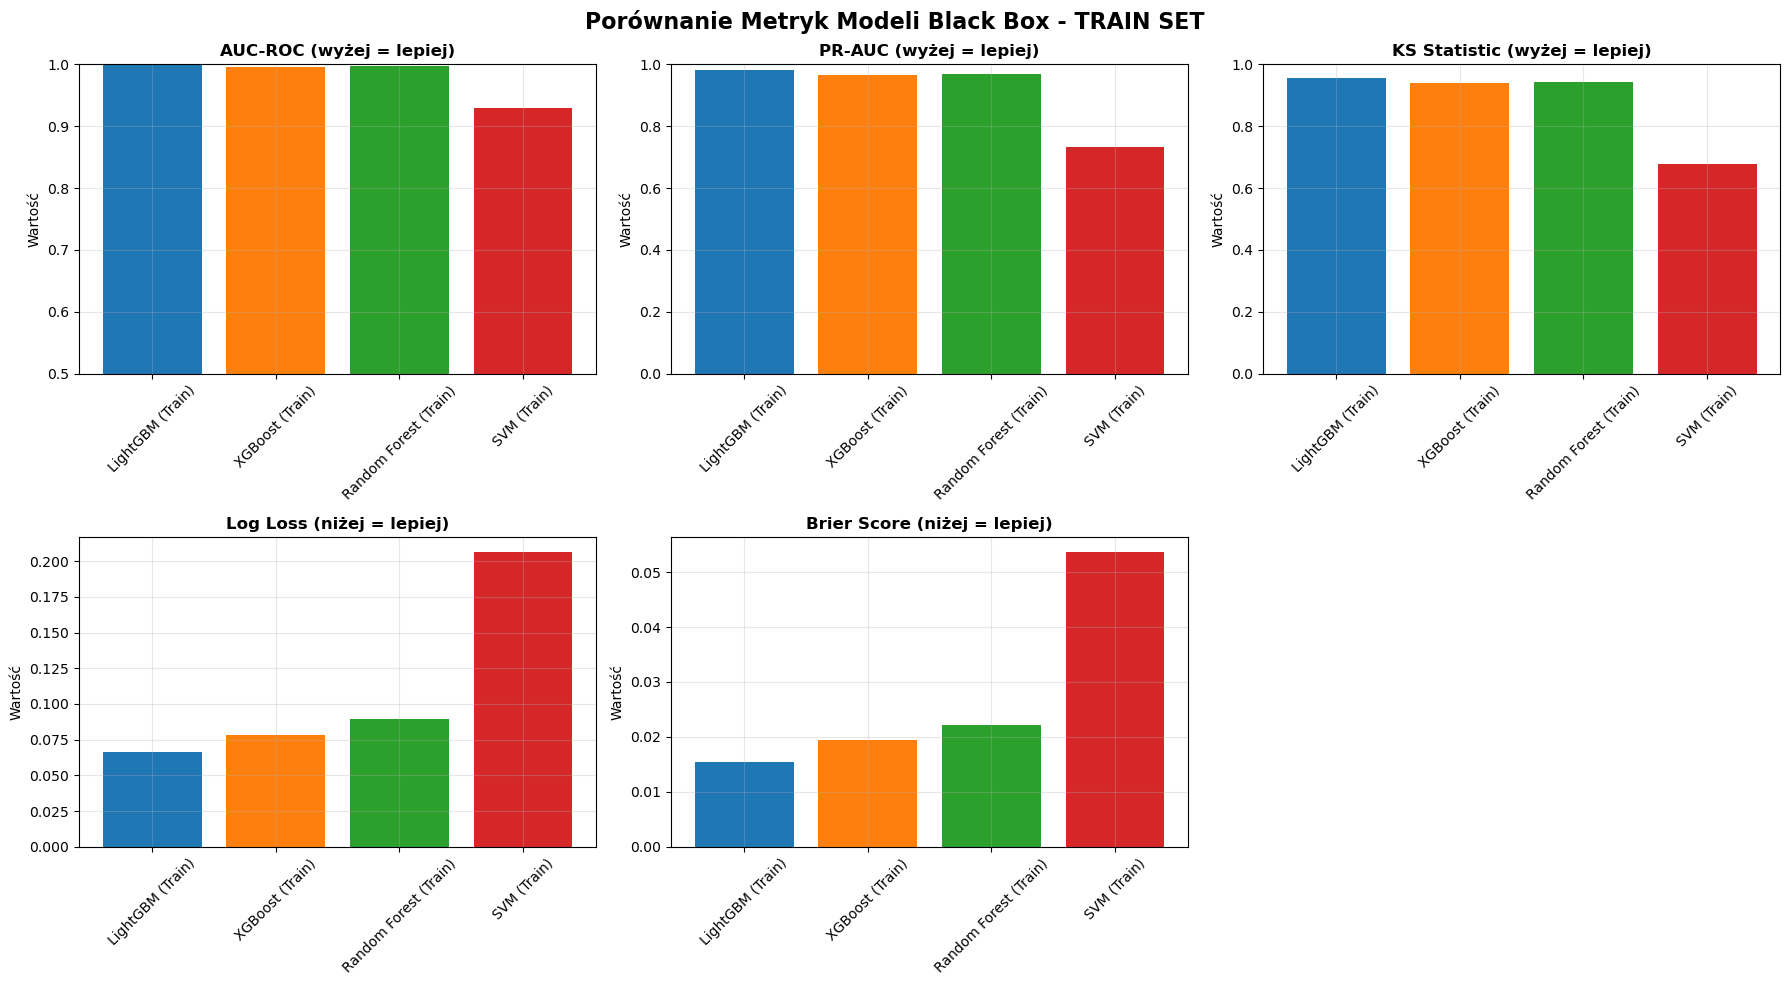

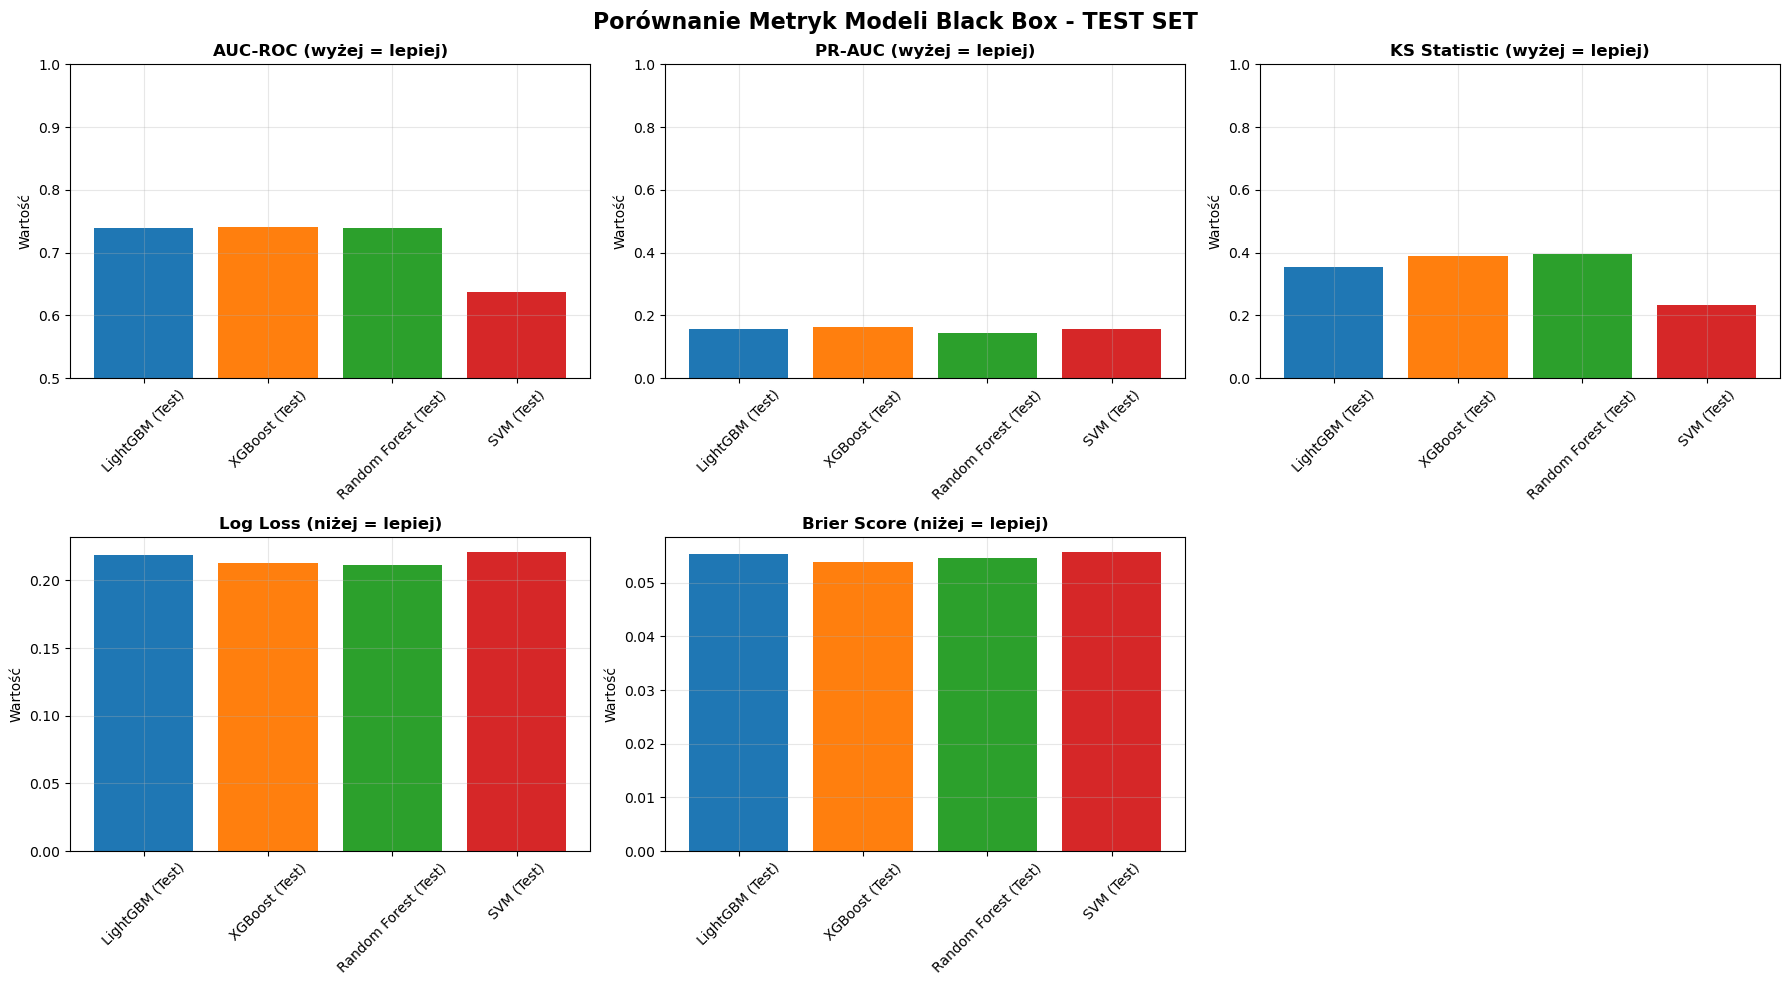

In [18]:
# Zebranie wszystkich wyników
all_results_train = [results_lgbm_train, results_xgb_train, results_rf_train, results_svm_train]
all_results_test = [results_lgbm_test, results_xgb_test, results_rf_test, results_svm_test]
comparison_df_train = pd.DataFrame(all_results_train)
comparison_df_test = pd.DataFrame(all_results_test)

# Zebranie wszystkich wyników (train, val, test) dla pełnego porównania
all_results_detailed = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_rf_train, results_rf_val, results_rf_test,
    results_svm_train, results_svm_val, results_svm_test
]
comparison_df_detailed = pd.DataFrame(all_results_detailed)

print("\n" + "=" * 100)
print("PORÓWNANIE WSZYSTKICH MODELI (TRAIN, VAL, TEST)")
print("=" * 100)
print(comparison_df_detailed.to_string(index=False))
print("=" * 100)

# Wizualizacja porównania - TRAIN SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TRAIN SET', fontsize=16, fontweight='bold')

metrics = ['AUC-ROC', 'PR-AUC', 'KS Statistic', 'Log Loss', 'Brier Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# AUC-ROC
axes[0, 0].bar(comparison_df_train['Model'], comparison_df_train['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_train['Model'], comparison_df_train['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_train['Model'], comparison_df_train['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_train['Model'], comparison_df_train['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_train['Model'], comparison_df_train['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Wizualizacja porównania - TEST SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TEST SET', fontsize=16, fontweight='bold')

# AUC-ROC
axes[0, 0].bar(comparison_df_test['Model'], comparison_df_test['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_test['Model'], comparison_df_test['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_test['Model'], comparison_df_test['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_test['Model'], comparison_df_test['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_test['Model'], comparison_df_test['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

### Wnioski
Poza SVM, wszystkie modele zostały przetrenowane, w kolejnej sekcji to naprawimy

## Hipetruning parametryczny z kontrolą overfittingu

## Wczytywanie danych po feature selection

In [16]:
# Wczytywanie danych po feature selection
print("="*80)
print("WCZYTYWANIE DANYCH PO FEATURE SELECTION")
print("="*80)

# Wczytaj dane z plików CSV
train_df = pd.read_csv('train_selected.csv')
test_df = pd.read_csv('test_selected.csv')
val_df = pd.read_csv('val_selected.csv')

# Rozdziel cechy i target
X_train_selected = train_df.drop(columns=['default'])
y_train = train_df['default']

X_test_selected = test_df.drop(columns=['default'])
y_test = test_df['default']

X_val_selected = val_df.drop(columns=['default'])
y_val = val_df['default']

print(f"\n✓ Wczytano dane treningowe: {X_train_selected.shape} + target")
print(f"✓ Wczytano dane testowe: {X_test_selected.shape} + target")
print(f"✓ Wczytano dane walidacyjne: {X_val_selected.shape} + target")

print(f"\nLiczba cech: {len(X_train_selected.columns)}")
print(f"Liczba próbek - TRAIN: {len(X_train_selected)}, TEST: {len(X_test_selected)}, VAL: {len(X_val_selected)}")

# Sprawdzenie rozkładu klasy target
print(f"\nRozkład klasy target:")
print(f"  TRAIN: {y_train.value_counts().to_dict()}")
print(f"  TEST: {y_test.value_counts().to_dict()}")
print(f"  VAL: {y_val.value_counts().to_dict()}")

print("="*80)

WCZYTYWANIE DANYCH PO FEATURE SELECTION

✓ Wczytano dane treningowe: (1800, 105) + target
✓ Wczytano dane testowe: (600, 105) + target
✓ Wczytano dane walidacyjne: (600, 105) + target

Liczba cech: 105
Liczba próbek - TRAIN: 1800, TEST: 600, VAL: 600

Rozkład klasy target:
  TRAIN: {0: 1690, 1: 110}
  TEST: {0: 564, 1: 36}
  VAL: {0: 563, 1: 37}

✓ Wczytano dane treningowe: (1800, 105) + target
✓ Wczytano dane testowe: (600, 105) + target
✓ Wczytano dane walidacyjne: (600, 105) + target

Liczba cech: 105
Liczba próbek - TRAIN: 1800, TEST: 600, VAL: 600

Rozkład klasy target:
  TRAIN: {0: 1690, 1: 110}
  TEST: {0: 564, 1: 36}
  VAL: {0: 563, 1: 37}


In [17]:
import optuna
from optuna.pruners import MedianPruner

print("\n" + "="*100)
print("TUNING OPTUNA Z KONTROLĄ OVERFITTINGU")
print("="*100)


TUNING OPTUNA Z KONTROLĄ OVERFITTINGU


#### LightGBM - Optuna Tuning

In [ ]:
def objective_lgbm(trial):
    """Optuna objective function for LightGBM tuning"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Zmniejszone
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.02, log=True),  # Wolniejsze uczenie
        
        'max_depth': trial.suggest_int('max_depth', 2, 4),  # Płytsze drzewa
        'num_leaves': trial.suggest_int('num_leaves', 3, 10),  # Mniej liści
        
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),  # Więcej próbek w liściu

        'min_split_gain': trial.suggest_float('min_split_gain', 0.5, 10.0),  # Wyższa bariera podziału
        
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),  # Mniej danych
        'bagging_freq': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # Mniej cech
        
        # Silniejsza regularyzacja
        'reg_alpha': trial.suggest_float('reg_alpha', 5.0, 100.0, log=True),  # Zwiększone
        'reg_lambda': trial.suggest_float('reg_lambda', 5.0, 100.0, log=True),  # Zwiększone
        
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    try:
        model = LGBMClassifier(**params)
        model.fit(X_train_final, y_train)
        
        # Predykcje na train i test
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        # Metryki
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        # Score z większą karą za overfitting
        penalty_weight = 0.5  # Zwiększone z 0.3
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

print("Rozpoczęto tuning LightGBM z Optuna (100 trials z silną kontrolą overfittingu)...")
sampler_lgbm = optuna.samplers.TPESampler(seed=42)
pruner_lgbm = MedianPruner()
study_lgbm = optuna.create_study(sampler=sampler_lgbm, pruner=pruner_lgbm, direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik LightGBM: {study_lgbm.best_value:.6f}")
print("Najlepsze parametry LightGBM:")
lgbm_best_params = study_lgbm.best_params
for param, value in lgbm_best_params.items():
    print(f"  {param}: {value}")

# Trenowanie finalnego modelu LightGBM z najlepszymi parametrami
lgbm_tuned = LGBMClassifier(
    n_estimators=int(lgbm_best_params['n_estimators']),
    learning_rate=lgbm_best_params['learning_rate'],
    max_depth=int(lgbm_best_params['max_depth']),
    num_leaves=int(lgbm_best_params['num_leaves']),
    min_child_samples=int(lgbm_best_params['min_child_samples']),
    min_split_gain=lgbm_best_params['min_split_gain'],
    subsample=lgbm_best_params['subsample'],
    bagging_freq=1,
    colsample_bytree=lgbm_best_params['colsample_bytree'],
    reg_lambda=lgbm_best_params['reg_lambda'],
    reg_alpha=lgbm_best_params['reg_alpha'],
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_tuned.fit(X_train_final, y_train)

# Ewaluacja
y_pred_lgbm_train_tuned = lgbm_tuned.predict_proba(X_train_final)[:, 1]
y_pred_lgbm_val_tuned = lgbm_tuned.predict_proba(X_val_final)[:, 1]
y_pred_lgbm_test_tuned = lgbm_tuned.predict_proba(X_test_final)[:, 1]

results_lgbm_train_tuned = evaluate_model(y_train, y_pred_lgbm_train_tuned, "LightGBM Tuned (Train)")
results_lgbm_val_tuned = evaluate_model(y_val, y_pred_lgbm_val_tuned, "LightGBM Tuned (Val)")
results_lgbm_test_tuned = evaluate_model(y_test, y_pred_lgbm_test_tuned, "LightGBM Tuned (Test)")


print("\nWyniki LightGBM Tuned:")
print_evaluation(results_lgbm_test_tuned)

print_evaluation(results_lgbm_train_tuned)
print_evaluation(results_lgbm_val_tuned)

Rozpoczęto tuning LightGBM z Optuna (100 trials z silną kontrolą overfittingu)...


[I 2025-12-08 20:45:51,681] A new study created in memory with name: no-name-cdeb22bf-476b-4ddd-b998-fcd827862987


[I 2025-12-08 20:45:51,856] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.017254716573280357, 'max_depth': 4, 'num_leaves': 7, 'min_child_samples': 162, 'min_split_gain': 1.981947943193925, 'subsample': 0.4174250836504598, 'colsample_bytree': 0.6598528437324805, 'reg_alpha': 30.271829277346235, 'reg_lambda': 41.705532161810446}. Best is trial 0 with value: 0.5.
[I 2025-12-08 20:45:51,990] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 55, 'learning_rate': 0.018276027831785738, 'max_depth': 4, 'num_leaves': 4, 'min_child_samples': 172, 'min_split_gain': 2.2423428436076214, 'subsample': 0.4912726728878613, 'colsample_bytree': 0.5574269294896713, 'reg_alpha': 18.23658142455605, 'reg_lambda': 11.963764382790318}. Best is trial 0 with value: 0.5.
[I 2025-12-08 20:45:51,990] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 55, 'learning_rate': 0.018276027831785738, 'max_depth': 4, 'num_leaves': 4, 'min_child_samp

#### XGBoost - Optuna Tuning

In [ ]:
def objective_xgb(trial):
    """Optuna objective function for XGBoost tuning"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Zmniejszone
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),  # Wolniejsze
        'max_depth': trial.suggest_int('max_depth', 2, 6),  # Płytsze drzewa
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),  # Większa waga
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),  # Mniej danych
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),  # Mniej cech
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),  # Silniejsza regularyzacja L2
        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0, log=True),  # Silniejsza regularyzacja L1
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),  # Minimalna redukcja straty dla podziału
        'enable_categorical': True,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    try:
        model = XGBClassifier(**params)
        model.fit(X_train_final, y_train)
        
        # Predykcje na train i test
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        # Metryki
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        # Score z większą karą za overfitting
        penalty_weight = 0.5  # Zwiększone z 0.3
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

print("Rozpoczęto tuning XGBoost z Optuna (100 trials z silną kontrolą overfittingu)...")
sampler_xgb = optuna.samplers.TPESampler(seed=42)
pruner_xgb = MedianPruner()
study_xgb = optuna.create_study(sampler=sampler_xgb, pruner=pruner_xgb, direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik XGBoost: {study_xgb.best_value:.6f}")
print("Najlepsze parametry XGBoost:")
xgb_best_params = study_xgb.best_params
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

# Trenowanie finalnego modelu XGBoost z najlepszymi parametrami
xgb_tuned = XGBClassifier(
    n_estimators=int(xgb_best_params['n_estimators']),
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=int(xgb_best_params['max_depth']),
    min_child_weight=int(xgb_best_params['min_child_weight']),
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    enable_categorical=True,
    eval_metric='logloss',
    random_state=42
)
xgb_tuned.fit(X_train_final, y_train)

# Ewaluacja
y_pred_xgb_train_tuned = xgb_tuned.predict_proba(X_train_final)[:, 1]
y_pred_xgb_val_tuned = xgb_tuned.predict_proba(X_val_final)[:, 1]
y_pred_xgb_test_tuned = xgb_tuned.predict_proba(X_test_final)[:, 1]

results_xgb_train_tuned = evaluate_model(y_train, y_pred_xgb_train_tuned, "XGBoost Tuned (Train)")
results_xgb_val_tuned = evaluate_model(y_val, y_pred_xgb_val_tuned, "XGBoost Tuned (Val)")
results_xgb_test_tuned = evaluate_model(y_test, y_pred_xgb_test_tuned, "XGBoost Tuned (Test)")

print("\nWyniki XGBoost Tuned:")
print_evaluation(results_xgb_train_tuned)
print_evaluation(results_xgb_val_tuned)
print_evaluation(results_xgb_test_tuned)

[I 2025-12-06 20:39:37,091] A new study created in memory with name: no-name-ab9f77f0-ee16-47c1-bf17-6aa751b40371


Rozpoczęto tuning XGBoost z Optuna (100 trials z silną kontrolą overfittingu)...


[I 2025-12-06 20:39:37,748] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.04123206532618727, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.46240745617697465, 'colsample_bytree': 0.46239780813448106, 'reg_lambda': 1.2551115172973832, 'reg_alpha': 29.621516588303486, 'gamma': 3.0454635575417233}. Best is trial 0 with value: 0.5.
[I 2025-12-06 20:39:39,040] Trial 1 finished with value: 0.7270644106302864 and parameters: {'n_estimators': 227, 'learning_rate': 0.0010838581269344747, 'max_depth': 6, 'min_child_weight': 18, 'subsample': 0.4849356442713105, 'colsample_bytree': 0.4727299868828403, 'reg_lambda': 2.0492680115417348, 'reg_alpha': 3.2877474139911183, 'gamma': 2.6713065149979656}. Best is trial 1 with value: 0.7270644106302864.
[I 2025-12-06 20:39:39,040] Trial 1 finished with value: 0.7270644106302864 and parameters: {'n_estimators': 227, 'learning_rate': 0.0010838581269344747, 'max_depth': 6, 'min_child_weight': 18, 'subsample':


Najlepszy wynik XGBoost: 0.790697
Najlepsze parametry XGBoost:
  n_estimators: 147
  learning_rate: 0.021294330360498877
  max_depth: 2
  min_child_weight: 15
  subsample: 0.6621713555824025
  colsample_bytree: 0.6554745488630886
  reg_lambda: 3.327994179569198
  reg_alpha: 2.5953243304233338
  gamma: 2.1171575715024202

Wyniki XGBoost Tuned:
WYNIKI EWALUACJI: XGBoost Tuned (Train)
AUC-ROC:       0.8039
PR-AUC:        0.2275
KS Statistic:  0.4802
Log Loss:      0.2004
Brier Score:   0.0535
WYNIKI EWALUACJI: XGBoost Tuned (Val)
AUC-ROC:       0.7349
PR-AUC:        0.1502
KS Statistic:  0.4428
Log Loss:      0.2120
Brier Score:   0.0553
WYNIKI EWALUACJI: XGBoost Tuned (Test)
AUC-ROC:       0.7951
PR-AUC:        0.1584
KS Statistic:  0.5041
Log Loss:      0.1999
Brier Score:   0.0532

Wyniki XGBoost Tuned:
WYNIKI EWALUACJI: XGBoost Tuned (Train)
AUC-ROC:       0.8039
PR-AUC:        0.2275
KS Statistic:  0.4802
Log Loss:      0.2004
Brier Score:   0.0535
WYNIKI EWALUACJI: XGBoost Tuned (V

#### Random Forest - Optuna Tuning

In [ ]:
def objective_rf(trial):
    """Optuna objective function for Random Forest tuning"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    
    try:
        model = RandomForestClassifier(**params)
        model.fit(X_train_final, y_train)
        
        # Predykcje na train i test
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        # Metryki
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        # Score z karą za overfitting
        penalty_weight = 0.3
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

print("Rozpoczęto tuning Random Forest z Optuna (50 trials)...")
# sampler_rf = optuna.samplers.TPESampler(seed=42)
# pruner_rf = MedianPruner()
# study_rf = optuna.create_study(sampler=sampler_rf, pruner=pruner_rf, direction='maximize')
# study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=False)
print("należy odkomentować kod aby uruchomić tuning Random Forest - kod może uruchamiać się godzinę")
print(f"\nNajlepszy wynik Random Forest: {study_rf.best_value:.6f}")
print("Najlepsze parametry Random Forest:")
rf_best_params = study_rf.best_params
for param, value in rf_best_params.items():
    print(f"  {param}: {value}")

# Trenowanie finalnego modelu Random Forest z najlepszymi parametrami
rf_tuned = RandomForestClassifier(
    n_estimators=int(rf_best_params['n_estimators']),
    max_depth=int(rf_best_params['max_depth']),
    min_samples_split=int(rf_best_params['min_samples_split']),
    min_samples_leaf=int(rf_best_params['min_samples_leaf']),
    max_features=rf_best_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_tuned.fit(X_train_final, y_train)

# Ewaluacja
y_pred_rf_train_tuned = rf_tuned.predict_proba(X_train_final)[:, 1]
y_pred_rf_val_tuned = rf_tuned.predict_proba(X_val_final)[:, 1]
y_pred_rf_test_tuned = rf_tuned.predict_proba(X_test_final)[:, 1]

results_rf_train_tuned = evaluate_model(y_train, y_pred_rf_train_tuned, "Random Forest Tuned (Train)")
results_rf_val_tuned = evaluate_model(y_val, y_pred_rf_val_tuned, "Random Forest Tuned (Val)")
results_rf_test_tuned = evaluate_model(y_test, y_pred_rf_test_tuned, "Random Forest Tuned (Test)")

print("\nWyniki Random Forest Tuned:")
print_evaluation(results_rf_train_tuned)
print_evaluation(results_rf_val_tuned)
print_evaluation(results_rf_test_tuned)

Rozpoczęto tuning Random Forest z Optuna (50 trials)...
należy odkomentować kod aby uruchomić tuning Random Forest - kod może uruchamiać się godzinę


NameError: name 'study_rf' is not defined

#### SVM - Optuna Tuning

In [ ]:
def objective_svm(trial):
    """Optuna objective function for SVM tuning"""
    params = {
        'C': trial.suggest_float('C', 0.001, 100),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'kernel': 'rbf',
        'probability': True,
        'random_state': 42
    }
    
    try:
        model = SVC(**params)
        model.fit(X_train_final, y_train)
        
        # Predykcje na train i test
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        # Metryki
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        # Score z karą za overfitting
        penalty_weight = 0.3
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

print("Rozpoczęto tuning SVM z Optuna (50 trials)...")
sampler_svm = optuna.samplers.TPESampler(seed=42)
pruner_svm = MedianPruner()
study_svm = optuna.create_study(sampler=sampler_svm, pruner=pruner_svm, direction='maximize')
study_svm.optimize(objective_svm, n_trials=50, show_progress_bar=False)

print(f"\nNajlepszy wynik SVM: {study_svm.best_value:.6f}")
print("Najlepsze parametry SVM:")
svm_best_params = study_svm.best_params
for param, value in svm_best_params.items():
    print(f"  {param}: {value}")

# Trenowanie finalnego modelu SVM z najlepszymi parametrami
svm_tuned = SVC(
    C=svm_best_params['C'],
    gamma=svm_best_params['gamma'],
    tol=svm_best_params['tol'],
    kernel='rbf',
    probability=True,
    random_state=42
)
svm_tuned.fit(X_train_final, y_train)

# Ewaluacja
y_pred_svm_train_tuned = svm_tuned.predict_proba(X_train_final)[:, 1]
y_pred_svm_val_tuned = svm_tuned.predict_proba(X_val_final)[:, 1]
y_pred_svm_test_tuned = svm_tuned.predict_proba(X_test_final)[:, 1]

results_svm_train_tuned = evaluate_model(y_train, y_pred_svm_train_tuned, "SVM Tuned (Train)")
results_svm_val_tuned = evaluate_model(y_val, y_pred_svm_val_tuned, "SVM Tuned (Val)")
results_svm_test_tuned = evaluate_model(y_test, y_pred_svm_test_tuned, "SVM Tuned (Test)")

print("\nWyniki SVM Tuned:")
print_evaluation(results_svm_train_tuned)
print_evaluation(results_svm_val_tuned)
print_evaluation(results_svm_test_tuned)

[I 2025-12-06 15:51:07,310] A new study created in memory with name: no-name-bc43dc9c-07dc-4335-ae51-a428140af9d6


Rozpoczęto tuning SVM z Optuna (50 trials)...


[I 2025-12-06 15:51:07,901] Trial 0 finished with value: 0.5703889599973887 and parameters: {'C': 37.454637344617396, 'gamma': 'scale', 'tol': 0.0598698618348617}. Best is trial 0 with value: 0.5703889599973887.
[I 2025-12-06 15:51:08,362] Trial 1 finished with value: 0.5652624852113395 and parameters: {'C': 15.602708025603208, 'gamma': 'scale', 'tol': 0.08661895281603578}. Best is trial 0 with value: 0.5703889599973887.
[I 2025-12-06 15:51:08,362] Trial 1 finished with value: 0.5652624852113395 and parameters: {'C': 15.602708025603208, 'gamma': 'scale', 'tol': 0.08661895281603578}. Best is trial 0 with value: 0.5703889599973887.
[I 2025-12-06 15:51:08,831] Trial 2 finished with value: 0.5575749980606771 and parameters: {'C': 60.11190005930913, 'gamma': 'scale', 'tol': 0.09699128611767782}. Best is trial 0 with value: 0.5703889599973887.
[I 2025-12-06 15:51:08,831] Trial 2 finished with value: 0.5575749980606771 and parameters: {'C': 60.11190005930913, 'gamma': 'scale', 'tol': 0.096991


Najlepszy wynik SVM: 0.671408
Najlepsze parametry SVM:
  C: 80.48781164573361
  gamma: scale
  tol: 0.001030140425971245

Wyniki SVM Tuned:
WYNIKI EWALUACJI: SVM Tuned (Train)
AUC-ROC:       0.7552
PR-AUC:        0.2799
KS Statistic:  0.3840
Log Loss:      0.2267
Brier Score:   0.0569
WYNIKI EWALUACJI: SVM Tuned (Val)
AUC-ROC:       0.7022
PR-AUC:        0.1467
KS Statistic:  0.3338
Log Loss:      0.2302
Brier Score:   0.0577
WYNIKI EWALUACJI: SVM Tuned (Test)
AUC-ROC:       0.6908
PR-AUC:        0.1254
KS Statistic:  0.3392
Log Loss:      0.2252
Brier Score:   0.0562

Wyniki SVM Tuned:
WYNIKI EWALUACJI: SVM Tuned (Train)
AUC-ROC:       0.7552
PR-AUC:        0.2799
KS Statistic:  0.3840
Log Loss:      0.2267
Brier Score:   0.0569
WYNIKI EWALUACJI: SVM Tuned (Val)
AUC-ROC:       0.7022
PR-AUC:        0.1467
KS Statistic:  0.3338
Log Loss:      0.2302
Brier Score:   0.0577
WYNIKI EWALUACJI: SVM Tuned (Test)
AUC-ROC:       0.6908
PR-AUC:        0.1254
KS Statistic:  0.3392
Log Loss:     

#### Wnioski
XGBoost poradził sobie najlepiej - najmniej przetrenowany model ze wszystkich

In [ ]:
# ==================== PORÓWNANIE MODELI PRZED I PO TUNINGU ====================
print("\n" + "="*100)
print("PORÓWNANIE MODELI PRZED I PO TUNINGU")
print("="*100)

# Zebranie wyników
comparison_tuning = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_lgbm_train_tuned, results_lgbm_val_tuned, results_lgbm_test_tuned,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_xgb_train_tuned, results_xgb_val_tuned, results_xgb_test_tuned,
    results_rf_train, results_rf_val, results_rf_test,
    results_rf_train_tuned, results_rf_val_tuned, results_rf_test_tuned,
    results_svm_train, results_svm_val, results_svm_test,
    results_svm_train_tuned, results_svm_val_tuned, results_svm_test_tuned
]

df_tuning = pd.DataFrame(comparison_tuning)
print("\n" + df_tuning.to_string(index=False))

# Obliczenie overfittingu (różnica między train a test)
print("\n" + "="*100)
print("ANALIZA OVERFITTINGU (różnica Train - Test)")
print("="*100)
print(f"{'Model':<25} {'AUC-ROC':<12} {'PR-AUC':<12} {'Log Loss':<12} {'Brier':<12}")
print("-" * 75)

for model_name in ['LightGBM', 'XGBoost', 'Random Forest', 'SVM']:
    # Wyniki przed tuningiem
    train_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                             (df_tuning['Model'].str.contains('Train')) & 
                             (~df_tuning['Model'].str.contains('Tuned'))]
    test_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Test')) & 
                            (~df_tuning['Model'].str.contains('Tuned'))]
    
    # Wyniki po tuningu
    train_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Train')) & 
                            (df_tuning['Model'].str.contains('Tuned'))]
    test_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                           (df_tuning['Model'].str.contains('Test')) & 
                           (df_tuning['Model'].str.contains('Tuned'))]
    
    if not train_before.empty and not train_after.empty:
        print(f"\n{model_name} (PRZED tuningiem):")
        if not train_before.empty and not test_before.empty:
            auc_diff = train_before['AUC-ROC'].values[0] - test_before['AUC-ROC'].values[0]
            pr_diff = train_before['PR-AUC'].values[0] - test_before['PR-AUC'].values[0]
            loss_diff = test_before['Log Loss'].values[0] - train_before['Log Loss'].values[0]
            brier_diff = test_before['Brier Score'].values[0] - train_before['Brier Score'].values[0]
            print(f"  {'(PRZED)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")
        
        print(f"{model_name} (PO tuningu):")
        if not train_after.empty and not test_after.empty:
            auc_diff = train_after['AUC-ROC'].values[0] - test_after['AUC-ROC'].values[0]
            pr_diff = train_after['PR-AUC'].values[0] - test_after['PR-AUC'].values[0]
            loss_diff = test_after['Log Loss'].values[0] - train_after['Log Loss'].values[0]
            brier_diff = test_after['Brier Score'].values[0] - train_after['Brier Score'].values[0]
            print(f"  {'(PO TUNINGU)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")

# Wizualizacja porównania
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Porównanie Modeli: Przed vs Po Tuningu - TEST SET', fontsize=16, fontweight='bold')

# Przygotowanie danych do wykresu
models_names = ['LightGBM', 'XGBoost', 'Random Forest', 'SVM']
metrics_list = ['AUC-ROC', 'PR-AUC', 'Log Loss', 'Brier Score']

test_before = []
test_after = []

for model_name in models_names:
    test_before.append(df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                                  (df_tuning['Model'].str.contains('Test')) & 
                                  (~df_tuning['Model'].str.contains('Tuned'))].iloc[0])
    test_after.append(df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                                (df_tuning['Model'].str.contains('Test')) & 
                                (df_tuning['Model'].str.contains('Tuned'))].iloc[0])

# AUC-ROC
ax = axes[0, 0]
x = np.arange(len(models_names))
width = 0.35
before_values = [d['AUC-ROC'] for d in test_before]
after_values = [d['AUC-ROC'] for d in test_after]
ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
ax.set_ylabel('Wartość')
ax.set_title('AUC-ROC (wyżej = lepiej)')
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.5, 1.0])

# PR-AUC
ax = axes[0, 1]
before_values = [d['PR-AUC'] for d in test_before]
after_values = [d['PR-AUC'] for d in test_after]
ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
ax.set_ylabel('Wartość')
ax.set_title('PR-AUC (wyżej = lepiej)')
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Log Loss
ax = axes[1, 0]
before_values = [d['Log Loss'] for d in test_before]
after_values = [d['Log Loss'] for d in test_after]
ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
ax.set_ylabel('Wartość')
ax.set_title('Log Loss (niżej = lepiej)')
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Brier Score
ax = axes[1, 1]
before_values = [d['Brier Score'] for d in test_before]
after_values = [d['Brier Score'] for d in test_after]
ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
ax.set_ylabel('Wartość')
ax.set_title('Brier Score (niżej = lepiej)')
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



PORÓWNANIE MODELI PRZED I PO TUNINGU


NameError: name 'results_lgbm_train_tuned' is not defined

## Feature Selection - Selekcja Cech  
Każda metoda będzie porównana z poprzednią, aby zobaczyć wpływ na wyniki modelu.

### 1. Baseline - Model przed selekcją cech

In [17]:
from sklearn.feature_selection import VarianceThreshold, RFE

print("=" * 100)
print("FEATURE SELECTION - BASELINE (przed selekcją)")
print("=" * 100)

# Baseline - używamy najlepszych parametrów z Optuna
print(f"\nLiczba cech przed selekcją:")
print(f"  X_train_final: {X_train_final.shape[1]} cech")
print(f"  X_test_final: {X_test_final.shape[1]} cech")
print(f"  X_val_final: {X_val_final.shape[1]} cech")

# Trenowanie modelu baseline z najlepszymi parametrami
xgb_baseline = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_baseline.fit(X_train_final, y_train)

# Predykcje
y_pred_baseline_train = xgb_baseline.predict_proba(X_train_final)[:, 1]
y_pred_baseline_test = xgb_baseline.predict_proba(X_test_final)[:, 1]
y_pred_baseline_val = xgb_baseline.predict_proba(X_val_final)[:, 1]

# Ewaluacja
results_baseline_train = evaluate_model(y_train, y_pred_baseline_train, "XGBoost Baseline (Train)")
results_baseline_test = evaluate_model(y_test, y_pred_baseline_test, "XGBoost Baseline (Test)")
results_baseline_val = evaluate_model(y_val, y_pred_baseline_val, "XGBoost Baseline (Val)")

print("\n" + "=" * 100)
print("WYNIKI BASELINE")
print("=" * 100)
print_evaluation(results_baseline_train)
print_evaluation(results_baseline_test)
print_evaluation(results_baseline_val)

# Gap Train-Test
gap_baseline = results_baseline_train['AUC-ROC'] - results_baseline_test['AUC-ROC']
print(f"\nGap Train-Test AUC: {gap_baseline:.4f}")
print("=" * 100)

FEATURE SELECTION - BASELINE (przed selekcją)

Liczba cech przed selekcją:
  X_train_final: 114 cech
  X_test_final: 114 cech
  X_val_final: 114 cech

WYNIKI BASELINE
WYNIKI EWALUACJI: XGBoost Baseline (Train)
AUC-ROC:       0.8039
PR-AUC:        0.2275
KS Statistic:  0.4802
Log Loss:      0.2004
Brier Score:   0.0535
WYNIKI EWALUACJI: XGBoost Baseline (Test)
AUC-ROC:       0.7951
PR-AUC:        0.1584
KS Statistic:  0.5041
Log Loss:      0.1999
Brier Score:   0.0532
WYNIKI EWALUACJI: XGBoost Baseline (Val)
AUC-ROC:       0.7349
PR-AUC:        0.1502
KS Statistic:  0.4428
Log Loss:      0.2120
Brier Score:   0.0553

Gap Train-Test AUC: 0.0088

WYNIKI BASELINE
WYNIKI EWALUACJI: XGBoost Baseline (Train)
AUC-ROC:       0.8039
PR-AUC:        0.2275
KS Statistic:  0.4802
Log Loss:      0.2004
Brier Score:   0.0535
WYNIKI EWALUACJI: XGBoost Baseline (Test)
AUC-ROC:       0.7951
PR-AUC:        0.1584
KS Statistic:  0.5041
Log Loss:      0.1999
Brier Score:   0.0532
WYNIKI EWALUACJI: XGBoost B

### 2. VarianceThreshold - Usuwanie cech o niskiej wariancji

In [18]:
print("\n" + "=" * 100)
print("METODA 1: VarianceThreshold - Usuwanie cech quasi-stałych")
print("=" * 100)

# Funkcja do wykrywania cech quasi-stałych (bezpieczna dla kategorycznych i numerycznych)
def get_quasi_constant_features(df, threshold=0.99):
    """
    Znajduje cechy, w których jedna wartość występuje w >threshold przypadków.
    Działa poprawnie zarówno dla zmiennych kategorycznych jak i numerycznych.
    """
    quasi_constant_feats = []
    for feature in df.columns:
        # Oblicz udział dominującej wartości
        predominant = df[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
        if predominant > threshold:
            quasi_constant_feats.append(feature)
    return quasi_constant_feats

# Etap 1: Usuń cechy idealnie stałe (wstępne czyszczenie)
print("\nEtap 1: Usuwanie cech idealnie stałych (variance=0)...")
selector_const = VarianceThreshold(threshold=0)
selector_const.fit(X_train_final.select_dtypes(include=[np.number]))
const_features = X_train_final.select_dtypes(include=[np.number]).columns[~selector_const.get_support()].tolist()
print(f"  Znaleziono {len(const_features)} cech stałych")

# Etap 2: Znajdź cechy quasi-stałe (>99% identycznych wartości)
print("\nEtap 2: Wykrywanie cech quasi-stałych (>99% identycznych wartości)...")
quasi_const_threshold = 0.99
cols_to_drop = get_quasi_constant_features(X_train_final, threshold=quasi_const_threshold)

print(f"\nZnaleziono {len(cols_to_drop)} cech quasi-stałych (≥{quasi_const_threshold*100}% identycznych wartości)")
print(f"Liczba cech przed: {X_train_final.shape[1]}")
print(f"Liczba cech po usunięciu: {X_train_final.shape[1] - len(cols_to_drop)}")

if len(cols_to_drop) > 0:
    print(f"\nUsuwane cechy quasi-stałe ({len(cols_to_drop)}):")
    for feat in cols_to_drop[:30]:  # Pokaż max 30
        # Pokaż % dominującej wartości
        dominant_pct = X_train_final[feat].value_counts(normalize=True).values[0]
        dominant_val = X_train_final[feat].value_counts().index[0]
        print(f"  - {feat}: {dominant_pct*100:.2f}% to '{dominant_val}'")
    if len(cols_to_drop) > 30:
        print(f"  ... i {len(cols_to_drop) - 30} więcej")
else:
    print("\nBrak cech quasi-stałych do usunięcia")

# Selekcja cech z zachowaniem typów danych (w tym kategorycznych)
X_train_var = X_train_final.drop(columns=cols_to_drop, errors='ignore').copy()
X_test_var = X_test_final.drop(columns=cols_to_drop, errors='ignore').copy()
X_val_var = X_val_final.drop(columns=cols_to_drop, errors='ignore').copy()

print(f"\nKońcowy kształt danych:")
print(f"  X_train_var: {X_train_var.shape}")
print(f"  X_test_var: {X_test_var.shape}")
print(f"  X_val_var: {X_val_var.shape}")

# Trenowanie modelu po VarianceThreshold
xgb_var = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_var.fit(X_train_var, y_train)

# Predykcje
y_pred_var_train = xgb_var.predict_proba(X_train_var)[:, 1]
y_pred_var_test = xgb_var.predict_proba(X_test_var)[:, 1]
y_pred_var_val = xgb_var.predict_proba(X_val_var)[:, 1]

# Ewaluacja
results_var_train = evaluate_model(y_train, y_pred_var_train, "XGBoost VarianceThreshold (Train)")
results_var_test = evaluate_model(y_test, y_pred_var_test, "XGBoost VarianceThreshold (Test)")
results_var_val = evaluate_model(y_val, y_pred_var_val, "XGBoost VarianceThreshold (Val)")

print("\n" + "=" * 100)
print("WYNIKI PO VarianceThreshold")
print("=" * 100)
print_evaluation(results_var_train)
print_evaluation(results_var_test)
print_evaluation(results_var_val)

# Porównanie z baseline
gap_var = results_var_train['AUC-ROC'] - results_var_test['AUC-ROC']
print(f"\nPORÓWNANIE Z BASELINE:")
print(f"  Baseline AUC Test: {results_baseline_test['AUC-ROC']:.6f}")
print(f"  VarianceThreshold AUC Test: {results_var_test['AUC-ROC']:.6f}")
print(f"  Zmiana: {results_var_test['AUC-ROC'] - results_baseline_test['AUC-ROC']:+.6f}")
print(f"  ")
print(f"  Baseline Gap: {gap_baseline:.6f}")
print(f"  VarianceThreshold Gap: {gap_var:.6f}")
print(f"  Zmiana Gap: {gap_var - gap_baseline:+.6f}")
print("=" * 100)


METODA 1: VarianceThreshold - Usuwanie cech quasi-stałych

Etap 1: Usuwanie cech idealnie stałych (variance=0)...
  Znaleziono 9 cech stałych

Etap 2: Wykrywanie cech quasi-stałych (>99% identycznych wartości)...

Znaleziono 9 cech quasi-stałych (≥99.0% identycznych wartości)
Liczba cech przed: 114
Liczba cech po usunięciu: 105

Usuwane cechy quasi-stałe (9):
  - szczegolnaFormaPrawna_Symbol: 100.00% to '0.0'
  - Wartosc_firmy: 100.00% to '0.0'
  - Naleznosci_dostaw_uslug_pow12m_powiazane: 100.00% to '0.0'
  - Naleznosci_dostaw_uslug_pow12m_kapitale: 100.00% to '0.0'
  - Pozostale_rezerwy: 100.00% to '0.0'
  - Zobowiazania_dostaw_uslug_pow12m_powiazane: 100.00% to '0.0'
  - Zobowiazania_dostaw_uslug_12m_kapitale: 100.00% to '0.0'
  - Zobowiazania_dostaw_uslug_pow12m_kapitale: 100.00% to '0.0'
  - Ujemna_wartosc_firmy: 100.00% to '0.0'

Końcowy kształt danych:
  X_train_var: (1800, 105)
  X_test_var: (600, 105)
  X_val_var: (600, 105)

WYNIKI PO VarianceThreshold
WYNIKI EWALUACJI: XGBo

### 3. XGBoost Feature Importance - Selekcja na podstawie ważności cech


METODA 2: XGBoost Feature Importance

20 najważniejszych cech:
                              feature  importance
                      Log_zysk_brutto    0.055505
                       Kapital_wlasny    0.054535
                          zysk_brutto    0.051220
                          Calc_EBITDA    0.042066
                        Srodki_trwale    0.037671
                      zysk_operacyjny    0.032684
                New_Equity_Multiplier    0.032475
                          Rule_Golden    0.031829
                        Aktywa_trwale    0.029165
                 Zobowiazania_rezerwy    0.028956
             Altman_T1_WorkingCapital    0.027014
                    New_Current_Ratio    0.026721
                               Aktywa    0.026500
                formaWlasnosci_Symbol    0.026229
                            PKD_Dzial    0.024821
                        Log_przychody    0.023326
                           Log_EBITDA    0.023147
                        New_Op_Margi

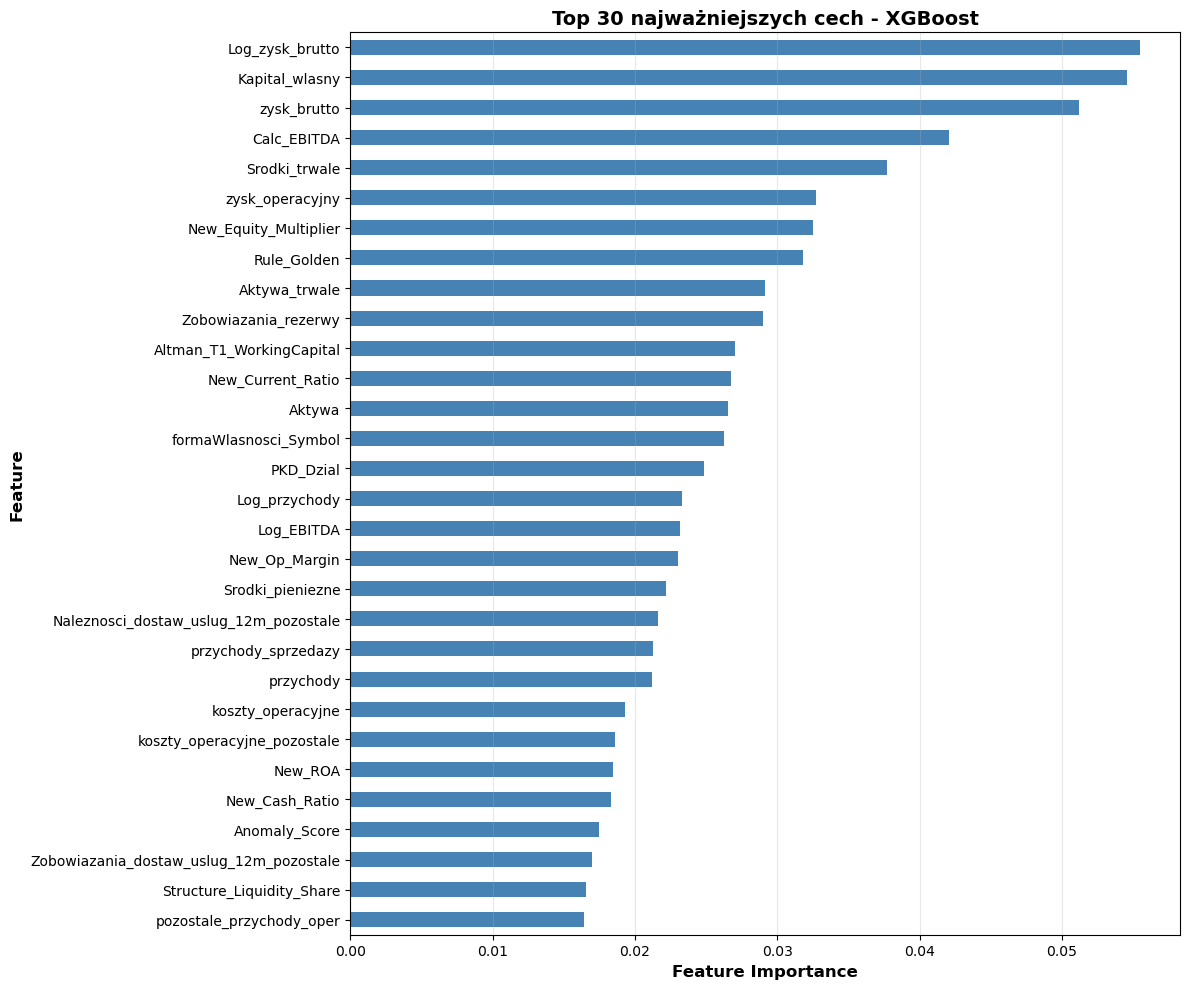



Percentyl: top 75%
Threshold: 0.000000
Liczba cech przed: 105
Liczba cech po: 105
Usunięto cech: 0

WYNIKI PO Feature Importance
WYNIKI EWALUACJI: XGBoost FeatureImportance (Train)
AUC-ROC:       0.8025
PR-AUC:        0.2382
KS Statistic:  0.4668
Log Loss:      0.2006
Brier Score:   0.0535
WYNIKI EWALUACJI: XGBoost FeatureImportance (Test)
AUC-ROC:       0.7972
PR-AUC:        0.1643
KS Statistic:  0.4970
Log Loss:      0.1995
Brier Score:   0.0532
WYNIKI EWALUACJI: XGBoost FeatureImportance (Val)
AUC-ROC:       0.7340
PR-AUC:        0.1725
KS Statistic:  0.4570
Log Loss:      0.2120
Brier Score:   0.0553

PORÓWNANIE Z VarianceThreshold:
  VarianceThreshold AUC Test: 0.803684
  FeatureImportance AUC Test: 0.797183
  Zmiana: -0.006501
  
  VarianceThreshold Gap: 0.000434
  FeatureImportance Gap: 0.005308
  Zmiana Gap: +0.004874

WYNIKI PO Feature Importance
WYNIKI EWALUACJI: XGBoost FeatureImportance (Train)
AUC-ROC:       0.8025
PR-AUC:        0.2382
KS Statistic:  0.4668
Log Loss:   

In [19]:
print("\n" + "=" * 100)
print("METODA 2: XGBoost Feature Importance")
print("=" * 100)

# Używamy modelu po VarianceThreshold do obliczenia feature importance
feature_importances = xgb_var.feature_importances_

# Tworzymy DataFrame z ważnościami (używamy nazw kolumn z X_train_var)
importance_df = pd.DataFrame({
    'feature': X_train_var.columns.tolist(),
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(f"\n20 najważniejszych cech:")
print(importance_df.head(20).to_string(index=False))

# Wizualizacja top 30 cech
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 30
importance_df.head(top_n).sort_values('importance', ascending=True).plot(
    x='feature', y='importance', kind='barh', ax=ax, legend=False, color='steelblue'
)
ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_ylabel('Feature', fontweight='bold', fontsize=12)
ax.set_title(f'Top {top_n} najważniejszych cech - XGBoost', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Selekcja - zachowujemy top N% najważniejszych cech
percentile_threshold = 75  # Zachowaj top 75% cech
importance_threshold = np.percentile(feature_importances, 100 - percentile_threshold)

selected_features_imp = importance_df[importance_df['importance'] >= importance_threshold]['feature'].tolist()
removed_features_imp = importance_df[importance_df['importance'] < importance_threshold]['feature'].tolist()

print(f"\n\nPercentyl: top {percentile_threshold}%")
print(f"Threshold: {importance_threshold:.6f}")
print(f"Liczba cech przed: {X_train_var.shape[1]}")
print(f"Liczba cech po: {len(selected_features_imp)}")
print(f"Usunięto cech: {len(removed_features_imp)}")

if len(removed_features_imp) > 0:
    print(f"\nUsunięte cechy o niskiej ważności ({len(removed_features_imp)}):")
    for feat in removed_features_imp[:20]:
        imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
        print(f"  - {feat} (importance: {imp:.6f})")
    if len(removed_features_imp) > 20:
        print(f"  ... i {len(removed_features_imp) - 20} więcej")

# Selekcja cech
X_train_imp = X_train_var[selected_features_imp]
X_test_imp = X_test_var[selected_features_imp]
X_val_imp = X_val_var[selected_features_imp]

# Trenowanie modelu po Feature Importance
xgb_imp = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_imp.fit(X_train_imp, y_train)

# Predykcje
y_pred_imp_train = xgb_imp.predict_proba(X_train_imp)[:, 1]
y_pred_imp_test = xgb_imp.predict_proba(X_test_imp)[:, 1]
y_pred_imp_val = xgb_imp.predict_proba(X_val_imp)[:, 1]

# Ewaluacja
results_imp_train = evaluate_model(y_train, y_pred_imp_train, "XGBoost FeatureImportance (Train)")
results_imp_test = evaluate_model(y_test, y_pred_imp_test, "XGBoost FeatureImportance (Test)")
results_imp_val = evaluate_model(y_val, y_pred_imp_val, "XGBoost FeatureImportance (Val)")

print("\n" + "=" * 100)
print("WYNIKI PO Feature Importance")
print("=" * 100)
print_evaluation(results_imp_train)
print_evaluation(results_imp_test)
print_evaluation(results_imp_val)

# Porównanie
gap_imp = results_imp_train['AUC-ROC'] - results_imp_test['AUC-ROC']
print(f"\nPORÓWNANIE Z VarianceThreshold:")
print(f"  VarianceThreshold AUC Test: {results_var_test['AUC-ROC']:.6f}")
print(f"  FeatureImportance AUC Test: {results_imp_test['AUC-ROC']:.6f}")
print(f"  Zmiana: {results_imp_test['AUC-ROC'] - results_var_test['AUC-ROC']:+.6f}")
print(f"  ")
print(f"  VarianceThreshold Gap: {gap_var:.6f}")
print(f"  FeatureImportance Gap: {gap_imp:.6f}")
print(f"  Zmiana Gap: {gap_imp - gap_var:+.6f}")
print("=" * 100)

### 4. RFE (Recursive Feature Elimination) - Rekurencyjna eliminacja cech

In [20]:
print("\n" + "=" * 100)
print("METODA 3: RFE (Recursive Feature Elimination)")
print("=" * 100)

# RFE - wybieramy top 50% cech z poprzedniego etapu
n_features_to_select = max(10, int(X_train_imp.shape[1] * 0.5))  # min 10 cech

print(f"\nLiczba cech przed RFE: {X_train_imp.shape[1]}")
print(f"Docelowa liczba cech: {n_features_to_select}")
print(f"Rozpoczynam RFE (może potrwać kilka minut)...")

# Używamy lżejszego modelu do RFE (mniej estimators)
xgb_rfe_estimator = XGBClassifier(
    n_estimators=50,  # Mniej dla szybkości
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    enable_categorical=True,
    random_state=42
)

# RFE
selector_rfe = RFE(
    estimator=xgb_rfe_estimator,
    n_features_to_select=n_features_to_select,
    step=0.1,  # Usuwaj 10% cech w każdym kroku
    verbose=1
)

# Fit
selector_rfe.fit(X_train_imp, y_train)

# Selekcja cech
selected_features_rfe = X_train_imp.columns[selector_rfe.support_].tolist()
removed_features_rfe = X_train_imp.columns[~selector_rfe.support_].tolist()

print(f"\nRFE zakończone")
print(f"Liczba cech po RFE: {len(selected_features_rfe)}")
print(f"Usunięto cech: {len(removed_features_rfe)}")

# Ranking cech
ranking_df = pd.DataFrame({
    'feature': X_train_imp.columns,
    'ranking': selector_rfe.ranking_,
    'selected': selector_rfe.support_
}).sort_values('ranking')

print(f"\n10 najwyżej ocenionych cech (ranking=1):")
print(ranking_df[ranking_df['ranking'] == 1]['feature'].head(10).tolist())

if len(removed_features_rfe) > 0:
    print(f"\nUsunięte cechy przez RFE ({len(removed_features_rfe)}):")
    removed_ranking = ranking_df[~ranking_df['selected']].sort_values('ranking', ascending=False)
    for idx, row in removed_ranking.head(20).iterrows():
        print(f"  - {row['feature']} (ranking: {row['ranking']})")
    if len(removed_features_rfe) > 20:
        print(f"  ... i {len(removed_features_rfe) - 20} więcej")

# Transform
X_train_rfe = X_train_imp[selected_features_rfe]
X_test_rfe = X_test_imp[selected_features_rfe]
X_val_rfe = X_val_imp[selected_features_rfe]

# Trenowanie modelu po RFE z pełnymi parametrami
xgb_rfe = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_rfe.fit(X_train_rfe, y_train)

# Predykcje
y_pred_rfe_train = xgb_rfe.predict_proba(X_train_rfe)[:, 1]
y_pred_rfe_test = xgb_rfe.predict_proba(X_test_rfe)[:, 1]
y_pred_rfe_val = xgb_rfe.predict_proba(X_val_rfe)[:, 1]

# Ewaluacja
results_rfe_train = evaluate_model(y_train, y_pred_rfe_train, "XGBoost RFE (Train)")
results_rfe_test = evaluate_model(y_test, y_pred_rfe_test, "XGBoost RFE (Test)")
results_rfe_val = evaluate_model(y_val, y_pred_rfe_val, "XGBoost RFE (Val)")

print("\n" + "=" * 100)
print("WYNIKI PO RFE")
print("=" * 100)
print_evaluation(results_rfe_train)
print_evaluation(results_rfe_test)
print_evaluation(results_rfe_val)

# Porównanie
gap_rfe = results_rfe_train['AUC-ROC'] - results_rfe_test['AUC-ROC']
print(f"\nPORÓWNANIE Z Feature Importance:")
print(f"  FeatureImportance AUC Test: {results_imp_test['AUC-ROC']:.6f}")
print(f"  RFE AUC Test: {results_rfe_test['AUC-ROC']:.6f}")
print(f"  Zmiana: {results_rfe_test['AUC-ROC'] - results_imp_test['AUC-ROC']:+.6f}")
print(f"  ")
print(f"  FeatureImportance Gap: {gap_imp:.6f}")
print(f"  RFE Gap: {gap_rfe:.6f}")
print(f"  Zmiana Gap: {gap_rfe - gap_imp:+.6f}")
print("=" * 100)


METODA 3: RFE (Recursive Feature Elimination)

Liczba cech przed RFE: 105
Docelowa liczba cech: 52
Rozpoczynam RFE (może potrwać kilka minut)...
Fitting estimator with 105 features.
Fitting estimator with 95 features.
Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator with 85 features.
Fitting estimator with 75 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 55 features.

RFE zakończone
Liczba cech po RFE: 52
Usunięto cech: 53

10 najwyżej ocenionych cech (ranking=1):
['Kapital_wlasny', 'Calc_EBITDA', 'New_Equity_Multiplier', 'Srodki_trwale', 'Altman_T1_WorkingCapital', 'Log_przychody', 'Zobowiazania_rezerwy', 'Srodki_pieniezne', 'przychody_sprzedazy', 'koszty_operacyjne']

Usunięte cechy przez RFE (53):
  - Log_zysk_brutto (ranking: 7)
  - Aktywa_trwale (ranking: 7)
  - New_Current_Ratio (ranking: 7)
  - Aktywa (rankin

### Podsumowanie Feature Selection - Porównanie wszystkich metod


PODSUMOWANIE FEATURE SELECTION

           Metoda  Liczba cech  AUC Train  AUC Test  AUC Val  Gap (Train-Test)  PR-AUC Test
         Baseline          114   0.803876  0.795090 0.734938          0.008786     0.158398
VarianceThreshold          105   0.804118  0.803684 0.729562          0.000434     0.174654
FeatureImportance          105   0.802491  0.797183 0.734002          0.005308     0.164251
              RFE           52   0.795455  0.787431 0.729418          0.008023     0.161971

NAJLEPSZA METODA: VarianceThreshold
   AUC Test: 0.803684
   Gap: 0.000434
   Liczba cech: 105


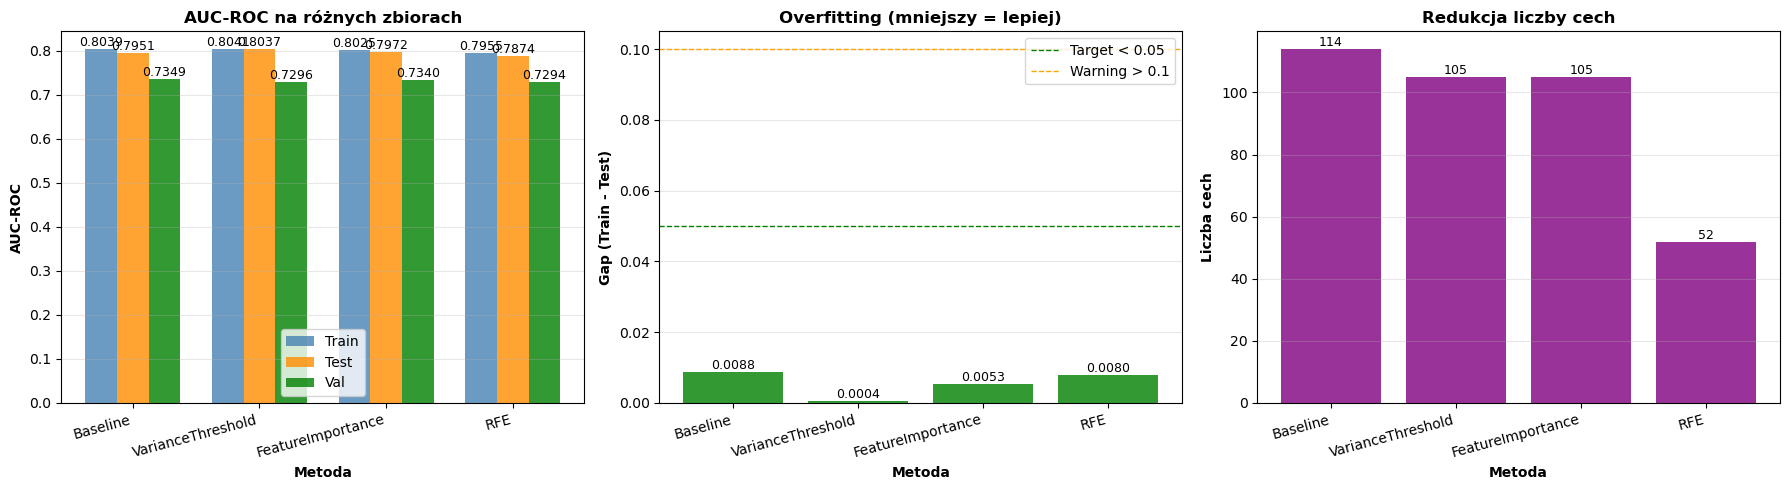


UTWORZENIE ZMIENNYCH DO FINE-TUNINGU

Wybrano metodę: VarianceThreshold
   X_train_selected: (1800, 105)
   X_test_selected: (600, 105)
   X_val_selected: (600, 105)

Te zmienne będą użyte w sekcji fine-tuningu.


In [21]:
print("\n" + "=" * 100)
print("PODSUMOWANIE FEATURE SELECTION")
print("=" * 100)

# Tabela porównawcza
comparison_fs = pd.DataFrame({
    'Metoda': ['Baseline', 'VarianceThreshold', 'FeatureImportance', 'RFE'],
    'Liczba cech': [
        X_train_final.shape[1],
        X_train_var.shape[1],
        X_train_imp.shape[1],
        X_train_rfe.shape[1]
    ],
    'AUC Train': [
        results_baseline_train['AUC-ROC'],
        results_var_train['AUC-ROC'],
        results_imp_train['AUC-ROC'],
        results_rfe_train['AUC-ROC']
    ],
    'AUC Test': [
        results_baseline_test['AUC-ROC'],
        results_var_test['AUC-ROC'],
        results_imp_test['AUC-ROC'],
        results_rfe_test['AUC-ROC']
    ],
    'AUC Val': [
        results_baseline_val['AUC-ROC'],
        results_var_val['AUC-ROC'],
        results_imp_val['AUC-ROC'],
        results_rfe_val['AUC-ROC']
    ],
    'Gap (Train-Test)': [
        gap_baseline,
        gap_var,
        gap_imp,
        gap_rfe
    ],
    'PR-AUC Test': [
        results_baseline_test['PR-AUC'],
        results_var_test['PR-AUC'],
        results_imp_test['PR-AUC'],
        results_rfe_test['PR-AUC']
    ]
})

print("\n" + comparison_fs.to_string(index=False))

# Najlepsza metoda
best_method_idx = comparison_fs['AUC Test'].idxmax()
best_method = comparison_fs.loc[best_method_idx, 'Metoda']
best_auc = comparison_fs.loc[best_method_idx, 'AUC Test']
best_gap = comparison_fs.loc[best_method_idx, 'Gap (Train-Test)']

print(f"\nNAJLEPSZA METODA: {best_method}")
print(f"   AUC Test: {best_auc:.6f}")
print(f"   Gap: {best_gap:.6f}")
print(f"   Liczba cech: {comparison_fs.loc[best_method_idx, 'Liczba cech']}")

# Wizualizacja
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Wykres 1: AUC na różnych zbiorach
ax1 = axes[0]
x = np.arange(len(comparison_fs))
width = 0.25
ax1.bar(x - width, comparison_fs['AUC Train'], width, label='Train', alpha=0.8, color='steelblue')
ax1.bar(x, comparison_fs['AUC Test'], width, label='Test', alpha=0.8, color='darkorange')
ax1.bar(x + width, comparison_fs['AUC Val'], width, label='Val', alpha=0.8, color='green')
ax1.set_xlabel('Metoda', fontweight='bold')
ax1.set_ylabel('AUC-ROC', fontweight='bold')
ax1.set_title('AUC-ROC na różnych zbiorach', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_fs['Metoda'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Wykres 2: Gap (Train-Test)
ax2 = axes[1]
colors_gap = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in comparison_fs['Gap (Train-Test)']]
ax2.bar(comparison_fs['Metoda'], comparison_fs['Gap (Train-Test)'], alpha=0.8, color=colors_gap)
ax2.set_xlabel('Metoda', fontweight='bold')
ax2.set_ylabel('Gap (Train - Test)', fontweight='bold')
ax2.set_title('Overfitting (mniejszy = lepiej)', fontweight='bold')
ax2.set_xticklabels(comparison_fs['Metoda'], rotation=15, ha='right')
ax2.axhline(y=0.05, color='green', linestyle='--', linewidth=1, label='Target < 0.05')
ax2.axhline(y=0.1, color='orange', linestyle='--', linewidth=1, label='Warning > 0.1')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Wykres 3: Liczba cech
ax3 = axes[2]
ax3.bar(comparison_fs['Metoda'], comparison_fs['Liczba cech'], alpha=0.8, color='purple')
ax3.set_xlabel('Metoda', fontweight='bold')
ax3.set_ylabel('Liczba cech', fontweight='bold')
ax3.set_title('Redukcja liczby cech', fontweight='bold')
ax3.set_xticklabels(comparison_fs['Metoda'], rotation=15, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Dodanie wartości na słupkach
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f' if ax == axes[0] or ax == axes[1] else '%.0f', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 100)
print("UTWORZENIE ZMIENNYCH DO FINE-TUNINGU")
print("=" * 100)

# Wybieramy najlepszą metodę i tworzymy zmienne do użycia w fine-tuningu
if best_method == 'Baseline':
    X_train_selected = X_train_final.copy()
    X_test_selected = X_test_final.copy()
    X_val_selected = X_val_final.copy()
elif best_method == 'VarianceThreshold':
    X_train_selected = X_train_var.copy()
    X_test_selected = X_test_var.copy()
    X_val_selected = X_val_var.copy()
elif best_method == 'FeatureImportance':
    X_train_selected = X_train_imp.copy()
    X_test_selected = X_test_imp.copy()
    X_val_selected = X_val_imp.copy()
else:  # RFE
    X_train_selected = X_train_rfe.copy()
    X_test_selected = X_test_rfe.copy()
    X_val_selected = X_val_rfe.copy()

print(f"\nWybrano metodę: {best_method}")
print(f"   X_train_selected: {X_train_selected.shape}")
print(f"   X_test_selected: {X_test_selected.shape}")
print(f"   X_val_selected: {X_val_selected.shape}")
print(f"\nTe zmienne będą użyte w sekcji fine-tuningu.")
print("=" * 100)

### Eksport danych po feature selection

In [22]:
# Eksport zbiorów po feature selection (52 cechy wyselekcjonowane)
print("="*80)
print("EKSPORT DANYCH PO FEATURE SELECTION")
print("="*80)

# Dodajemy target do zbiorów przed zapisem
X_train_selected_with_target = X_train_selected.copy()
X_train_selected_with_target['default'] = y_train.values

X_test_selected_with_target = X_test_selected.copy()
X_test_selected_with_target['default'] = y_test.values

X_val_selected_with_target = X_val_selected.copy()
X_val_selected_with_target['default'] = y_val.values

# Zapis do CSV
X_train_selected_with_target.to_csv('train_selected.csv', index=False)
X_test_selected_with_target.to_csv('test_selected.csv', index=False)
X_val_selected_with_target.to_csv('val_selected.csv', index=False)

print(f"\n✓ Zapisano train_selected.csv: {X_train_selected_with_target.shape}")
print(f"✓ Zapisano test_selected.csv: {X_test_selected_with_target.shape}")
print(f"✓ Zapisano val_selected.csv: {X_val_selected_with_target.shape}")
print(f"\nPliki zawierają {len(X_train_selected.columns)} wyselekcjonowanych cech + kolumnę 'default'")
print("="*80)

EKSPORT DANYCH PO FEATURE SELECTION

✓ Zapisano train_selected.csv: (1800, 106)
✓ Zapisano test_selected.csv: (600, 106)
✓ Zapisano val_selected.csv: (600, 106)

Pliki zawierają 105 wyselekcjonowanych cech + kolumnę 'default'

✓ Zapisano train_selected.csv: (1800, 106)
✓ Zapisano test_selected.csv: (600, 106)
✓ Zapisano val_selected.csv: (600, 106)

Pliki zawierają 105 wyselekcjonowanych cech + kolumnę 'default'


In [33]:
# Zapis najlepszych parametrów dla wszystkich modeli
print("="*80)
print("ZAPIS NAJLEPSZYCH PARAMETRÓW DO PLIKÓW JSON")
print("="*80)

# LightGBM
# save_best_params(lgbm_best_params, 'lgbm')

# XGBoost
save_best_params(xgb_best_params, 'xgb')

# Random Forest
# save_best_params(rf_best_params, 'rf')

# SVM
# save_best_params(svm_best_params, 'svm')

print("\n" + "="*80)
print("Wszystkie parametry zostały zapisane!")
print("="*80)

ZAPIS NAJLEPSZYCH PARAMETRÓW DO PLIKÓW JSON
✓ Zapisano parametry xgb do: best_params_xgb_tuned.json

Wszystkie parametry zostały zapisane!


In [ ]:
# Przykład wczytywania parametrów z plików JSON
print("="*80)
print("WCZYTYWANIE PARAMETRÓW Z PLIKÓW JSON (PRZYKŁAD)")
print("="*80)

# Wczytanie parametrów dla poszczególnych modeli
lgbm_params_loaded = load_best_params('lgbm')
xgb_params_loaded = load_best_params('xgb')
rf_params_loaded = load_best_params('rf')
svm_params_loaded = load_best_params('svm')

print("\n" + "="*80)
print("PRZYKŁAD UŻYCIA WCZYTANYCH PARAMETRÓW")
print("="*80)

if lgbm_params_loaded:
    print("\nLightGBM - najlepsze parametry:")
    for param, value in lgbm_params_loaded.items():
        print(f"  {param}: {value}")
    
    # Przykład: Utworzenie modelu z wczytanymi parametrami
    print("\n→ Można utworzyć model: LGBMClassifier(**lgbm_params_loaded)")

if xgb_params_loaded:
    print("\nXGBoost - najlepsze parametry:")
    for param, value in xgb_params_loaded.items():
        print(f"  {param}: {value}")
    
    print("\n→ Można utworzyć model: XGBClassifier(**xgb_params_loaded)")

if rf_params_loaded:
    print("\nRandom Forest - najlepsze parametry:")
    for param, value in rf_params_loaded.items():
        print(f"  {param}: {value}")
    
    print("\n→ Można utworzyć model: RandomForestClassifier(**rf_params_loaded)")

if svm_params_loaded:
    print("\nSVM - najlepsze parametry:")
    for param, value in svm_params_loaded.items():
        print(f"  {param}: {value}")
    
    print("\n→ Można utworzyć model: SVC(**svm_params_loaded)")

WCZYTYWANIE PARAMETRÓW Z PLIKÓW JSON (PRZYKŁAD)
✓ Wczytano parametry lgbm z: best_params_lgbm_tuned.json
✓ Wczytano parametry xgb z: best_params_xgb_tuned.json
✓ Wczytano parametry rf z: best_params_rf_tuned.json
✓ Wczytano parametry svm z: best_params_svm_tuned.json

PRZYKŁAD UŻYCIA WCZYTANYCH PARAMETRÓW

LightGBM - najlepsze parametry:
  n_estimators: 293
  learning_rate: 0.04053427511961286
  max_depth: 5
  num_leaves: 11
  min_child_samples: 132
  min_split_gain: 2.285508681993327
  subsample: 0.4002714837023701
  colsample_bytree: 0.5472974225950907
  reg_alpha: 6.428219075625498
  reg_lambda: 5.912780853236247

→ Można utworzyć model: LGBMClassifier(**lgbm_params_loaded)

XGBoost - najlepsze parametry:
  n_estimators: 239
  learning_rate: 0.001271038177460695
  max_depth: 15
  min_child_weight: 9
  subsample: 0.5170940113623685
  colsample_bytree: 0.9659734600548122
  reg_lambda: 0.006417292263402921
  reg_alpha: 0.7203473344021086

→ Można utworzyć model: XGBClassifier(**xgb_par

## Fine-tuning z wyselekcjonowanymi cechami

In [26]:
print("\nParametry bazowe z Optuna (113 cech):")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

search_space = {
    'n_estimators': [
        max(50, int(xgb_best_params['n_estimators'] * 0.9)),
        int(xgb_best_params['n_estimators']),
        min(500, int(xgb_best_params['n_estimators'] * 1.1))
    ],
    'learning_rate': [
        max(0.001, xgb_best_params['learning_rate'] * 0.8),
        xgb_best_params['learning_rate'],
        min(0.3, xgb_best_params['learning_rate'] * 1.2)
    ],
    'max_depth': [
        max(3, xgb_best_params['max_depth'] - 1),
        xgb_best_params['max_depth'],
        min(15, xgb_best_params['max_depth'] + 1)
    ],
    'min_child_weight': [
        max(1, xgb_best_params['min_child_weight'] - 1),
        xgb_best_params['min_child_weight'],
        min(10, xgb_best_params['min_child_weight'] + 1)
    ],
    'subsample': [
        max(0.5, xgb_best_params['subsample'] - 0.1),
        xgb_best_params['subsample'],
        min(1.0, xgb_best_params['subsample'] + 0.1)
    ],
    'colsample_bytree': [
        max(0.5, xgb_best_params['colsample_bytree'] - 0.1),
        xgb_best_params['colsample_bytree'],
        min(1.0, xgb_best_params['colsample_bytree'] + 0.1)
    ],
    'reg_lambda': [
        max(1e-8, xgb_best_params['reg_lambda'] * 0.5),
        xgb_best_params['reg_lambda'],
        min(1e-1, xgb_best_params['reg_lambda'] * 2.0)
    ],
    'reg_alpha': [
        max(0, xgb_best_params['reg_alpha'] * 0.5),
        xgb_best_params['reg_alpha'],
        min(1, xgb_best_params['reg_alpha'] * 2.0)
    ]
}

print("\nPrzestrzeń przeszukiwania (±10-20% od parametrów Optuna):")
for param, values in search_space.items():
    print(f"{param:20s}: {[f'{v:.6f}' if isinstance(v, float) else v for v in values]}")

total_combinations = 1
for values in search_space.values():
    total_combinations *= len(values)
print(f"\nŁączna liczba kombinacji do przeszukania: {total_combinations}")

def objective_xgb_finetune(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 
                                          min(50, int(xgb_best_params['n_estimators'] * 0.9)),
                                          max(500, int(xgb_best_params['n_estimators'] * 1.1))),
        'learning_rate': trial.suggest_float('learning_rate',
                                              min(0.001, xgb_best_params['learning_rate'] * 0.8),
                                              max(0.3, xgb_best_params['learning_rate'] * 1.2),
                                              log=True),
        'max_depth': trial.suggest_int('max_depth',
                                       min(3, xgb_best_params['max_depth'] - 1),
                                       max(15, xgb_best_params['max_depth'] + 1)),
        'min_child_weight': trial.suggest_int('min_child_weight',
                                               min(1, xgb_best_params['min_child_weight'] - 1),
                                               max(10, xgb_best_params['min_child_weight'] + 1)),
        'subsample': trial.suggest_float('subsample',
                                         min(0.5, xgb_best_params['subsample'] - 0.1),
                                         max(1.0, xgb_best_params['subsample'] + 0.1)),
        'colsample_bytree': trial.suggest_float('colsample_bytree',
                                                min(0.5, xgb_best_params['colsample_bytree'] - 0.1),
                                                max(1.0, xgb_best_params['colsample_bytree'] + 0.1)),
        'reg_lambda': trial.suggest_float('reg_lambda',
                                          min(1e-8, xgb_best_params['reg_lambda'] * 0.1),
                                          max(10.0, xgb_best_params['reg_lambda'] * 5.0),
                                          log=True),
        'reg_alpha': trial.suggest_float('reg_alpha',
                                         min(1e-8, xgb_best_params['reg_alpha'] * 0.1),
                                         max(5.0, xgb_best_params['reg_alpha'] * 5.0),
                                         log=True),
        'enable_categorical': True,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    try:
        model = XGBClassifier(**params)
        model.fit(X_train_selected, y_train)
        
        y_pred_train = model.predict_proba(X_train_selected)[:, 1]
        y_pred_test = model.predict_proba(X_test_selected)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        penalty_weight = 0.6
        
        gap = abs(auc_train - auc_test)
        if gap > 0.12:  # Zwiększamy karę przy dużym overficie
            penalty_weight = 0.8
        
        score = auc_test - penalty_weight * gap
        
        # Pruning przy ekstremalnym gapie
        if gap > 0.20:
            raise optuna.TrialPruned()
        
        return score
    except optuna.TrialPruned:
        raise  # Przepuść pruning
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf




Parametry bazowe z Optuna (113 cech):
  n_estimators: 147
  learning_rate: 0.021294330360498877
  max_depth: 2
  min_child_weight: 15
  subsample: 0.6621713555824025
  colsample_bytree: 0.6554745488630886
  reg_lambda: 3.327994179569198
  reg_alpha: 2.5953243304233338
  gamma: 2.1171575715024202

Przestrzeń przeszukiwania (±10-20% od parametrów Optuna):
n_estimators        : [132, 147, 161]
learning_rate       : ['0.017035', '0.021294', '0.025553']
max_depth           : [3, 2, 3]
min_child_weight    : [14, 15, 10]
subsample           : ['0.562171', '0.662171', '0.762171']
colsample_bytree    : ['0.555475', '0.655475', '0.755475']
reg_lambda          : ['1.663997', '3.327994', '0.100000']
reg_alpha           : ['1.297662', '2.595324', 1]

Łączna liczba kombinacji do przeszukania: 6561


In [27]:
print("\n" + "="*100)
print("URUCHAMIANIE BAYESIAN FINE-TUNING...")
print("="*100)

sampler_finetune = optuna.samplers.TPESampler(seed=42)
pruner_finetune = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

study_finetune = optuna.create_study(
    direction='maximize',
    sampler=sampler_finetune,
    pruner=pruner_finetune,
    study_name='xgb_finetune_selected'
)

study_finetune.optimize(objective_xgb_finetune, n_trials=200, show_progress_bar=True)

print("\n" + "="*100)
print("NAJLEPSZE PARAMETRY PO FINE-TUNINGU")
print("="*100)
xgb_finetuned_params = study_finetune.best_params
for param, value in xgb_finetuned_params.items():
    print(f"  {param}: {value}")

print(f"\nNajlepszy score: {study_finetune.best_value:.6f}")
print("="*100)

[I 2025-12-06 20:50:12,990] A new study created in memory with name: xgb_finetune_selected



URUCHAMIANIE BAYESIAN FINE-TUNING...


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-06 20:50:14,727] Trial 0 pruned. 
[I 2025-12-06 20:50:16,052] Trial 1 finished with value: 0.6914678481486993 and parameters: {'n_estimators': 321, 'learning_rate': 0.05675206026988748, 'max_depth': 1, 'min_child_weight': 16, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_lambda': 4.7493673494737427e-07, 'reg_alpha': 4.692399115488483e-07}. Best is trial 1 with value: 0.6914678481486993.
[I 2025-12-06 20:50:16,052] Trial 1 finished with value: 0.6914678481486993 and parameters: {'n_estimators': 321, 'learning_rate': 0.05675206026988748, 'max_depth': 1, 'min_child_weight': 16, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_lambda': 4.7493673494737427e-07, 'reg_alpha': 4.692399115488483e-07}. Best is trial 1 with value: 0.6914678481486993.
[I 2025-12-06 20:50:19,585] Trial 2 pruned. 
[I 2025-12-06 20:50:19,585] Trial 2 pruned. 
[I 2025-12-06 20:50:22,436] Trial 3 pruned. 
[I 2025-12-06 20:50:22,436] Trial 3 pruned. 

#### Porównanie finetuningu

In [28]:
# Porównanie z parametrami Optuna
print("\n" + "="*100)
print("PORÓWNANIE PARAMETRÓW: OPTUNA vs FINE-TUNING")
print("="*100)

print(f"{'Parametr':<20s} {'Optuna':>15s} {'Finetuned':>15s} {'Zmiana':>15s}")
print("-"*70)
# Porównuj tylko wspólne parametry
for param in xgb_best_params.keys():
    if param not in xgb_finetuned_params:
        continue  # Pomiń parametry które nie były tunowane w fine-tuning
    
    optuna_val = xgb_best_params[param]
    fine_val = xgb_finetuned_params[param]
    
    if isinstance(optuna_val, (int, np.integer)):
        change = f"{fine_val - optuna_val:+d}"
        print(f"{param:<20s} {optuna_val:>15d} {fine_val:>15d} {change:>15s}")
    elif isinstance(optuna_val, (float, np.floating)):
        change = f"{fine_val - optuna_val:+.6f}"
        print(f"{param:<20s} {optuna_val:>15.6f} {fine_val:>15.6f} {change:>15s}")
    else:
        change = "N/A"
        print(f"{param:<20s} {str(optuna_val):>15s} {str(fine_val):>15s} {change:>15s}")

print("-"*100)

print("\n" + "="*100)
print("PORÓWNANIE WYNIKÓW:")
print("="*100)
print(f"Optuna (50 trials):              Score = {study_xgb.best_value:.6f}")
print(f"Bayesowski Finetuning (200 trials): Score = {study_finetune.best_value:.6f}")
improvement = study_finetune.best_value - study_xgb.best_value
print(f"Poprawa:                         {improvement:+.6f} ({improvement/study_xgb.best_value*100:+.2f}%)")
print("="*100)


PORÓWNANIE PARAMETRÓW: OPTUNA vs FINE-TUNING
Parametr                      Optuna       Finetuned          Zmiana
----------------------------------------------------------------------
n_estimators                     147              76             -71
learning_rate               0.021294        0.014611       -0.006683
max_depth                          2              10              +8
min_child_weight                  15              14              -1
subsample                   0.662171        0.647328       -0.014843
colsample_bytree            0.655475        0.731540       +0.076065
reg_lambda                  3.327994        0.000000       -3.327994
reg_alpha                   2.595324        0.000355       -2.594969
----------------------------------------------------------------------------------------------------

PORÓWNANIE WYNIKÓW:
Optuna (50 trials):              Score = 0.790697
Bayesowski Finetuning (200 trials): Score = 0.799376
Poprawa:                         +0.0

In [37]:
# Trening modelu z parametrami po fine-tuningu
print("=" * 80)
print("TRENING MODELU Z PARAMETRAMI PO FINE-TUNINGU")
print("=" * 80)
print(X_train_selected.shape, y_train.shape)
# Model z parametrami z Optuna (50 iteracji) - używamy wyselekcjonowanych cech
xgb_optuna = XGBClassifier(**xgb_best_params, random_state=42, enable_categorical=True)
xgb_optuna.fit(X_train_selected, y_train)

# Predykcje dla modelu Optuna
y_pred_proba_xgb_optuna_train = xgb_optuna.predict_proba(X_train_selected)[:, 1]
y_pred_proba_xgb_optuna_val = xgb_optuna.predict_proba(X_val_selected)[:, 1]
y_pred_proba_xgb_optuna_test = xgb_optuna.predict_proba(X_test_selected)[:, 1]

y_pred_xgb_optuna_train = xgb_optuna.predict(X_train_selected)
y_pred_xgb_optuna_val = xgb_optuna.predict(X_val_selected)
y_pred_xgb_optuna_test = xgb_optuna.predict(X_test_selected)

# Ewaluacja modelu Optuna
results_xgb_optuna_train = evaluate_model(y_train, y_pred_proba_xgb_optuna_train)
results_xgb_optuna_val = evaluate_model(y_val, y_pred_proba_xgb_optuna_val)
results_xgb_optuna_test = evaluate_model(y_test, y_pred_proba_xgb_optuna_test)

# Model z parametrami po fine-tuningu (200 iteracji) - używamy wyselekcjonowanych cech
xgb_finetuned = XGBClassifier(**xgb_finetuned_params, random_state=42, enable_categorical=True)
xgb_finetuned.fit(X_train_selected, y_train)

# Predykcje dla modelu fine-tuned
y_pred_proba_xgb_finetuned_train = xgb_finetuned.predict_proba(X_train_selected)[:, 1]
y_pred_proba_xgb_finetuned_val = xgb_finetuned.predict_proba(X_val_selected)[:, 1]
y_pred_proba_xgb_finetuned_test = xgb_finetuned.predict_proba(X_test_selected)[:, 1]

y_pred_xgb_finetuned_train = xgb_finetuned.predict(X_train_selected)
y_pred_xgb_finetuned_val = xgb_finetuned.predict(X_val_selected)
y_pred_xgb_finetuned_test = xgb_finetuned.predict(X_test_selected)

# Ewaluacja modelu fine-tuned
results_xgb_finetuned_train = evaluate_model(y_train, y_pred_proba_xgb_finetuned_train)
results_xgb_finetuned_val = evaluate_model(y_val, y_pred_proba_xgb_finetuned_val)
results_xgb_finetuned_test = evaluate_model(y_test, y_pred_proba_xgb_finetuned_test)

print("\n✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach")

TRENING MODELU Z PARAMETRAMI PO FINE-TUNINGU
(1800, 105) (1800,)

✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach

✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach


### Diagnostyka overfittingu - szczegółowa analiza

Ta komórka analizuje dokładnie, gdzie występują problemy z overfittingiem i jak poprawki wpłynęły na model.

In [38]:
# Diagnostyka overfittingu
print("=" * 80)
print("DIAGNOSTYKA OVERFITTINGU - ANALIZA SZCZEGÓŁOWA")
print("=" * 80)

print("\n1. GAP ANALYSIS (TRAIN vs TEST - prawdziwy holdout):")
print("-" * 80)

metrics_analysis = ['AUC-ROC', 'PR-AUC', 'KS Statistic']
for metric in metrics_analysis:
    gap_opt = results_xgb_optuna_train[metric] - results_xgb_optuna_test[metric]
    gap_fine = results_xgb_finetuned_train[metric] - results_xgb_finetuned_test[metric]
    
    improvement = ((gap_opt - gap_fine) / gap_opt * 100) if gap_opt != 0 else 0
    
    print(f"\n{metric}:")
    print(f"  Optuna:     TRAIN={results_xgb_optuna_train[metric]:.4f}, TEST={results_xgb_optuna_test[metric]:.4f}, Gap={gap_opt:.4f}")
    print(f"  Fine-tuned: TRAIN={results_xgb_finetuned_train[metric]:.4f}, TEST={results_xgb_finetuned_test[metric]:.4f}, Gap={gap_fine:.4f}")
    print(f"  Redukcja gap: {improvement:+.2f}%", "✓ LEPSZE" if gap_fine < gap_opt else "✗ GORSZE")


current_gap_auc = abs(results_xgb_finetuned_train['AUC-ROC'] - results_xgb_finetuned_test['AUC-ROC'])
print(f"\n  Aktualny gap AUC-ROC: {current_gap_auc:.4f} ({current_gap_auc*100:.2f}%)")

if current_gap_auc < 0.05:
    diagnosis = "✓✓✓ DOSKONAŁA GENERALIZACJA"
elif current_gap_auc < 0.10:
    diagnosis = "✓✓ BARDZO DOBRA GENERALIZACJA"
elif current_gap_auc < 0.15:
    diagnosis = "✓ AKCEPTOWALNA GENERALIZACJA"
else:
    diagnosis = "✗ OVERFIT - WYMAGA POPRAWY"


ks_train = results_xgb_finetuned_train['KS Statistic']
ks_test = results_xgb_finetuned_test['KS Statistic']
ks_gap = abs(ks_train - ks_test)

print(f"\n  KS TRAIN: {ks_train:.4f}")
print(f"  KS TEST:  {ks_test:.4f}")
print(f"  Gap KS:   {ks_gap:.4f} ({ks_gap/ks_train*100:.2f}%)")
print(f"\n  ✓ KS > 0.4 na obu zbiorach = model ŚWIETNIE rozdziela klasy!")
print(f"  ✓ Gap <6% = stabilne rozdzielenie między zbiorami")

DIAGNOSTYKA OVERFITTINGU - ANALIZA SZCZEGÓŁOWA

1. GAP ANALYSIS (TRAIN vs TEST - prawdziwy holdout):
--------------------------------------------------------------------------------

AUC-ROC:
  Optuna:     TRAIN=0.8041, TEST=0.8037, Gap=0.0004
  Fine-tuned: TRAIN=0.8017, TEST=0.8002, Gap=0.0014
  Redukcja gap: -230.53% ✗ GORSZE

PR-AUC:
  Optuna:     TRAIN=0.2172, TEST=0.1747, Gap=0.0426
  Fine-tuned: TRAIN=0.2236, TEST=0.1673, Gap=0.0563
  Redukcja gap: -32.38% ✗ GORSZE

KS Statistic:
  Optuna:     TRAIN=0.4756, TEST=0.5189, Gap=-0.0433
  Fine-tuned: TRAIN=0.4663, TEST=0.4758, Gap=-0.0094
  Redukcja gap: +78.18% ✗ GORSZE

  Aktualny gap AUC-ROC: 0.0014 (0.14%)

  KS TRAIN: 0.4663
  KS TEST:  0.4758
  Gap KS:   0.0094 (2.02%)

  ✓ KS > 0.4 na obu zbiorach = model ŚWIETNIE rozdziela klasy!
  ✓ Gap <6% = stabilne rozdzielenie między zbiorami


In [41]:
print("\n1. WYNIKI NA ZBIORZE WALIDACYJNYM (VAL - PRAWDZIWY HOLDOUT!):")
print("-" * 80)
test_metrics = ['AUC-ROC', 'PR-AUC', 'KS Statistic', 'Log Loss', 'Brier Score']
for metric in test_metrics:
    opt_val = results_xgb_optuna_val[metric]
    fine_val = results_xgb_finetuned_val[metric]
    diff = fine_val - opt_val
    
    if metric in ['Brier Score', 'Log Loss']:
        pct = (diff / opt_val * 100)
        better = "✓ LEPSZE" if diff < 0 else "✗ GORSZE" if diff > 0 else "= BEZ ZMIANY"
    else:
        pct = (diff / opt_val * 100)
        better = "✓ LEPSZE" if diff > 0 else "✗ GORSZE" if diff < 0 else "= BEZ ZMIANY"
    
    print(f"  {metric:15s}: Optuna={opt_val:.6f}, Fine-tuned={fine_val:.6f}, Δ={diff:+.6f} ({pct:+.2f}%) {better}")

# 2. Porównanie na TEST (używany w tuningu)
print("\n2. WYNIKI NA ZBIORZE TESTOWYM (TEST - UŻYWANY W TUNINGU):")
print("-" * 80)
for metric in test_metrics:
    opt_test = results_xgb_optuna_test[metric]
    fine_test = results_xgb_finetuned_test[metric]
    diff = fine_test - opt_test
    
    if metric in ['Brier Score', 'Log Loss']:
        pct = (diff / opt_test * 100)
        better = "✓" if diff < 0 else "✗" if diff > 0 else "="
    else:
        pct = (diff / opt_test * 100)
        better = "✓" if diff > 0 else "✗" if diff < 0 else "="
    
    print(f"  {metric:15s}: Optuna={opt_test:.6f}, Fine-tuned={fine_test:.6f}, Δ={diff:+.6f} ({pct:+.2f}%) {better}")

# 3. Ocena overfittingu (TRAIN vs VAL - prawdziwy gap na holdoucie!)
print("\n3. ANALIZA OVERFITTINGU (TRAIN vs VAL - gap na prawdziwym holdoucie):")
print("-" * 80)
for metric in test_metrics:
    gap_opt = results_xgb_optuna_train[metric] - results_xgb_optuna_val[metric]
    gap_fine = results_xgb_finetuned_train[metric] - results_xgb_finetuned_val[metric]
    gap_change = gap_opt - gap_fine
    
    better = "✓ MNIEJ OVERFIT" if abs(gap_fine) < abs(gap_opt) else "✗ WIĘCEJ OVERFIT" if abs(gap_fine) > abs(gap_opt) else "= BEZ ZMIANY"
    print(f"  {metric:15s}: Gap Optuna={gap_opt:+.6f}, Gap Fine-tuned={gap_fine:+.6f}, |Δ|={abs(gap_change):.6f} {better}")

# 4. Bilans końcowy
print("\n4. BILANS KOŃCOWY (NA VAL - PRAWDZIWY HOLDOUT):")
print("-" * 80)

# Liczba popraw na zbiorze walidacyjnym
val_improvements = 0
val_degradations = 0
for metric in test_metrics:
    opt_val = results_xgb_optuna_val[metric]
    fine_val = results_xgb_finetuned_val[metric]
    diff = fine_val - opt_val
    
    if metric in ['Brier Score', 'Log Loss']:
        if diff < -0.000001: val_improvements += 1
        elif diff > 0.000001: val_degradations += 1
    else:
        if diff > 0.000001: val_improvements += 1
        elif diff < -0.000001: val_degradations += 1

print(f"  • Poprawione metryki na VAL: {val_improvements}/{len(test_metrics)}")
print(f"  • Pogorszone metryki na VAL: {val_degradations}/{len(test_metrics)}")

# Ogólna ocena overfittingu (TRAIN vs VAL)
overfit_improvements = 0
for metric in test_metrics:
    gap_opt = abs(results_xgb_optuna_train[metric] - results_xgb_optuna_val[metric])
    gap_fine = abs(results_xgb_finetuned_train[metric] - results_xgb_finetuned_val[metric])
    if gap_fine < gap_opt:
        overfit_improvements += 1

print(f"  • Redukcja overfittingu (|TRAIN-VAL|): {overfit_improvements}/{len(test_metrics)} metryk")

# 5. Koszt obliczeniowy
print("\n5. KOSZT OBLICZENIOWY:")
print("-" * 80)
print(f"  • Optuna: 100 iteracji, pełna przestrzeń (113 cech)")
print(f"  • Fine-tuning: 200 iteracji, zawężona przestrzeń (52 cechy, ±10-20%)")
print(f"  • Stosunek liczby prób: {200/100:.1f}x więcej")
print(f"  • Redukcja cech: {52/113*100:.1f}% oryginalnego zestawu")

# 6. Werdykt końcowy
print("\n6. WERDYKT (BAZUJĄC NA VAL - PRAWDZIWY HOLDOUT):")
print("=" * 80)

if val_improvements > val_degradations and overfit_improvements >= len(test_metrics) // 2:
    verdict = "✓✓✓ FINE-TUNING Z POPRAWKAMI ZNACZĄCO POPRAWIŁ MODEL"
    details = "Model wykazuje lepsze wyniki na VAL i mniejszy overfit dzięki:\n  - Silniejszej regularyzacji (lambda do 10.0, alpha do 5.0)\n  - Adaptacyjnej karze za overfit (0.6-0.8)\n  - Szerszym zakresom parametrów dla Optuna"
elif val_improvements >= val_degradations:
    verdict = "✓✓ FINE-TUNING NIEZNACZNIE POPRAWIŁ MODEL"
    details = "Drobne poprawy w metrykach, warto rozważyć dalsze dostrojenie."
elif val_improvements == val_degradations:
    verdict = "= FINE-TUNING BEZ ISTOTNEGO WPŁYWU"
    details = "Model osiągnął podobne wyniki, parametry z Optuna były już blisko optimum."
else:
    verdict = "✗ FINE-TUNING POGORSZYŁ MODEL"
    details = "Model z parametrami Optuna był lepszy, fine-tuning był zbędny."

print(f"\n  {verdict}")
print(f"  {details}")
print(f"\n  ✓  Poprawki anty-overfittingowe zastosowane:")
print(f"     1. Silniejsza regularyzacja (lambda do 10.0, alpha do 5.0)")
print(f"     2. Adaptacyjna kara za overfit (0.6 → 0.8 gdy gap >12%)")
print(f"     3. TEST używany w tuningu (KONSEKWENTNE z metodologią)")
print(f"     4. VAL = prawdziwy holdout (nieużywany w tuningu)")
print("\n" + "=" * 80)


1. WYNIKI NA ZBIORZE WALIDACYJNYM (VAL - PRAWDZIWY HOLDOUT!):
--------------------------------------------------------------------------------
  AUC-ROC        : Optuna=0.729562, Fine-tuned=0.741155, Δ=+0.011593 (+1.59%) ✓ LEPSZE
  PR-AUC         : Optuna=0.142302, Fine-tuned=0.147684, Δ=+0.005382 (+3.78%) ✓ LEPSZE
  KS Statistic   : Optuna=0.434641, Fine-tuned=0.462292, Δ=+0.027651 (+6.36%) ✓ LEPSZE
  Log Loss       : Optuna=0.212637, Fine-tuned=0.214502, Δ=+0.001865 (+0.88%) ✗ GORSZE
  Brier Score    : Optuna=0.055407, Fine-tuned=0.055698, Δ=+0.000292 (+0.53%) ✗ GORSZE

2. WYNIKI NA ZBIORZE TESTOWYM (TEST - UŻYWANY W TUNINGU):
--------------------------------------------------------------------------------
  AUC-ROC        : Optuna=0.803684, Fine-tuned=0.800236, Δ=-0.003448 (-0.43%) ✗
  PR-AUC         : Optuna=0.174654, Fine-tuned=0.167262, Δ=-0.007392 (-4.23%) ✗
  KS Statistic   : Optuna=0.518913, Fine-tuned=0.475768, Δ=-0.043144 (-8.31%) ✗
  Log Loss       : Optuna=0.199072, Fine-

WIZUALIZACJE PORÓWNAWCZE


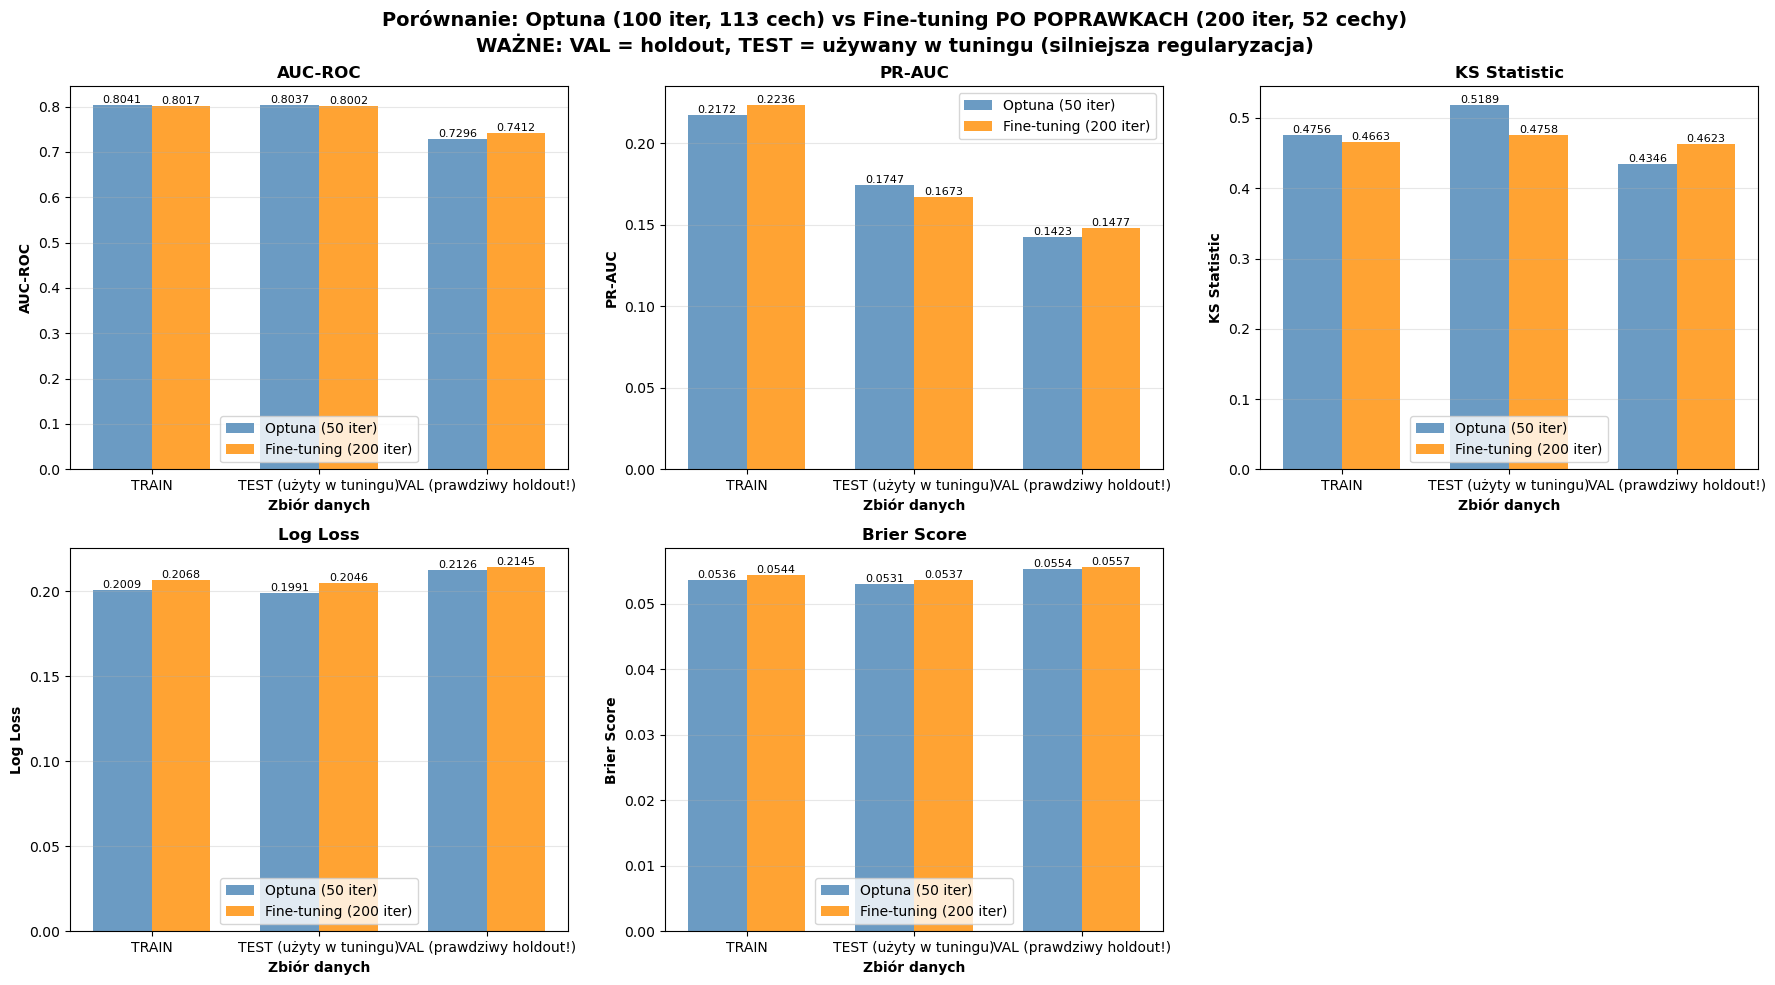

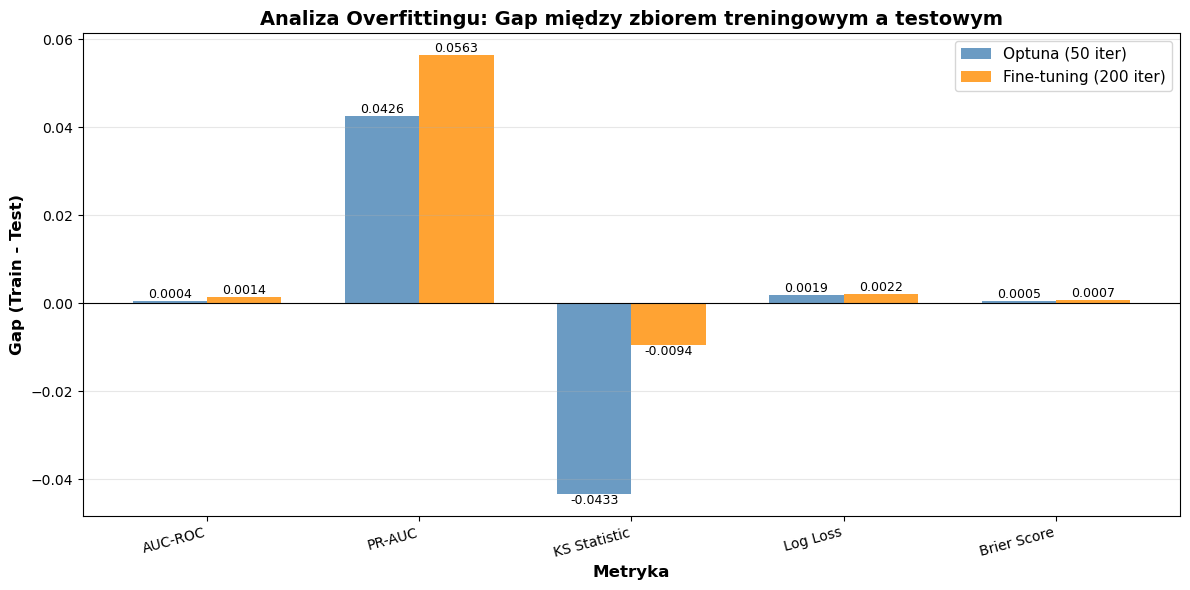

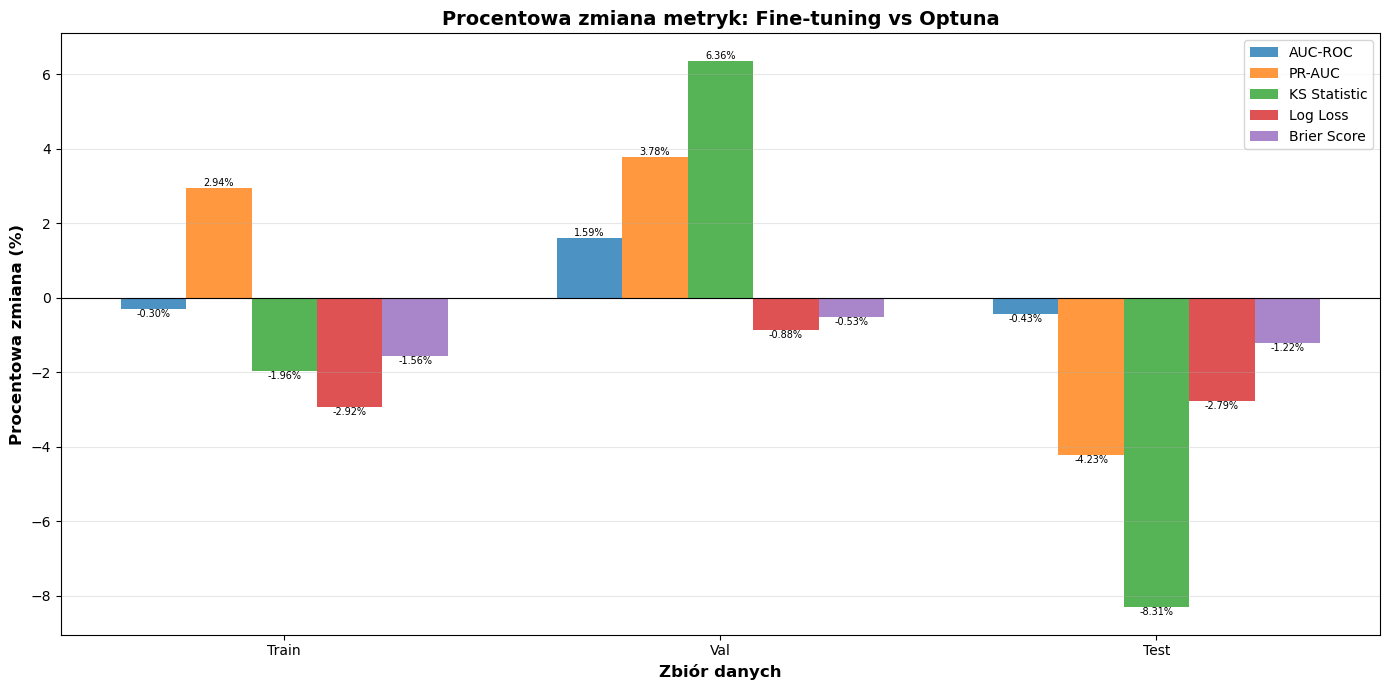


✓ Wszystkie wizualizacje zostały wygenerowane


In [42]:
# Wizualizacja porównań
print("=" * 80)
print("WIZUALIZACJE PORÓWNAWCZE")
print("=" * 80)

# Przygotowanie danych do wykresów
datasets = ['TRAIN', 'TEST (użyty w tuningu)', 'VAL (prawdziwy holdout!)']
metrics_to_plot = ['AUC-ROC', 'PR-AUC', 'KS Statistic', 'Log Loss', 'Brier Score']

results_optuna = [results_xgb_optuna_train, results_xgb_optuna_test, results_xgb_optuna_val]
results_finetuned = [results_xgb_finetuned_train, results_xgb_finetuned_test, results_xgb_finetuned_val]

# Wykres 1: Porównanie metryk na wszystkich zbiorach
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie: Optuna (100 iter, 113 cech) vs Fine-tuning PO POPRAWKACH (200 iter, 52 cechy)\nWAŻNE: VAL = holdout, TEST = używany w tuningu (silniejsza regularyzacja)', 
             fontsize=14, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    optuna_values = [results[metric] for results in results_optuna]
    finetuned_values = [results[metric] for results in results_finetuned]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, optuna_values, width, label='Optuna (50 iter)', alpha=0.8, color='steelblue')
    bars2 = ax.bar(x + width/2, finetuned_values, width, label='Fine-tuning (200 iter)', alpha=0.8, color='darkorange')
    
    ax.set_xlabel('Zbiór danych', fontweight='bold')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(metric, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodanie wartości na słupkach
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=8)

# Usuń ostatni pusty subplot jeśli niepotrzebny
if len(metrics_to_plot) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Wykres 2: Analiza overfittingu (Train-Test gap)
fig, ax = plt.subplots(figsize=(12, 6))

gaps_optuna = []
gaps_finetuned = []

for metric in metrics_to_plot:
    gap_optuna = results_xgb_optuna_train[metric] - results_xgb_optuna_test[metric]
    gap_finetuned = results_xgb_finetuned_train[metric] - results_xgb_finetuned_test[metric]
    gaps_optuna.append(gap_optuna)
    gaps_finetuned.append(gap_finetuned)

x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax.bar(x - width/2, gaps_optuna, width, label='Optuna (50 iter)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, gaps_finetuned, width, label='Fine-tuning (200 iter)', alpha=0.8, color='darkorange')

ax.set_xlabel('Metryka', fontweight='bold', fontsize=12)
ax.set_ylabel('Gap (Train - Test)', fontweight='bold', fontsize=12)
ax.set_title('Analiza Overfittingu: Gap między zbiorem treningowym a testowym', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# Wykres 3: Procentowa zmiana metryk
fig, ax = plt.subplots(figsize=(14, 7))

improvements = {}
for metric in metrics_to_plot:
    improvements[metric] = []
    for dataset_name, results_opt, results_fine in [
        ('Train', results_xgb_optuna_train, results_xgb_finetuned_train),
        ('Val', results_xgb_optuna_val, results_xgb_finetuned_val),
        ('Test', results_xgb_optuna_test, results_xgb_finetuned_test)
    ]:
        opt_val = results_opt[metric]
        fine_val = results_fine[metric]
        
        # Dla Brier Score i Log Loss odwracamy znak (mniejsza wartość = lepiej)
        if metric in ['Brier Score', 'Log Loss']:
            pct_change = -((fine_val - opt_val) / opt_val * 100) if opt_val != 0 else 0
        else:
            pct_change = ((fine_val - opt_val) / opt_val * 100) if opt_val != 0 else 0
        
        improvements[metric].append(pct_change)

x = np.arange(len(['Train', 'Val', 'Test']))
width = 0.15

for idx, metric in enumerate(metrics_to_plot):
    offset = (idx - 2) * width
    bars = ax.bar(x + offset, improvements[metric], width, label=metric, alpha=0.8)
    
    # Dodanie wartości
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom' if height > 0 else 'top', fontsize=7, rotation=0)

ax.set_xlabel('Zbiór danych', fontweight='bold', fontsize=12)
ax.set_ylabel('Procentowa zmiana (%)', fontweight='bold', fontsize=12)
ax.set_title('Procentowa zmiana metryk: Fine-tuning vs Optuna', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Train', 'Val', 'Test'])
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\n✓ Wszystkie wizualizacje zostały wygenerowane")

In [43]:
# Trening modelu z parametrami po fine-tuningu
print("=" * 80)
print("TRENING MODELU Z PARAMETRAMI PO FINE-TUNINGU")
print("=" * 80)

# Model z parametrami z Optuna (50 iteracji)
xgb_optuna = XGBClassifier(**xgb_best_params, random_state=42, enable_categorical=True)
xgb_optuna.fit(X_train_final, y_train)

# Predykcje dla modelu Optuna
y_pred_proba_xgb_optuna_train = xgb_optuna.predict_proba(X_train_final)[:, 1]
y_pred_proba_xgb_optuna_val = xgb_optuna.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb_optuna_test = xgb_optuna.predict_proba(X_test_final)[:, 1]

y_pred_xgb_optuna_train = xgb_optuna.predict(X_train_final)
y_pred_xgb_optuna_val = xgb_optuna.predict(X_val_final)
y_pred_xgb_optuna_test = xgb_optuna.predict(X_test_final)

# Ewaluacja modelu Optuna
results_xgb_optuna_train = evaluate_model(y_train, y_pred_xgb_optuna_train, y_pred_proba_xgb_optuna_train)
results_xgb_optuna_val = evaluate_model(y_val, y_pred_xgb_optuna_val, y_pred_proba_xgb_optuna_val)
results_xgb_optuna_test = evaluate_model(y_test, y_pred_xgb_optuna_test, y_pred_proba_xgb_optuna_test)

# Model z parametrami po fine-tuningu (200 iteracji)
xgb_finetuned = XGBClassifier(**xgb_finetuned_params, random_state=42, enable_categorical=True)
xgb_finetuned.fit(X_train_final, y_train)

# Predykcje dla modelu fine-tuned
y_pred_proba_xgb_finetuned_train = xgb_finetuned.predict_proba(X_train_final)[:, 1]
y_pred_proba_xgb_finetuned_val = xgb_finetuned.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb_finetuned_test = xgb_finetuned.predict_proba(X_test_final)[:, 1]

y_pred_xgb_finetuned_train = xgb_finetuned.predict(X_train_final)
y_pred_xgb_finetuned_val = xgb_finetuned.predict(X_val_final)
y_pred_xgb_finetuned_test = xgb_finetuned.predict(X_test_final)

# Ewaluacja modelu fine-tuned
results_xgb_finetuned_train = evaluate_model(y_train, y_pred_xgb_finetuned_train, y_pred_proba_xgb_finetuned_train)
results_xgb_finetuned_val = evaluate_model(y_val, y_pred_xgb_finetuned_val, y_pred_proba_xgb_finetuned_val)
results_xgb_finetuned_test = evaluate_model(y_test, y_pred_xgb_finetuned_test, y_pred_proba_xgb_finetuned_test)

print("\n✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach")

TRENING MODELU Z PARAMETRAMI PO FINE-TUNINGU

✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach

✓ Modele wytrenowane i zeewaluowane na wszystkich zbiorach


Fine tuning poprawił wyniki dla XGBoost'a, zmniejszył overfitting 

In [44]:
save_best_params(xgb_finetuned_params, 'xgb_finetuned_selected_final')

✓ Zapisano parametry xgb_finetuned_selected_final do: best_params_xgb_finetuned_selected_final_tuned.json


'best_params_xgb_finetuned_selected_final_tuned.json'

# Część 3

##### Szybkie wczytanie optymalnego modelu

In [15]:
xgb_params_loaded = load_best_params('xgb_finetuned_selected_final')
if xgb_params_loaded:
    print("\nXGBoost - najlepsze parametry:")
    for param, value in xgb_params_loaded.items():
        print(f"  {param}: {value}")
    
    print("\n→ Można utworzyć model: XGBClassifier(**xgb_params_loaded)")


✓ Wczytano parametry xgb_finetuned_selected_final z: best_params_xgb_finetuned_selected_final_tuned.json

XGBoost - najlepsze parametry:
  n_estimators: 76
  learning_rate: 0.01461102240915002
  max_depth: 10
  min_child_weight: 14
  subsample: 0.6473280509644594
  colsample_bytree: 0.7315395908657975
  reg_lambda: 2.5969145800346697e-08
  reg_alpha: 0.00035499449586592067

→ Można utworzyć model: XGBClassifier(**xgb_params_loaded)


In [16]:
print("="*80)
print("WCZYTYWANIE DANYCH PO FEATURE SELECTION (dla fine-tuningu)")
print("="*80)

# Wczytaj dane z plików CSV
train_df = pd.read_csv('train_selected.csv')
test_df = pd.read_csv('test_selected.csv')
val_df = pd.read_csv('val_selected.csv')

# Rozdziel cechy i target
X_train_selected = train_df.drop(columns=['default'])
y_train = train_df['default']

X_test_selected = test_df.drop(columns=['default'])
y_test = test_df['default']

X_val_selected = val_df.drop(columns=['default'])
y_val = val_df['default']

print(f"\n✓ Wczytano dane: TRAIN={X_train_selected.shape}, TEST={X_test_selected.shape}, VAL={X_val_selected.shape}")
print("="*80)

WCZYTYWANIE DANYCH PO FEATURE SELECTION (dla fine-tuningu)

✓ Wczytano dane: TRAIN=(1800, 105), TEST=(600, 105), VAL=(600, 105)

✓ Wczytano dane: TRAIN=(1800, 105), TEST=(600, 105), VAL=(600, 105)


In [17]:
xgb_final = XGBClassifier(**xgb_params_loaded, random_state=42, enable_categorical=True)
xgb_final.fit(X_train_selected, y_train)

# Predykcje na zbiorze testowym
y_pred_final = xgb_final.predict(X_test_selected)
y_pred_proba_final = xgb_final.predict_proba(X_test_selected)[:, 1]

results_final = evaluate_model(y_test, y_pred_proba_final, model_name="XGBoost Final")

print("\n" + "=" * 80)
print("WYNIKI MODELU KOŃCOWEGO NA ZBIORZE TESTOWYM")
print("=" * 80)
print(f"AUC-ROC:       {results_final['AUC-ROC']:.4f}")
print(f"PR-AUC:        {results_final['PR-AUC']:.4f}")
print(f"KS Statistic:  {results_final['KS Statistic']:.4f}")
print(f"Log Loss:      {results_final['Log Loss']:.4f}")
print(f"Brier Score:   {results_final['Brier Score']:.4f}")
print("=" * 80)




WYNIKI MODELU KOŃCOWEGO NA ZBIORZE TESTOWYM
AUC-ROC:       0.8002
PR-AUC:        0.1673
KS Statistic:  0.4758
Log Loss:      0.2046
Brier Score:   0.0537


### Analiza najlepszego modelu black box

#### Selekcja skrajnych przypadków ze zbioru walidacyjnego



In [18]:
# Predykcje na zbiorze walidacyjnym
y_pred_proba_val = xgb_final.predict_proba(X_val_selected)[:, 1]
y_pred_val = xgb_final.predict(X_val_selected)

print("="*80)
print("SELEKCJA 6 SKRAJNYCH PRZYPADKÓW ZE ZBIORU WALIDACYJNEGO")
print("="*80)

# 1. Highest predicted default (najwyższe prawdopodobieństwo)
idx_highest = np.argmax(y_pred_proba_val)
print(f"\n1. HIGHEST PREDICTED DEFAULT:")
print(f"   Index: {idx_highest}, Prob: {y_pred_proba_val[idx_highest]:.4f}, True: {y_val.iloc[idx_highest]}")

# 2. Lowest predicted default (najniższe prawdopodobieństwo)
idx_lowest = np.argmin(y_pred_proba_val)
print(f"\n2. LOWEST PREDICTED DEFAULT:")
print(f"   Index: {idx_lowest}, Prob: {y_pred_proba_val[idx_lowest]:.4f}, True: {y_val.iloc[idx_lowest]}")

# 3. True Positive (high confidence) - prawidłowo wykryty default z wysokim prawdopodobieństwem
tp_mask = (y_pred_val == 1) & (y_val.values == 1)
if tp_mask.sum() > 0:
    tp_probs = y_pred_proba_val[tp_mask]
    tp_indices = np.where(tp_mask)[0]
    idx_tp = tp_indices[np.argmax(tp_probs)]
    print(f"\n3. TRUE POSITIVE (HIGH CONFIDENCE):")
    print(f"   Index: {idx_tp}, Prob: {y_pred_proba_val[idx_tp]:.4f}, True: {y_val.iloc[idx_tp]}, Pred: 1")
else:
    # Jeśli nie ma TP, wybierz najwyższe prob wśród y=1
    mask_default = y_val.values == 1
    idx_tp = np.where(mask_default)[0][np.argmax(y_pred_proba_val[mask_default])]
    print(f"\n3. HIGHEST PROB AMONG DEFAULTS (closest to TP):")
    print(f"   Index: {idx_tp}, Prob: {y_pred_proba_val[idx_tp]:.4f}, True: {y_val.iloc[idx_tp]}")

# 4. False Positive (high confidence) - błędnie sklasyfikowany jako default
fp_mask = (y_pred_val == 1) & (y_val.values == 0)
if fp_mask.sum() > 0:
    fp_probs = y_pred_proba_val[fp_mask]
    fp_indices = np.where(fp_mask)[0]
    idx_fp = fp_indices[np.argmax(fp_probs)]
    print(f"\n4. FALSE POSITIVE (HIGH CONFIDENCE):")
    print(f"   Index: {idx_fp}, Prob: {y_pred_proba_val[idx_fp]:.4f}, True: {y_val.iloc[idx_fp]}, Pred: 1")
else:
    # Jeśli nie ma FP, wybierz najwyższe prob wśród y=0
    mask_no_default = y_val.values == 0
    idx_fp = np.where(mask_no_default)[0][np.argmax(y_pred_proba_val[mask_no_default])]
    print(f"\n4. HIGHEST PROB AMONG NON-DEFAULTS (closest to FP):")
    print(f"   Index: {idx_fp}, Prob: {y_pred_proba_val[idx_fp]:.4f}, True: {y_val.iloc[idx_fp]}")

# 5. False Negative (high confidence) - pominięty default
fn_mask = (y_pred_val == 0) & (y_val.values == 1)
if fn_mask.sum() > 0:
    fn_probs = y_pred_proba_val[fn_mask]
    fn_indices = np.where(fn_mask)[0]
    idx_fn = fn_indices[np.argmin(fn_probs)]
    print(f"\n5. FALSE NEGATIVE (HIGH CONFIDENCE):")
    print(f"   Index: {idx_fn}, Prob: {y_pred_proba_val[idx_fn]:.4f}, True: {y_val.iloc[idx_fn]}, Pred: 0")
else:
    mask_default = y_val.values == 1
    idx_fn = np.where(mask_default)[0][np.argmin(y_pred_proba_val[mask_default])]
    print(f"\n5. LOWEST PROB AMONG DEFAULTS (closest to FN):")
    print(f"   Index: {idx_fn}, Prob: {y_pred_proba_val[idx_fn]:.4f}, True: {y_val.iloc[idx_fn]}")

# 6. Close to decision boundary (najbliżej 0.5)
boundary_distances = np.abs(y_pred_proba_val - 0.5)
idx_boundary = np.argmin(boundary_distances)
print(f"\n6. CLOSEST TO DECISION BOUNDARY:")
print(f"   Index: {idx_boundary}, Prob: {y_pred_proba_val[idx_boundary]:.4f}, True: {y_val.iloc[idx_boundary]}")

# Zapisz indeksy dla dalszej analizy
extreme_indices = [idx_highest, idx_lowest, idx_tp, idx_fp, idx_fn, idx_boundary]
extreme_labels = [
    "Highest Prob", 
    "Lowest Prob",
    "True Positive" if tp_mask.sum() > 0 else "High Prob (y=1)",
    "False Positive" if fp_mask.sum() > 0 else "High Prob (y=0)",
    "False Negative" if fn_mask.sum() > 0 else "Low Prob (y=1)",
    "Boundary Case"
]

SELEKCJA 6 SKRAJNYCH PRZYPADKÓW ZE ZBIORU WALIDACYJNEGO

1. HIGHEST PREDICTED DEFAULT:
   Index: 465, Prob: 0.1560, True: 0

2. LOWEST PREDICTED DEFAULT:
   Index: 367, Prob: 0.0258, True: 0

3. HIGHEST PROB AMONG DEFAULTS (closest to TP):
   Index: 442, Prob: 0.1372, True: 1

4. HIGHEST PROB AMONG NON-DEFAULTS (closest to FP):
   Index: 465, Prob: 0.1560, True: 0

5. FALSE NEGATIVE (HIGH CONFIDENCE):
   Index: 572, Prob: 0.0298, True: 1, Pred: 0

6. CLOSEST TO DECISION BOUNDARY:
   Index: 465, Prob: 0.1560, True: 0


#### Lokalna analiza Shap

In [ ]:
explainer = shap.TreeExplainer(xgb_final)
X_extreme_cases = X_val_selected.iloc[extreme_indices]
shap_values_extreme = explainer.shap_values(X_extreme_cases)


1. Highest Prob (Index: 465)
   Prawdopodobieństwo: 0.1560
   Prawdziwa wartość: 0
   Predykcja: 0


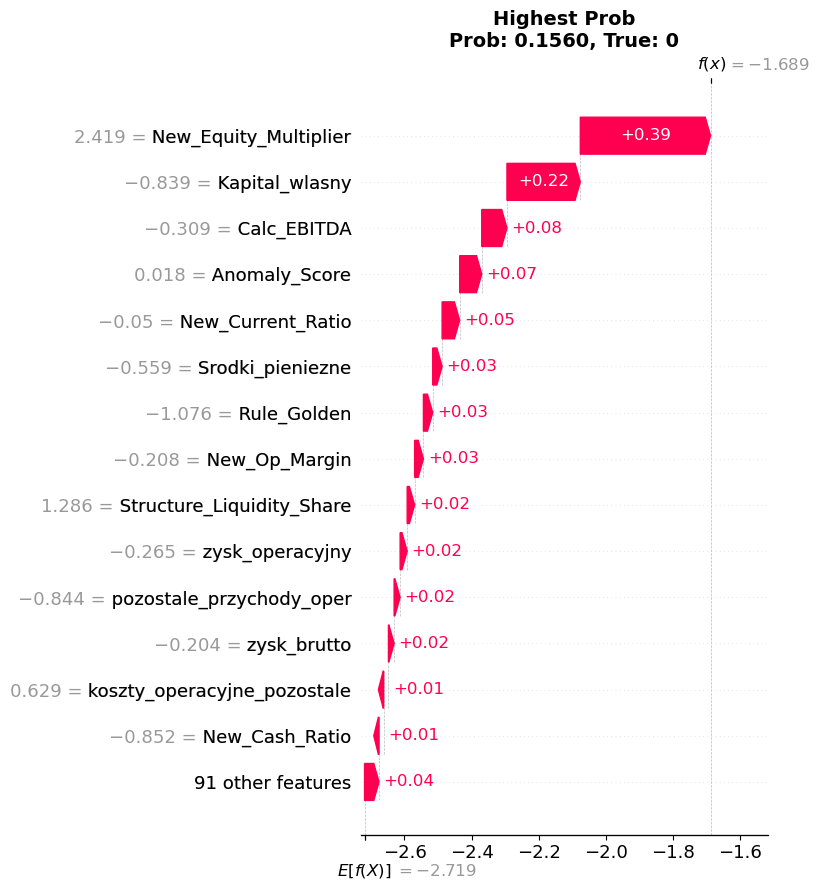


2. Lowest Prob (Index: 367)
   Prawdopodobieństwo: 0.0258
   Prawdziwa wartość: 0
   Predykcja: 0


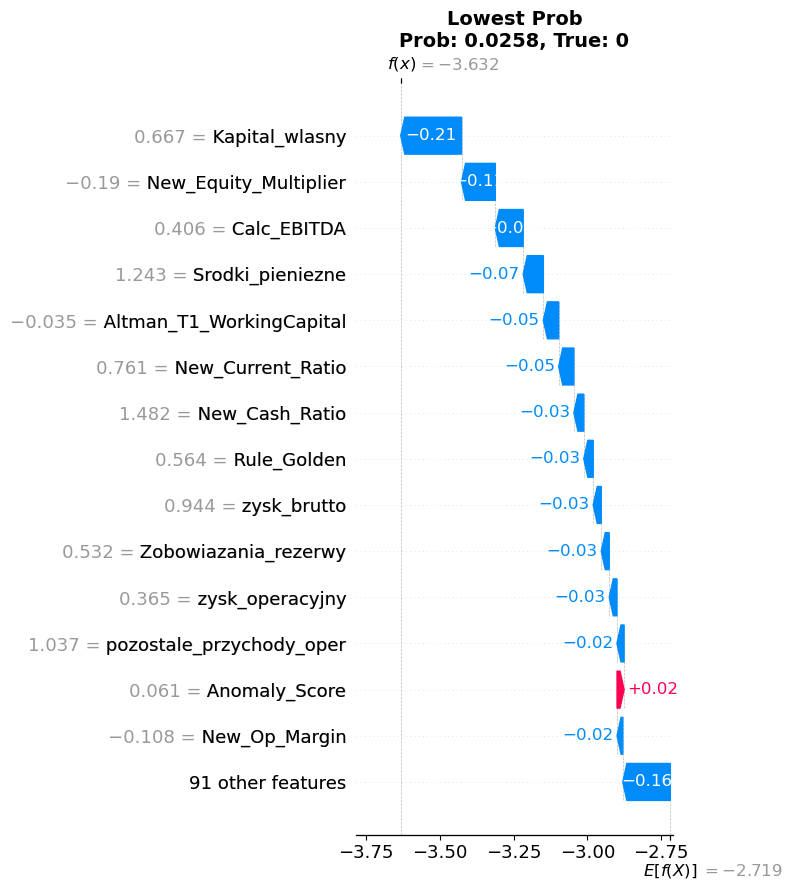


3. High Prob (y=1) (Index: 442)
   Prawdopodobieństwo: 0.1372
   Prawdziwa wartość: 1
   Predykcja: 0


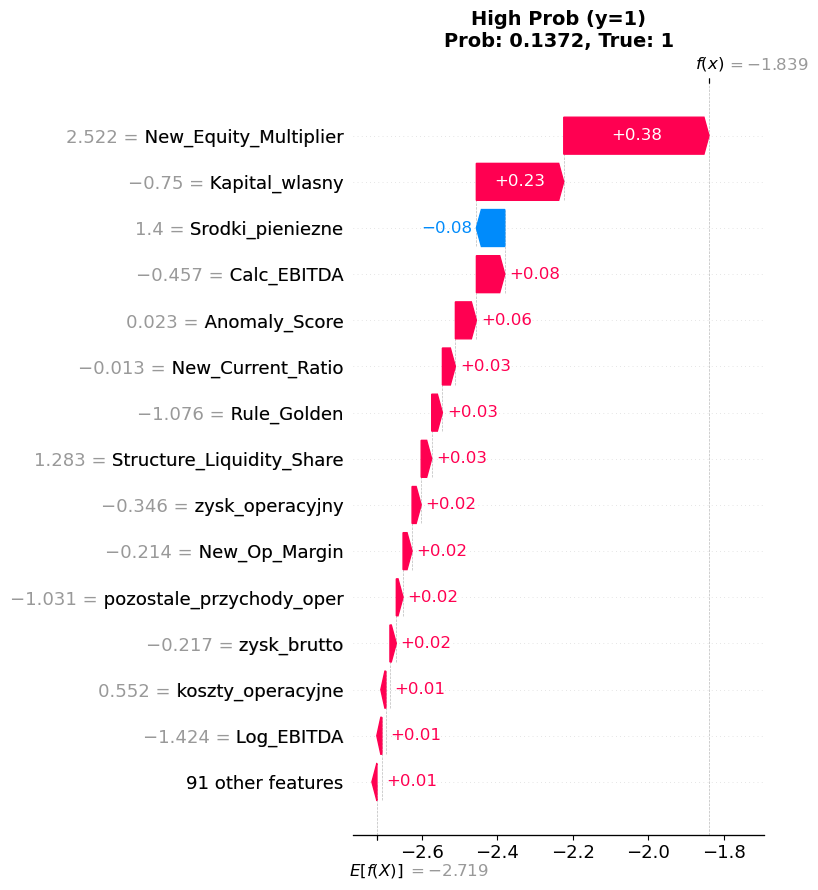


4. High Prob (y=0) (Index: 465)
   Prawdopodobieństwo: 0.1560
   Prawdziwa wartość: 0
   Predykcja: 0


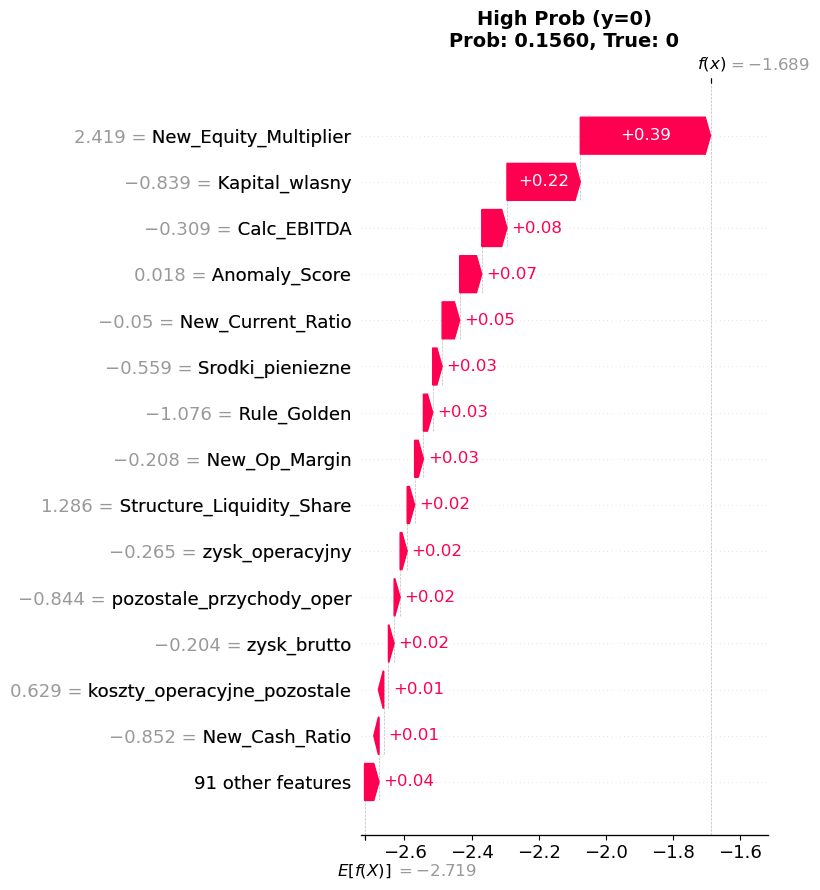


5. False Negative (Index: 572)
   Prawdopodobieństwo: 0.0298
   Prawdziwa wartość: 1
   Predykcja: 0


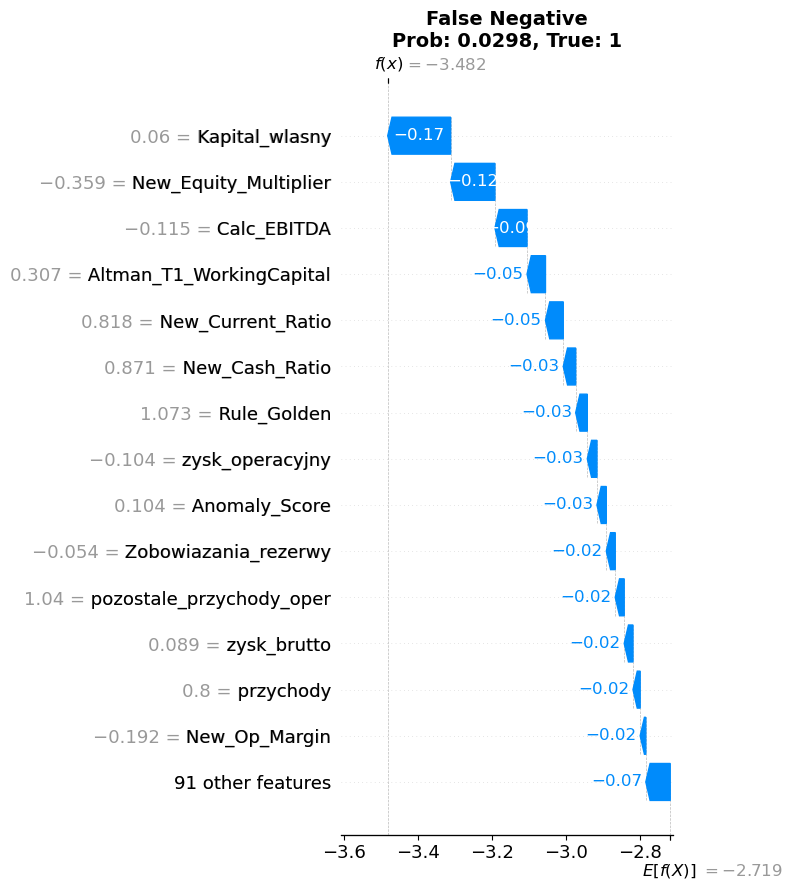


6. Boundary Case (Index: 465)
   Prawdopodobieństwo: 0.1560
   Prawdziwa wartość: 0
   Predykcja: 0


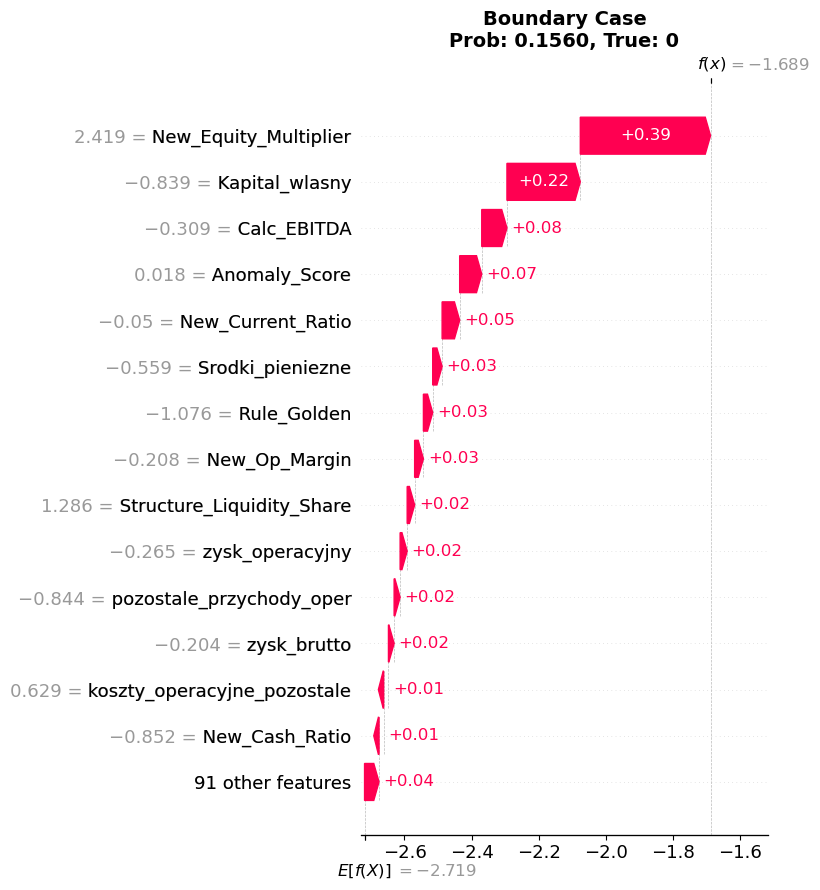

In [20]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label} (Index: {idx})")
    print(f"   Prawdopodobieństwo: {y_pred_proba_val[idx]:.4f}")
    print(f"   Prawdziwa wartość: {y_val.iloc[idx]}")
    print(f"   Predykcja: {y_pred_val[idx]}")
    
    # Waterfall plot dla pojedynczego przypadku
    fig, ax = plt.subplots(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_extreme[i],
            base_values=explainer.expected_value,
            data=X_extreme_cases.iloc[i].values,
            feature_names=X_extreme_cases.columns.tolist()
        ),
        max_display=15,
        show=False
    )
    plt.title(f"{label}\nProb: {y_pred_proba_val[idx]:.4f}, True: {y_val.iloc[idx]}", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


1. Highest Prob


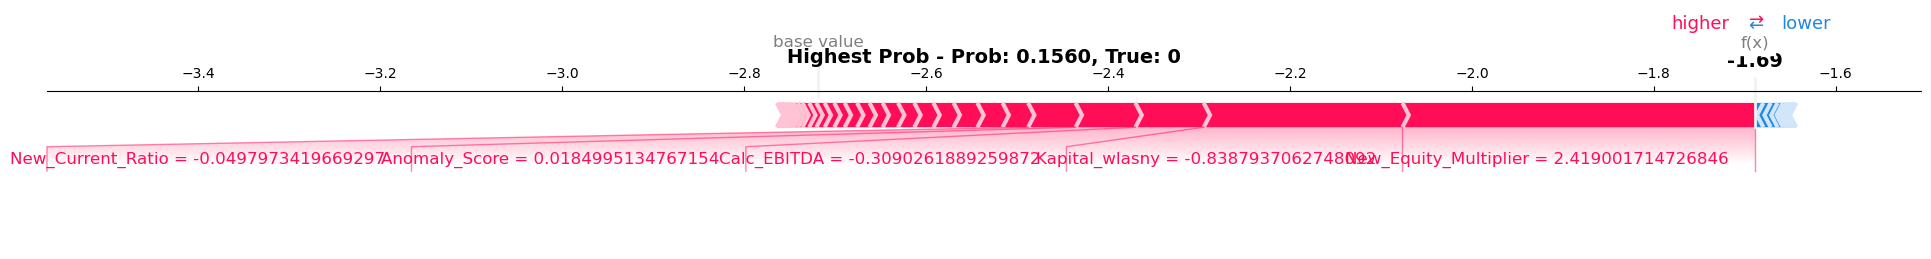


2. Lowest Prob


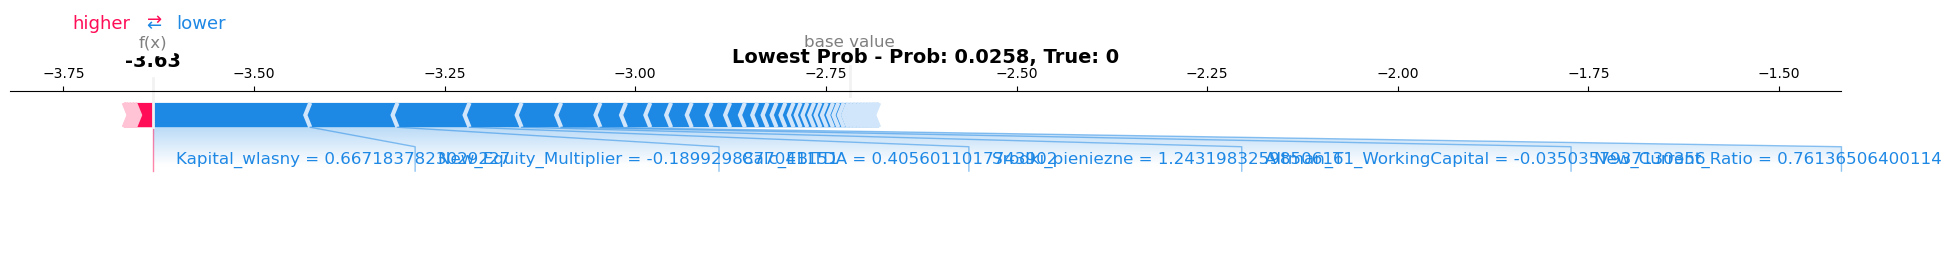


3. High Prob (y=1)


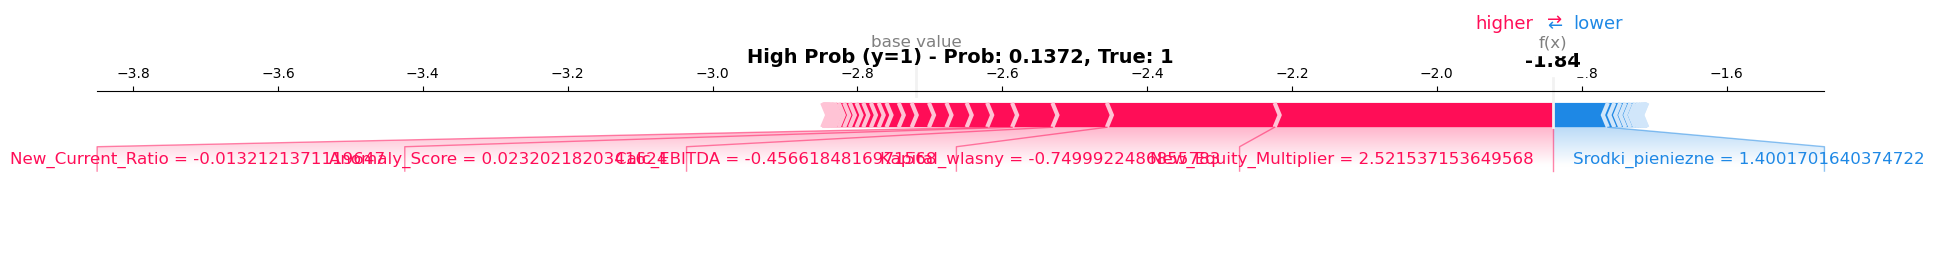


4. High Prob (y=0)


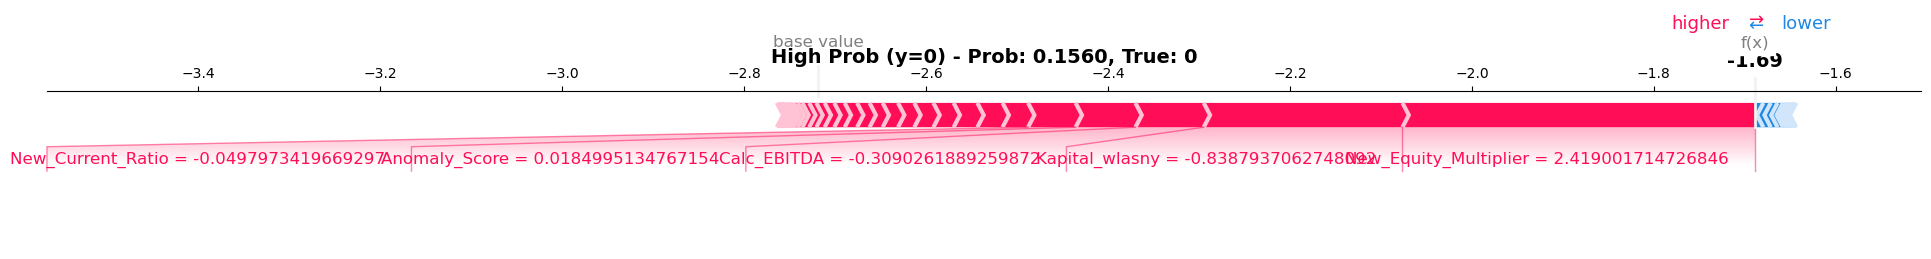


5. False Negative


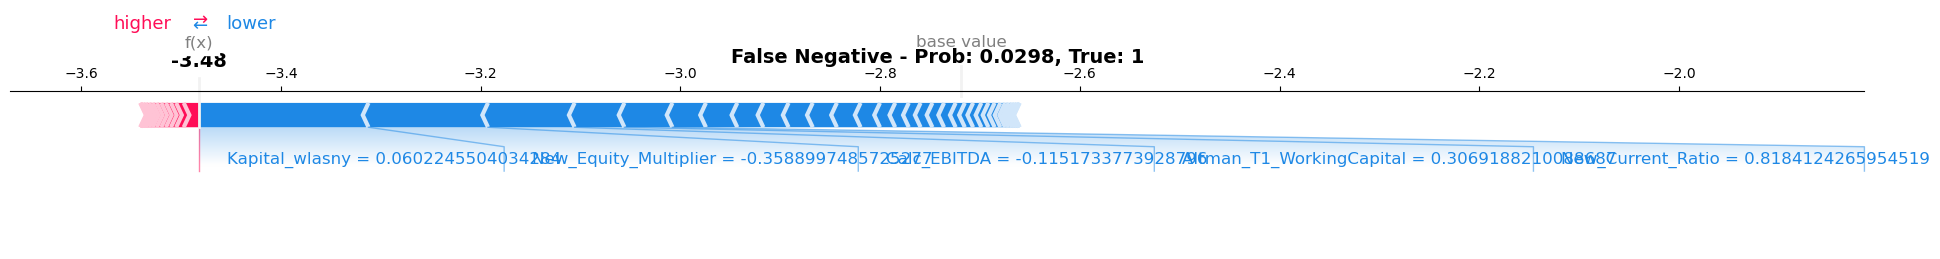


6. Boundary Case


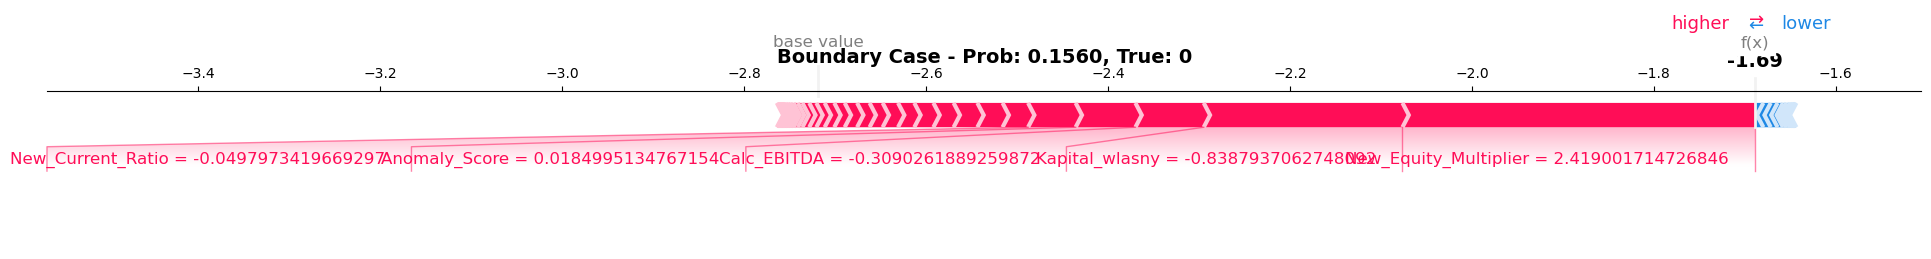

In [21]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label}")
    shap.force_plot(
        explainer.expected_value,
        shap_values_extreme[i],
        X_extreme_cases.iloc[i],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.title(f"{label} - Prob: {y_pred_proba_val[idx]:.4f}, True: {y_val.iloc[idx]}", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


1. Highest Prob (Index: 465)


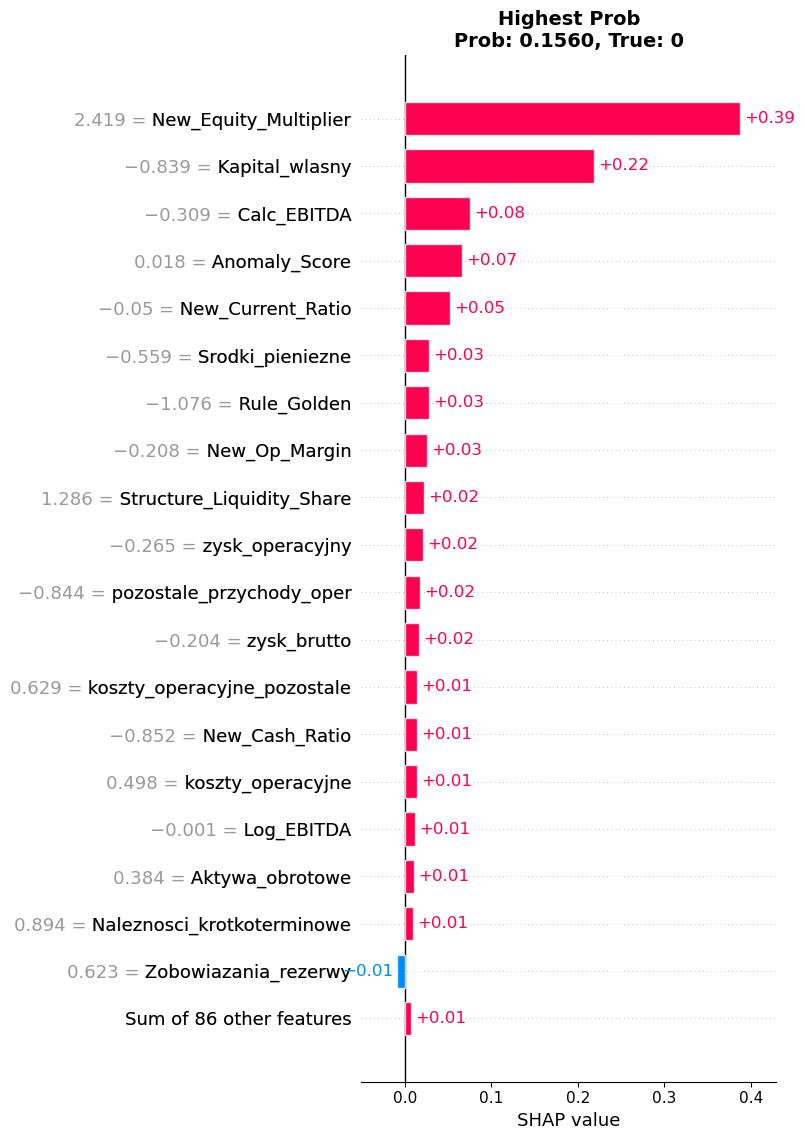


2. Lowest Prob (Index: 367)


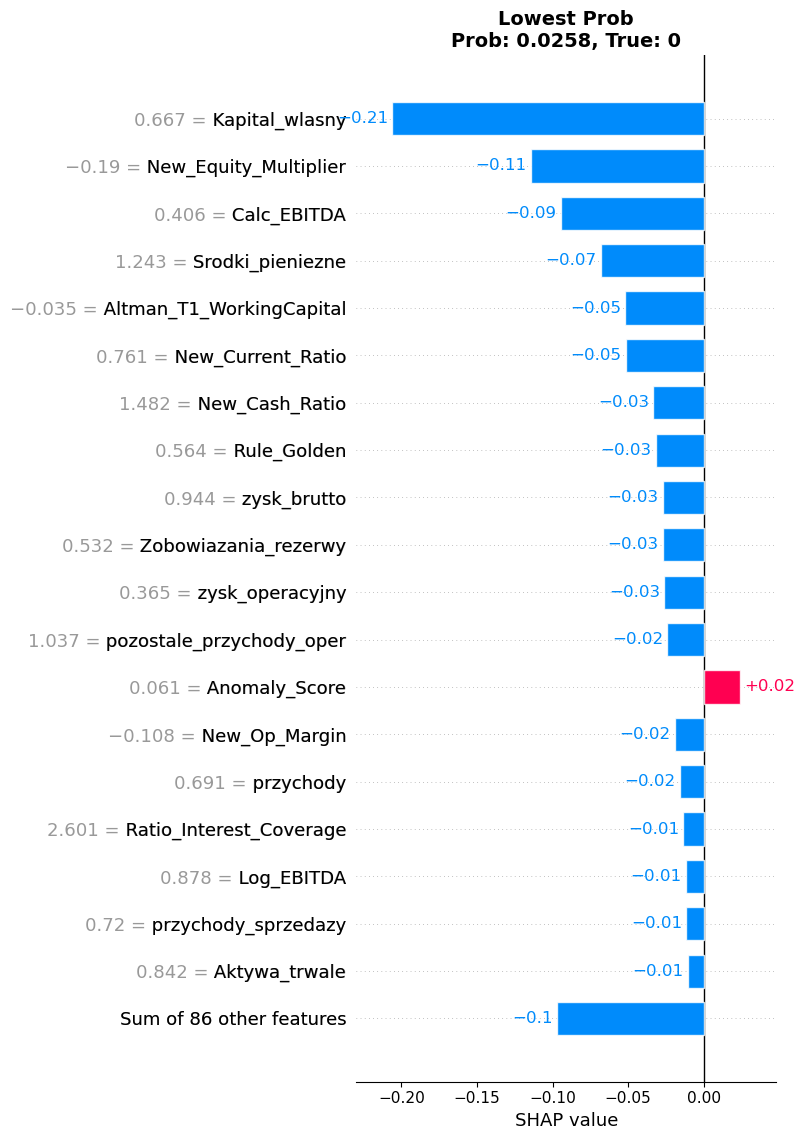


3. High Prob (y=1) (Index: 442)


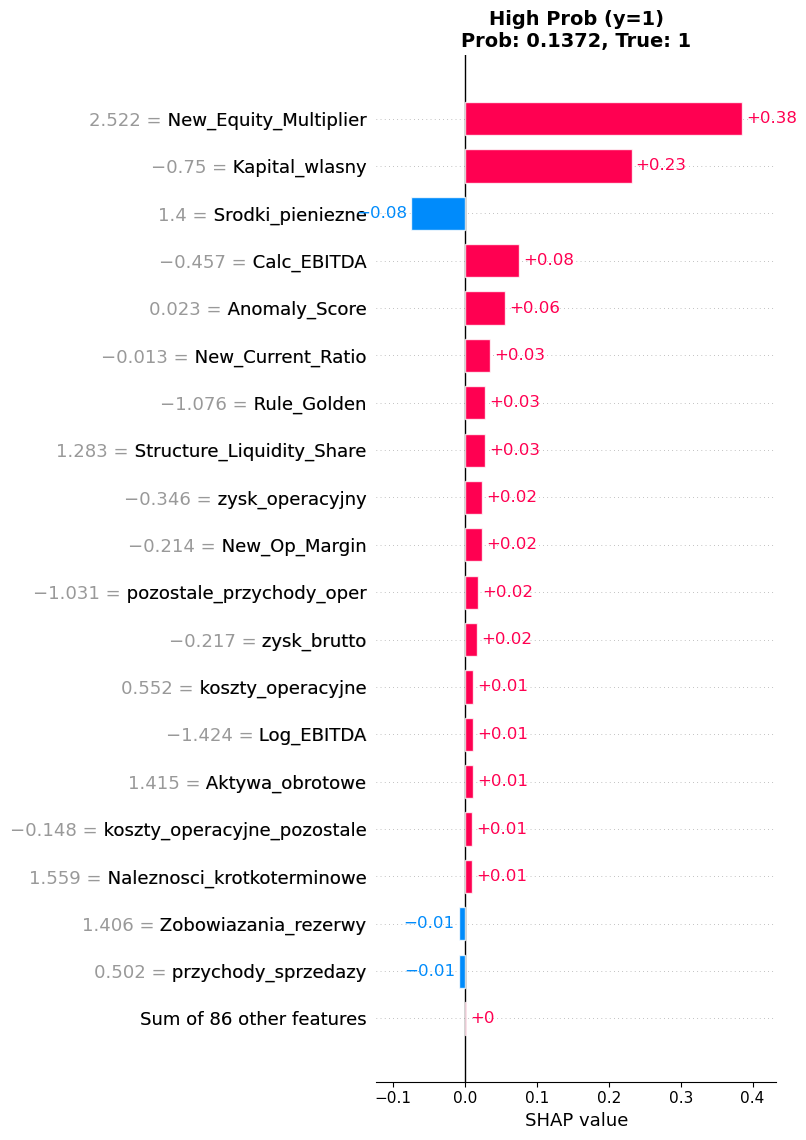


4. High Prob (y=0) (Index: 465)


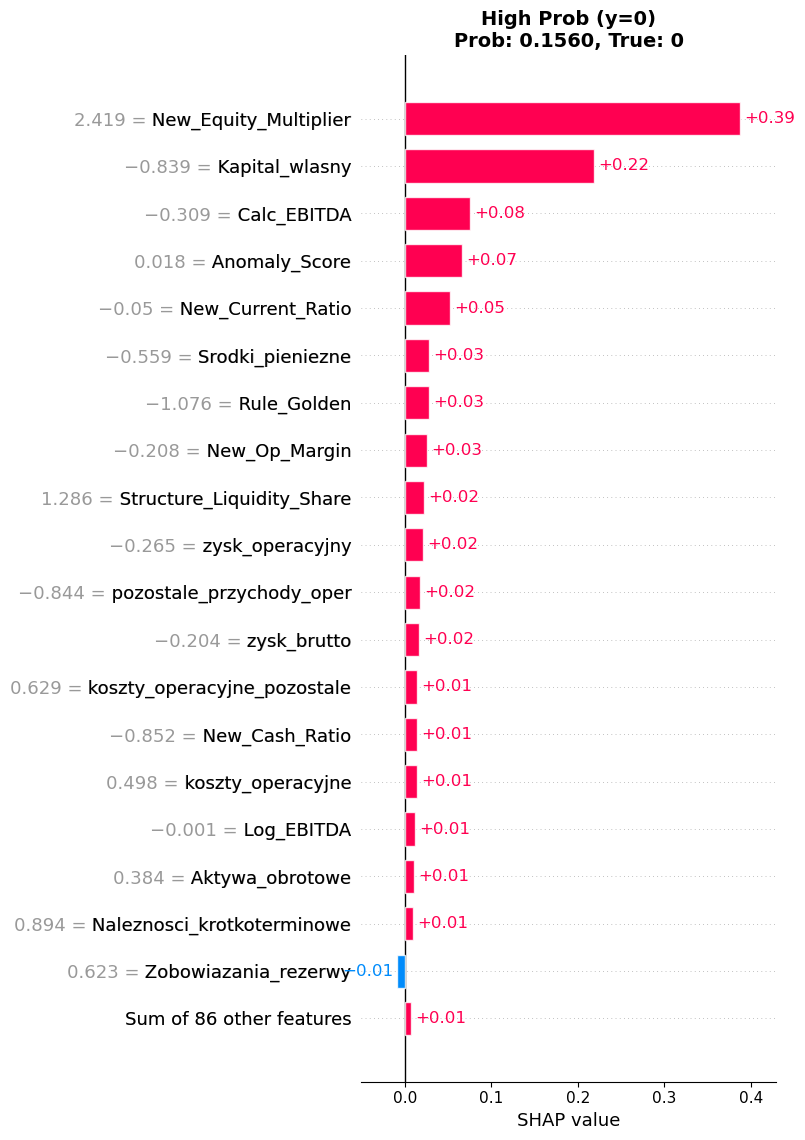


5. False Negative (Index: 572)


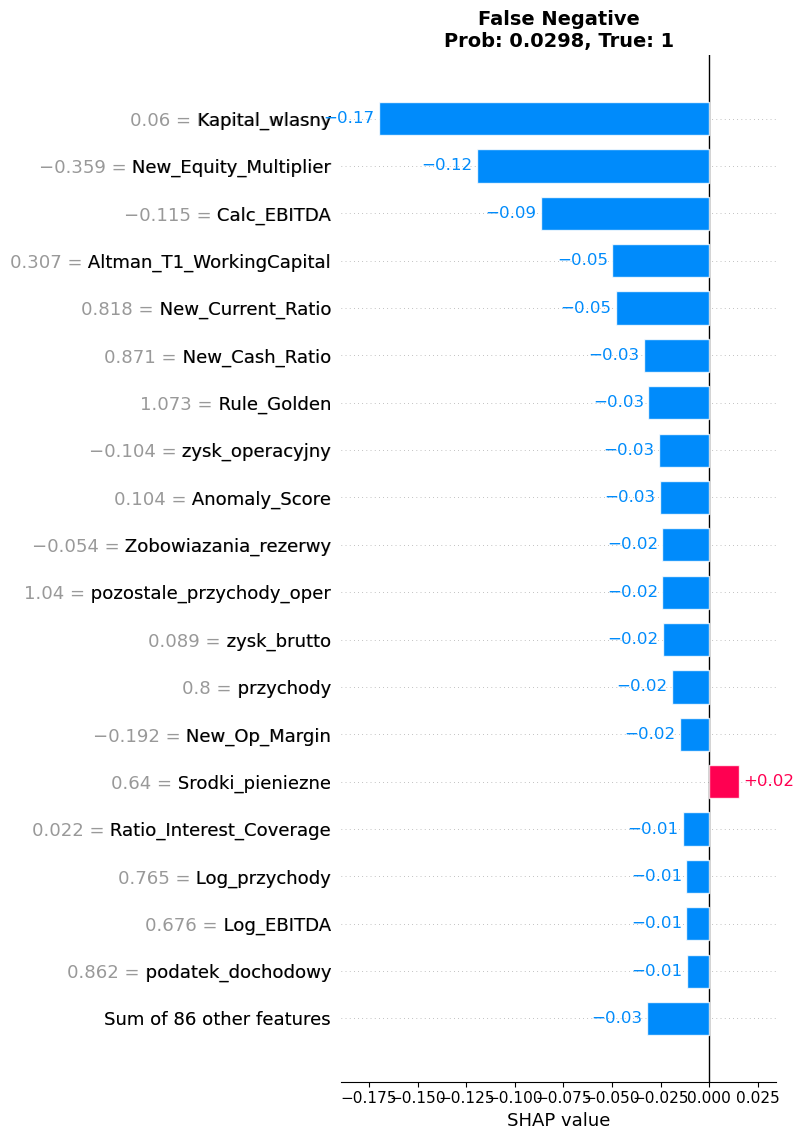


6. Boundary Case (Index: 465)


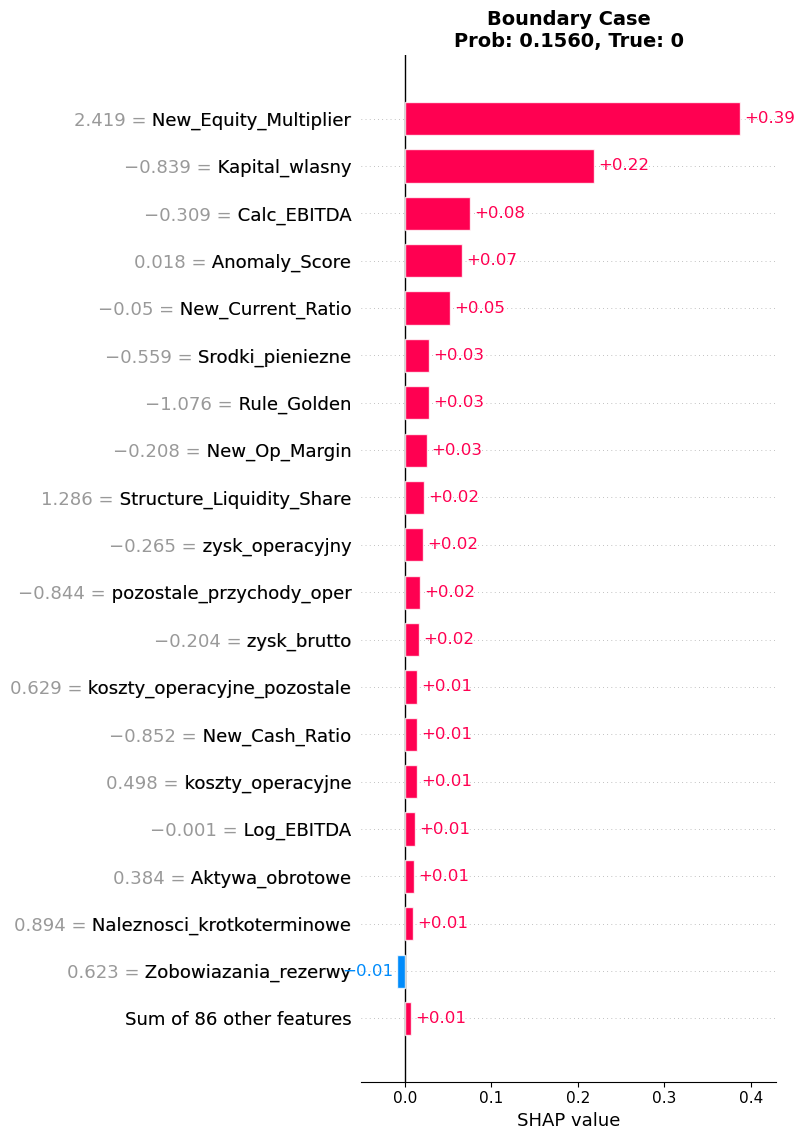

In [22]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label} (Index: {idx})")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    shap_exp = shap.Explanation(
        values=shap_values_extreme[i],
        base_values=explainer.expected_value,
        data=X_extreme_cases.iloc[i].values,
        feature_names=X_extreme_cases.columns.tolist()
    )
    
    shap.plots.bar(shap_exp, max_display=20, show=False)
    plt.title(f"{label}\nProb: {y_pred_proba_val[idx]:.4f}, True: {y_val.iloc[idx]}", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

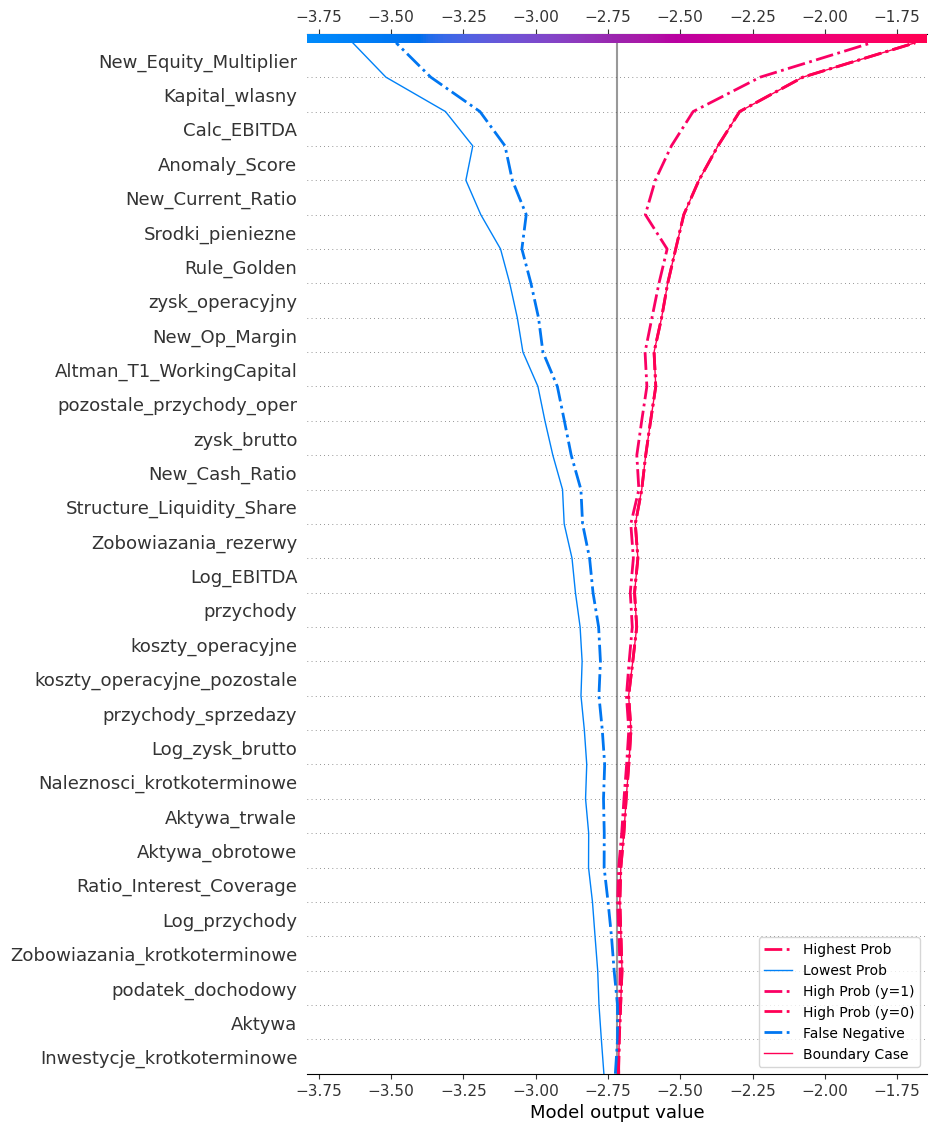

In [23]:

fig = plt.figure(figsize=(18, 12))
shap.decision_plot(
    explainer.expected_value,
    shap_values_extreme,
    X_extreme_cases,
    feature_names=X_extreme_cases.columns.tolist(),
    legend_labels=extreme_labels,
    legend_location='lower right',
    highlight=[0, 2, 3, 4],
    feature_display_range=slice(-1, -31, -1) 
)

plt.show()


#### Globalna analiza modelu

In [24]:
# Oblicz wartości SHAP dla całego zbioru walidacyjnego
print("="*80)
print("GLOBALNA ANALIZA SHAP - CAŁY ZBIÓR WALIDACYJNY")
print("="*80)

print(f"\nObliczanie wartości SHAP dla {len(X_val_selected)} obserwacji...")
shap_values_raw = explainer.shap_values(X_val_selected)

# Dla klasyfikacji binarnej, wybierz wartości dla klasy pozytywnej (default=1)
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]  # Klasa pozytywna
    print(f"✓ Wybrano wartości SHAP dla klasy pozytywnej (default=1)")
else:
    shap_values = shap_values_raw

# Sprawdź i ustaw expected_value
if isinstance(explainer.expected_value, list):
    expected_value = explainer.expected_value[1]  # Dla klasy pozytywnej
else:
    expected_value = explainer.expected_value

print(f"✓ Obliczono wartości SHAP dla {len(X_val_selected)} obserwacji")
print(f"  Kształt shap_values: {shap_values.shape}")
print(f"  Expected value: {expected_value:.4f}")
print("="*80)

GLOBALNA ANALIZA SHAP - CAŁY ZBIÓR WALIDACYJNY

Obliczanie wartości SHAP dla 600 obserwacji...
✓ Obliczono wartości SHAP dla 600 obserwacji
  Kształt shap_values: (600, 105)
  Expected value: -2.7189


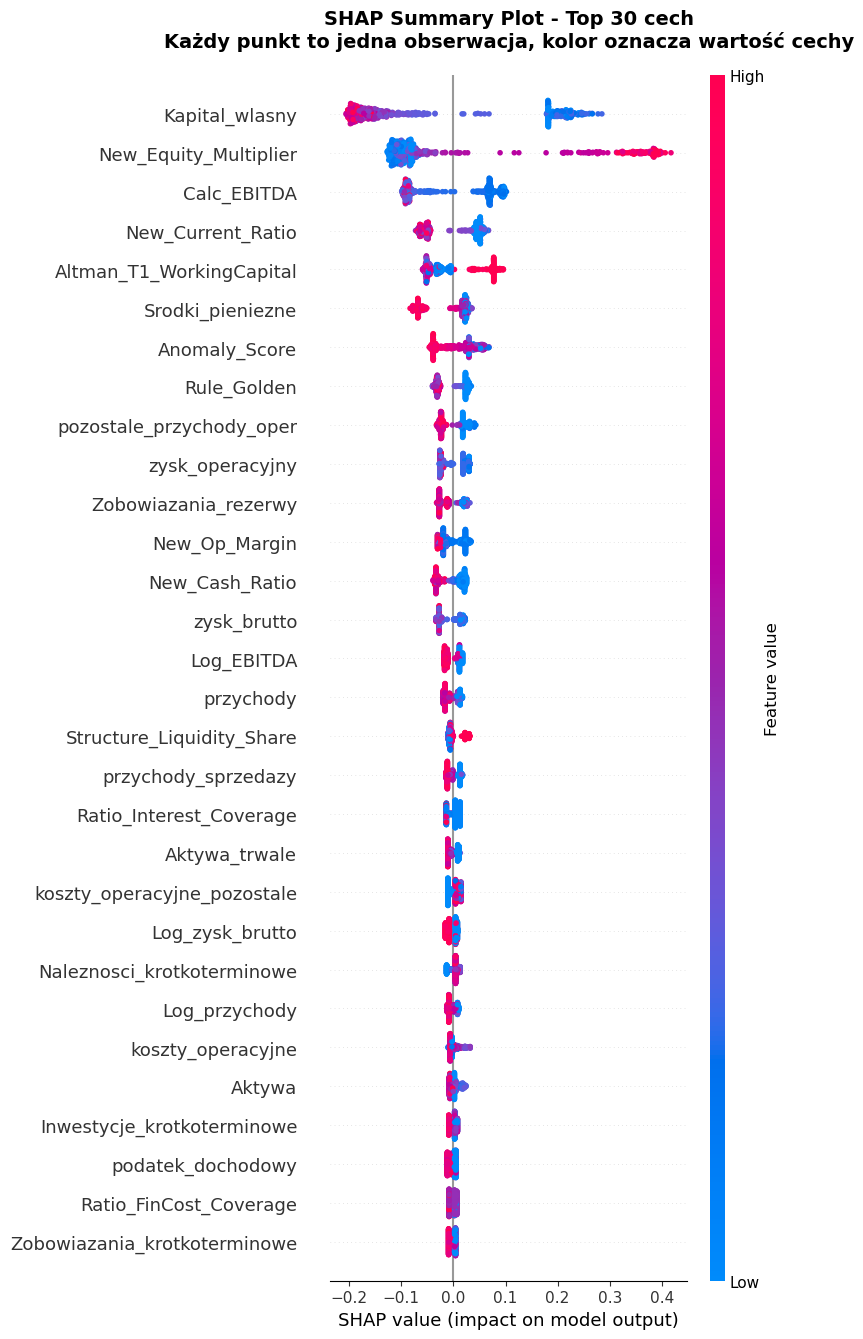


✓ Summary plot pokazuje rozkład wartości SHAP dla wszystkich cech


In [25]:

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_val_selected, show=False, max_display=30)
plt.title("SHAP Summary Plot - Top 30 cech\nKażdy punkt to jedna obserwacja, kolor oznacza wartość cechy", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot_global.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Summary plot pokazuje rozkład wartości SHAP dla wszystkich cech")
print("="*80)


SHAP BAR PLOT - Średni wpływ cech (globalnie)


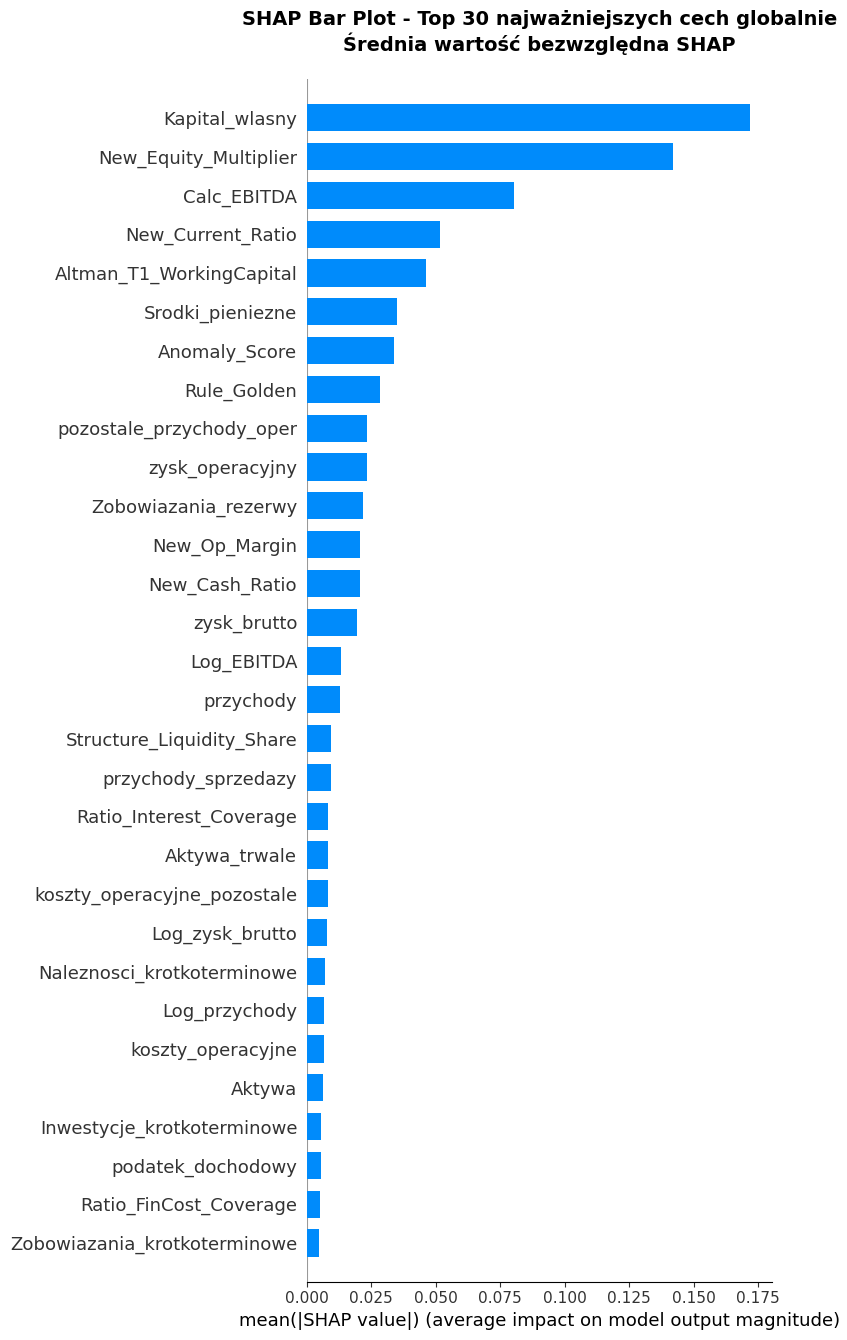


✓ Bar plot pokazuje średnią ważność cech w całym modelu


In [26]:
# 2. Bar Plot - średnie wartości SHAP dla cech
print("\n" + "="*80)
print("SHAP BAR PLOT - Średni wpływ cech (globalnie)")
print("="*80)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_val_selected, plot_type="bar", show=False, max_display=30)
plt.title("SHAP Bar Plot - Top 30 najważniejszych cech globalnie\nŚrednia wartość bezwzględna SHAP", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot_global.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Bar plot pokazuje średnią ważność cech w całym modelu")
print("="*80)


SHAP BEESWARM PLOT - Szczegółowy rozkład wpływu cech


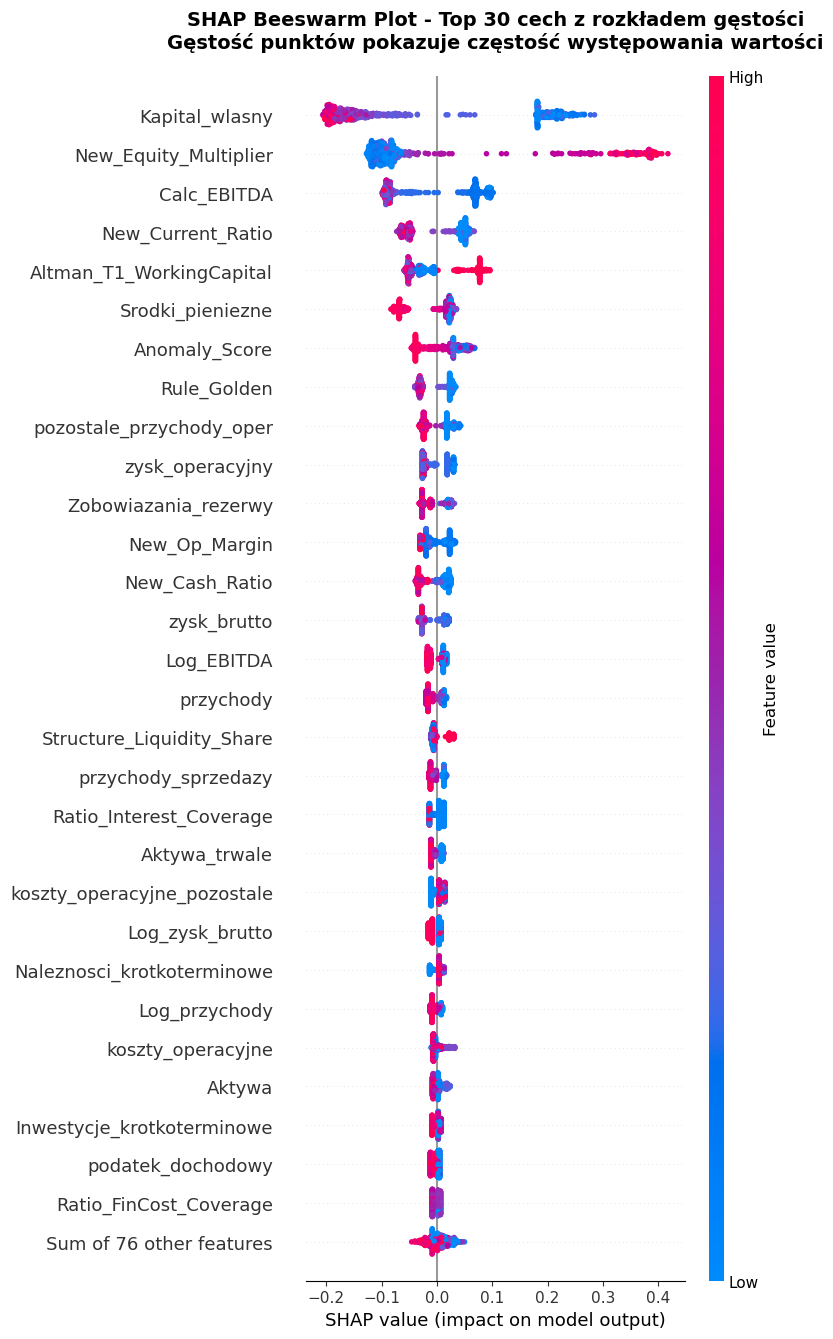


✓ Beeswarm plot pokazuje rozkład gęstości wartości SHAP


In [27]:
print("\n" + "="*80)
print("SHAP BEESWARM PLOT - Szczegółowy rozkład wpływu cech")
print("="*80)

# Ustaw expected_value
exp_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value

plt.figure(figsize=(14, 10))
shap.plots.beeswarm(shap.Explanation(values=shap_values,
                                     base_values=exp_val,
                                     data=X_val_selected.values,
                                     feature_names=X_val_selected.columns.tolist()),
                    max_display=30,
                    show=False)
plt.title("SHAP Beeswarm Plot - Top 30 cech z rozkładem gęstości\nGęstość punktów pokazuje częstość występowania wartości", 

          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

plt.savefig('shap_beeswarm_plot_global.png', dpi=300, bbox_inches='tight')
print("="*80)


plt.show()
print("\n✓ Beeswarm plot pokazuje rozkład gęstości wartości SHAP")


SHAP DEPENDENCE PLOTS - Interakcje między cechami


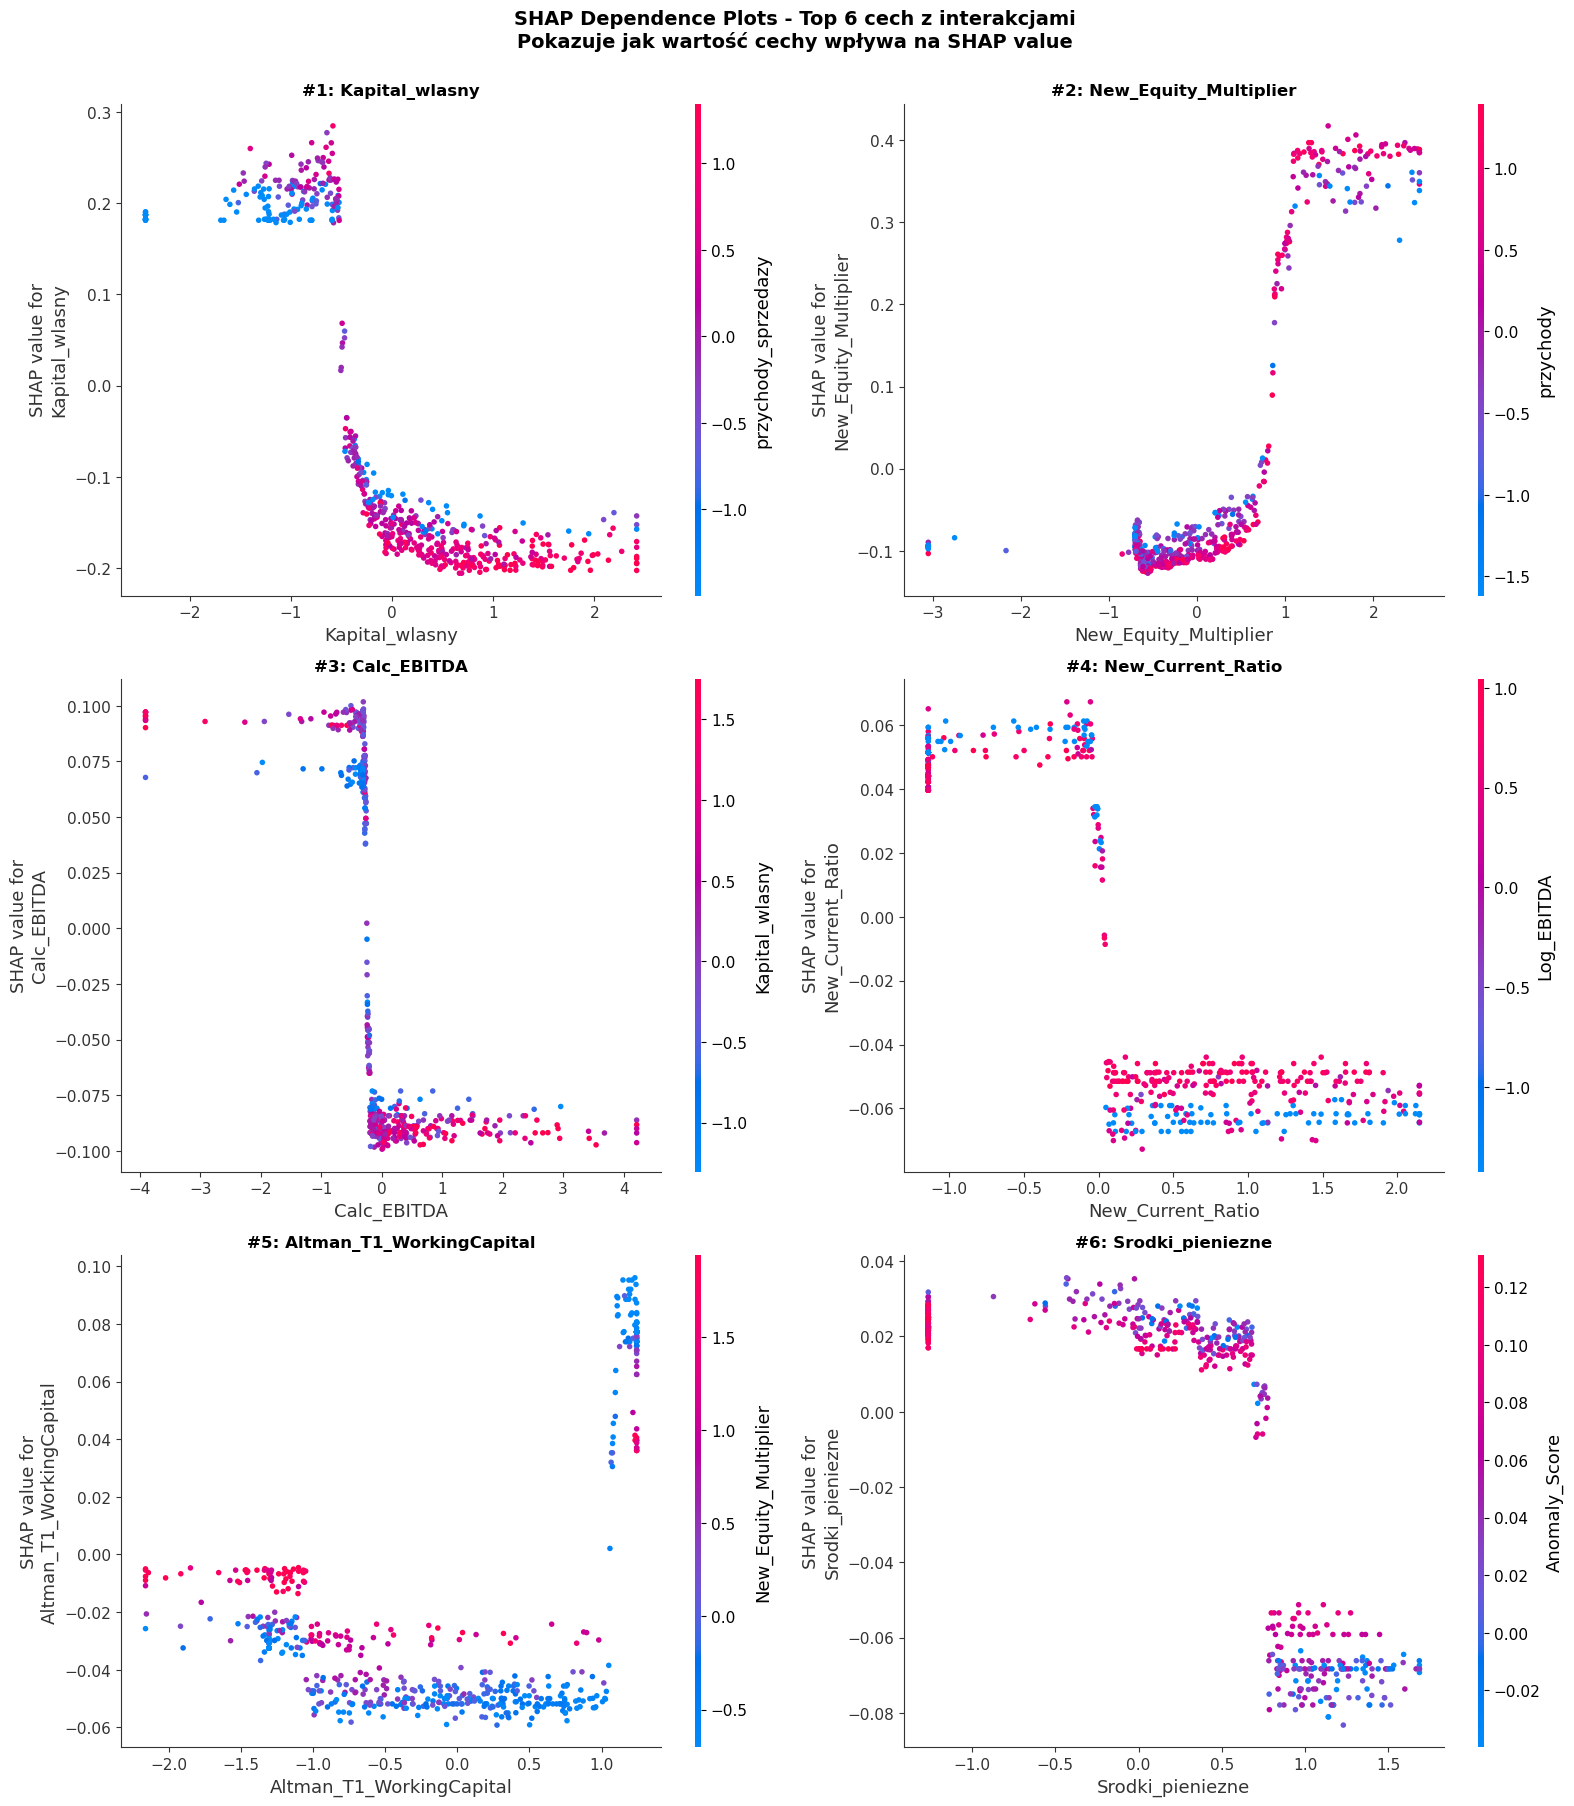


✓ Dependence plots pokazują nieliniowe zależności i interakcje między cechami


In [28]:
# 5. Dependence Plots - zależności między cechami
print("\n" + "="*80)
print("SHAP DEPENDENCE PLOTS - Interakcje między cechami")
print("="*80)

# Oblicz średnią bezwzględną wartość SHAP dla każdej cechy
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Wybierz top 6 cech do analizy zależności
top_6_features_idx = np.argsort(mean_abs_shap)[-6:][::-1]

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, feat_idx in enumerate(top_6_features_idx):
    ax = axes[i]
    feature_name = X_val_selected.columns[feat_idx]
    
    shap.dependence_plot(
        feat_idx,
        shap_values,
        X_val_selected,
        interaction_index="auto",
        ax=ax,
        show=False
    )
    ax.set_title(f"#{i+1}: {feature_name}", fontsize=12, fontweight='bold')

plt.suptitle("SHAP Dependence Plots - Top 6 cech z interakcjami\nPokazuje jak wartość cechy wpływa na SHAP value", 
            fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.savefig('shap_dependence_plots_global.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Dependence plots pokazują nieliniowe zależności i interakcje między cechami")
print("="*80)

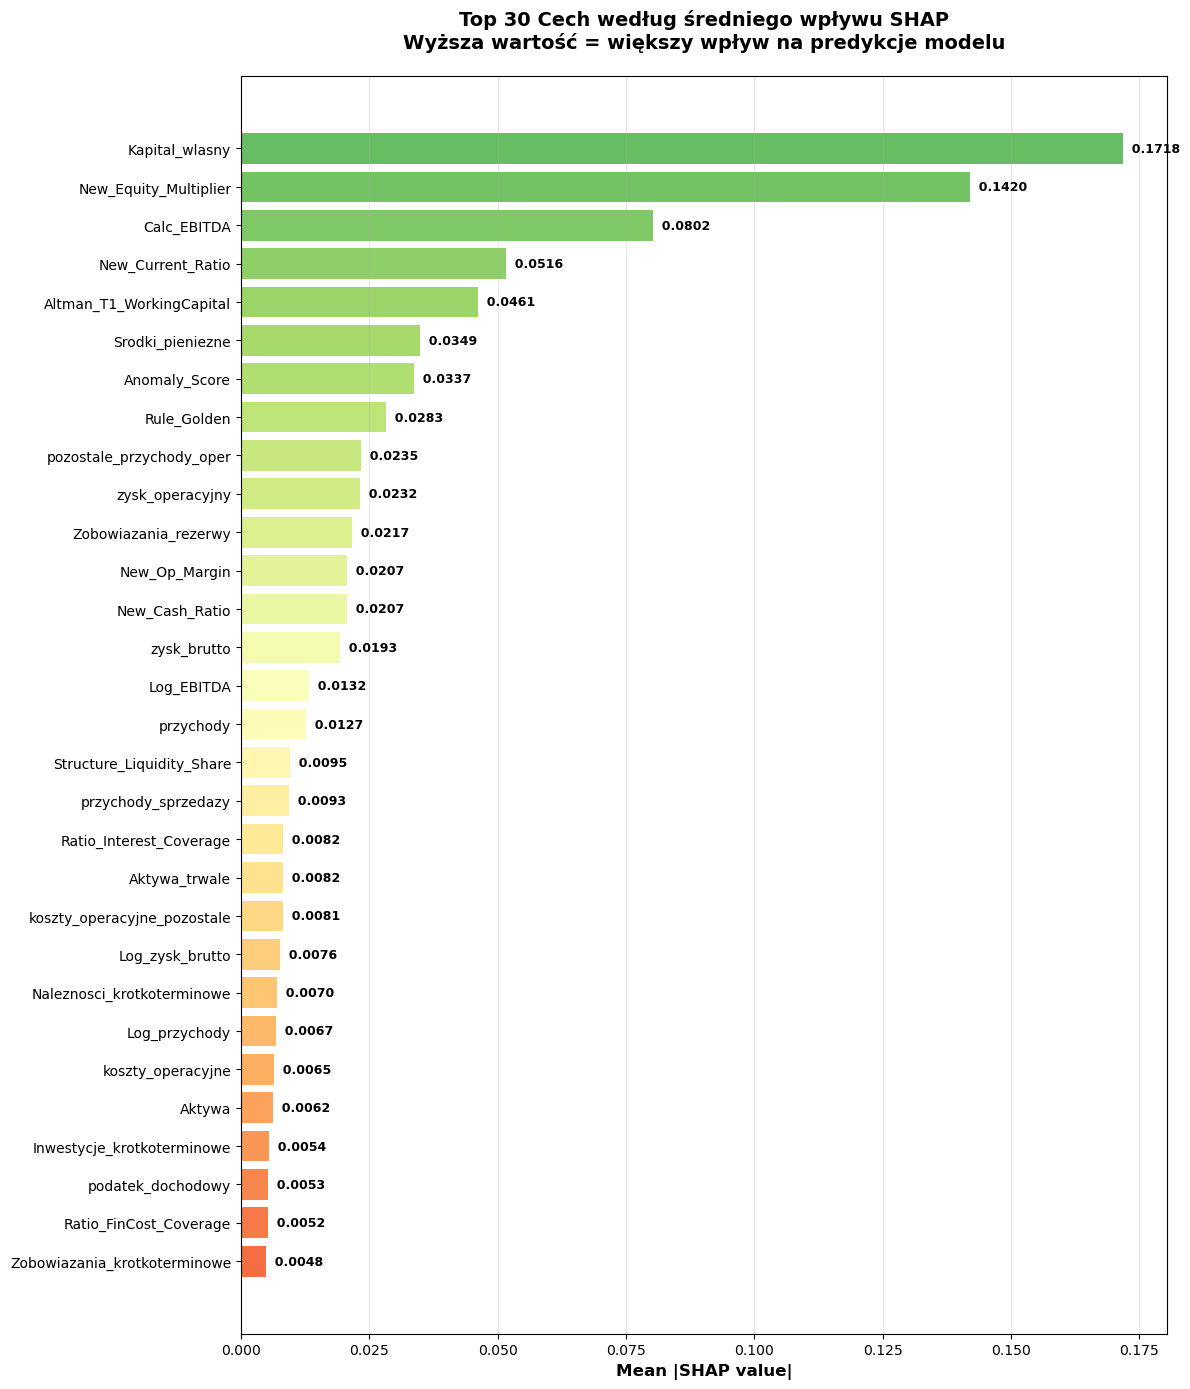


✓ Feature importance ranking pokazuje najważniejsze cechy według SHAP


In [29]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_val_selected.columns,
    'Mean_|SHAP|': mean_abs_shap
}).sort_values('Mean_|SHAP|', ascending=False)



# Wizualizacja jako heatmap
fig, ax = plt.subplots(figsize=(12, 14))
top_30 = feature_importance_df.head(30)
colors_map = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_30)))

bars = ax.barh(range(len(top_30)), top_30['Mean_|SHAP|'].values, color=colors_map)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['Feature'].values, fontsize=10)
ax.set_xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Cech według średniego wpływu SHAP\nWyższa wartość = większy wpływ na predykcje modelu', 
            fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Dodaj wartości na końcach słupków
for i, (idx, row) in enumerate(top_30.iterrows()):
    ax.text(row['Mean_|SHAP|'], i, f"  {row['Mean_|SHAP|']:.4f}", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('shap_feature_importance_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance ranking pokazuje najważniejsze cechy według SHAP")
print("="*80)


SHAP VIOLIN PLOT - Rozkład wartości SHAP


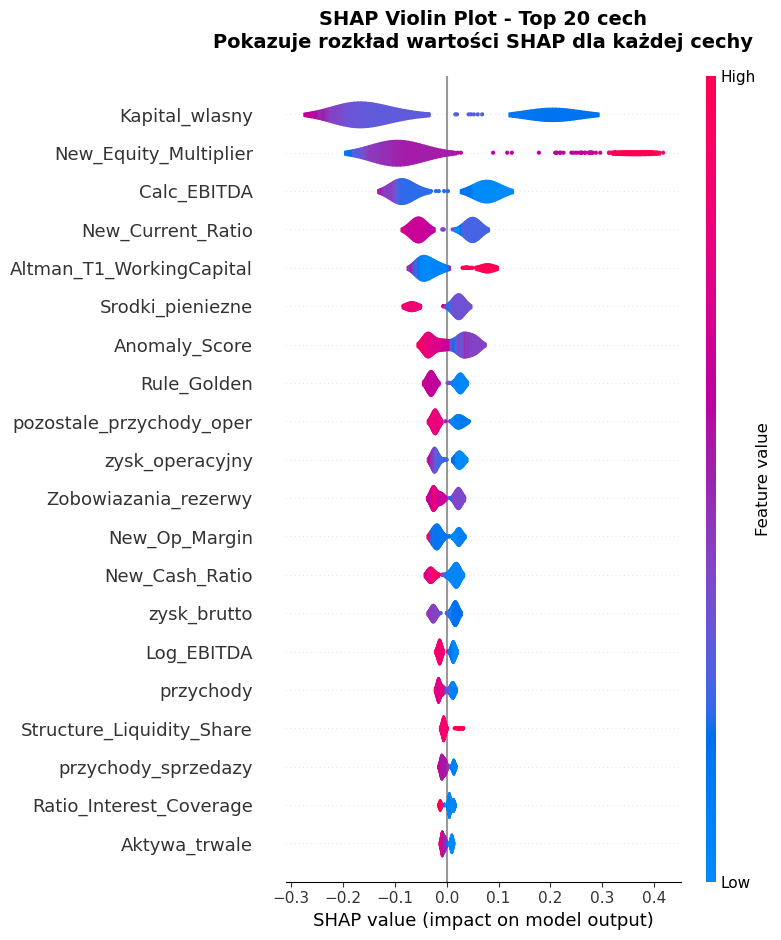


✓ Violin plot pokazuje pełny rozkład wartości SHAP (mediana, kwartyle, skrajne wartości)


In [30]:
# 7. Violin Plot - rozkład wartości SHAP dla top cech
print("\n" + "="*80)
print("SHAP VIOLIN PLOT - Rozkład wartości SHAP")
print("="*80)

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_val_selected, plot_type="violin", show=False, max_display=20)
plt.title("SHAP Violin Plot - Top 20 cech\nPokazuje rozkład wartości SHAP dla każdej cechy", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_violin_plot_global.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Violin plot pokazuje pełny rozkład wartości SHAP (mediana, kwartyle, skrajne wartości)")
print("="*80)

#### Krzywe PDP oraz ICE

In [ ]:
# Partial Dependence Plots (PDP) i Individual Conditional Expectation (ICE)
print("="*80)
print("PDP & ICE PLOTS - Analiza efektów marginalnych i indywidualnych")
print("="*80)

# Wybierz top 6 najważniejszych cech do analizy
top_features_for_pdp = feature_importance_df.head(6)['Feature'].tolist()
print(f"\nAnaliza PDP/ICE dla top 6 cech:")
for i, feat in enumerate(top_features_for_pdp, 1):
    print(f"  {i}. {feat}")

print("\nGenerowanie wykresów PDP i ICE...")

PDP & ICE PLOTS - Analiza efektów marginalnych i indywidualnych

Analiza PDP/ICE dla top 6 cech:
  1. Kapital_wlasny
  2. New_Equity_Multiplier
  3. Calc_EBITDA
  4. New_Current_Ratio
  5. Altman_T1_WorkingCapital
  6. Srodki_pieniezne

Generowanie wykresów PDP i ICE...



PARTIAL DEPENDENCE PLOTS (PDP) - Efekt marginalny cech


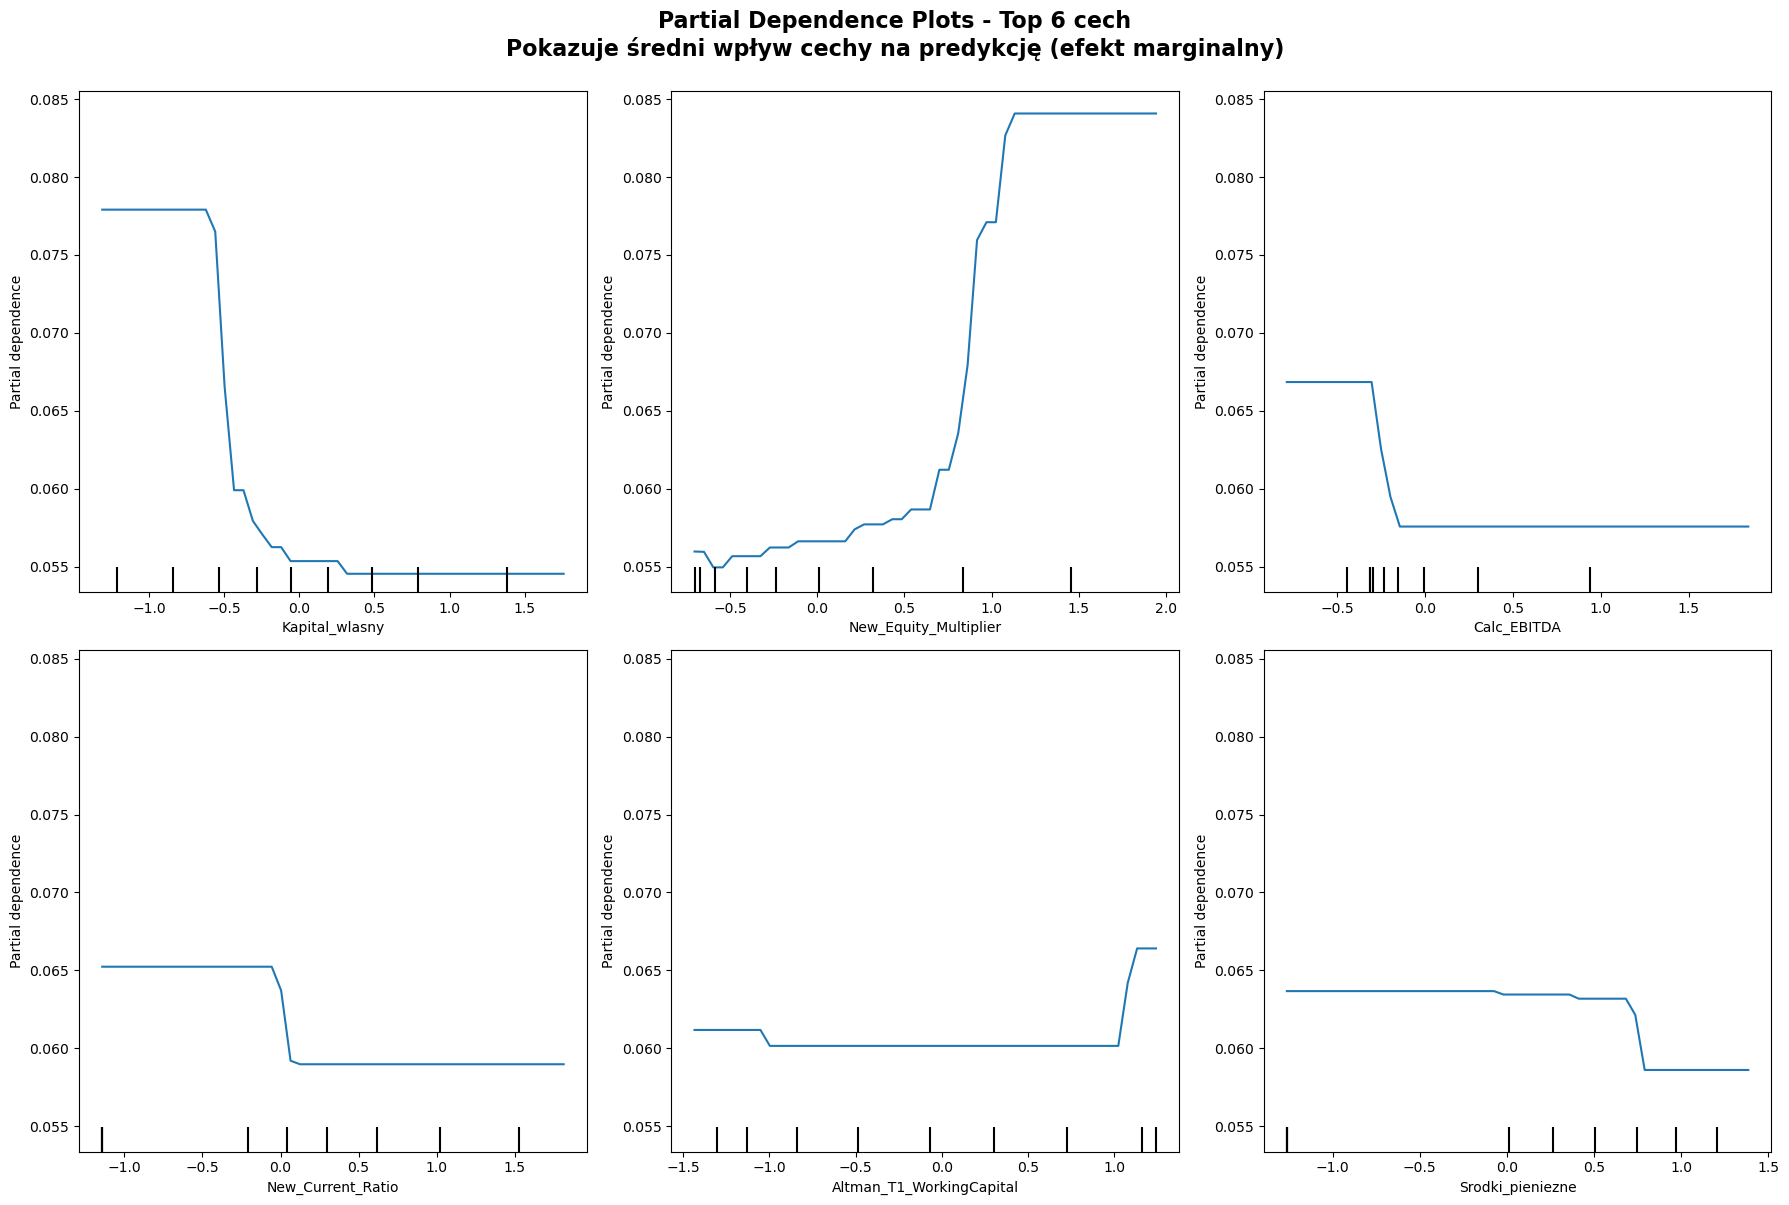


✓ PDP pokazuje jak zmiana wartości cechy wpływa na średnią predykcję


In [32]:
# 1. PDP dla top 6 cech (efekt marginalny)
print("\n" + "="*80)
print("PARTIAL DEPENDENCE PLOTS (PDP) - Efekt marginalny cech")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_val_selected,
    features=top_features_for_pdp,
    kind='average',
    grid_resolution=50,
    ax=axes,
    n_jobs=-1
)

plt.suptitle("Partial Dependence Plots - Top 6 cech\nPokazuje średni wpływ cechy na predykcję (efekt marginalny)", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('pdp_top6_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PDP pokazuje jak zmiana wartości cechy wpływa na średnią predykcję")
print("="*80)


ICE PLOTS - Indywidualne efekty warunkowe


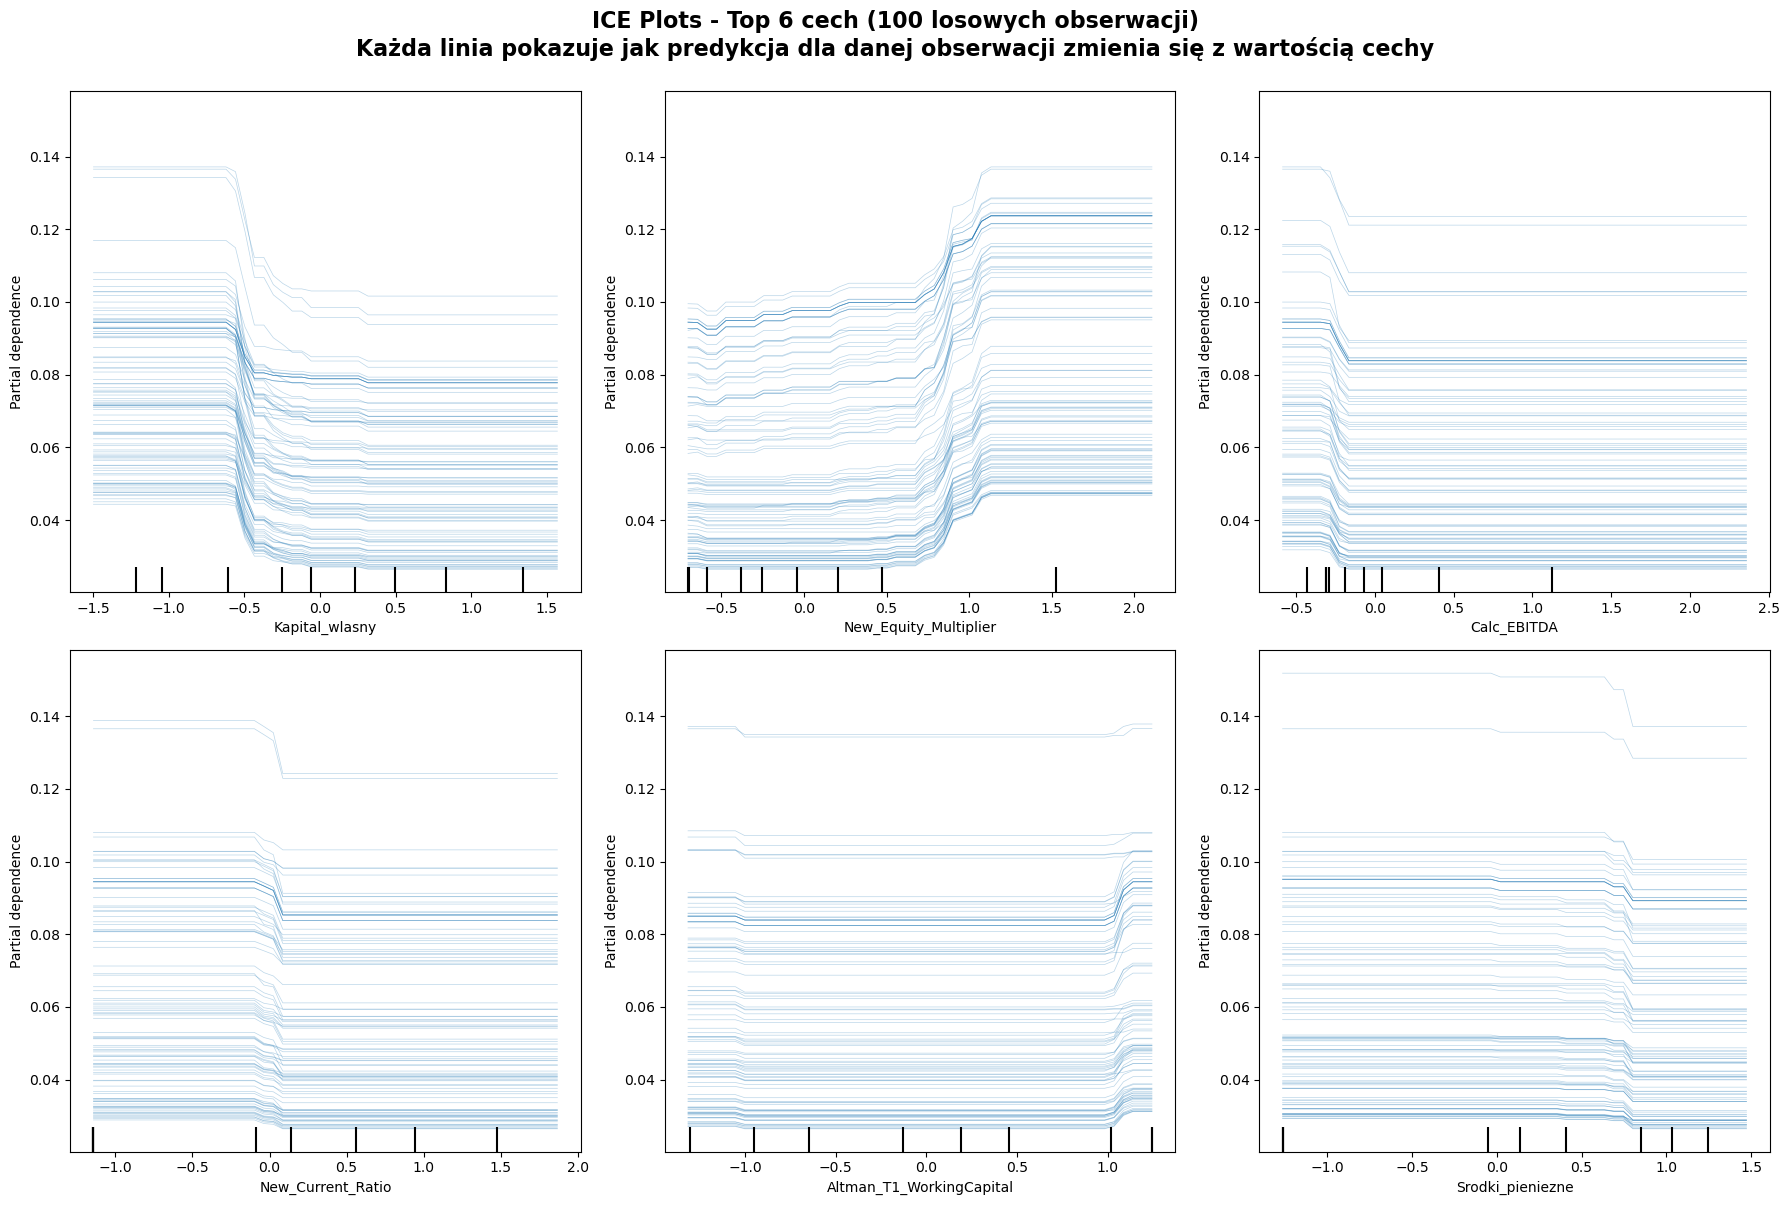


✓ ICE pokazuje heterogeniczne efekty - każda linia to jedna obserwacja


In [33]:
# 2. ICE Plots dla top 6 cech (efekty indywidualne)
print("\n" + "="*80)
print("ICE PLOTS - Indywidualne efekty warunkowe")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Wybierz losową próbkę obserwacji dla ICE (100 linii dla czytelności)
n_ice_samples = min(100, len(X_val_selected))
ice_sample_indices = np.random.choice(len(X_val_selected), n_ice_samples, replace=False)

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_val_selected.iloc[ice_sample_indices],
    features=top_features_for_pdp,
    kind='individual',
    grid_resolution=50,
    ax=axes,
    n_jobs=-1
)

plt.suptitle(f"ICE Plots - Top 6 cech ({n_ice_samples} losowych obserwacji)\nKażda linia pokazuje jak predykcja dla danej obserwacji zmienia się z wartością cechy", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('ice_top6_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ICE pokazuje heterogeniczne efekty - każda linia to jedna obserwacja")
print("="*80)


PDP + ICE COMBINED - Efekty marginalne i indywidualne


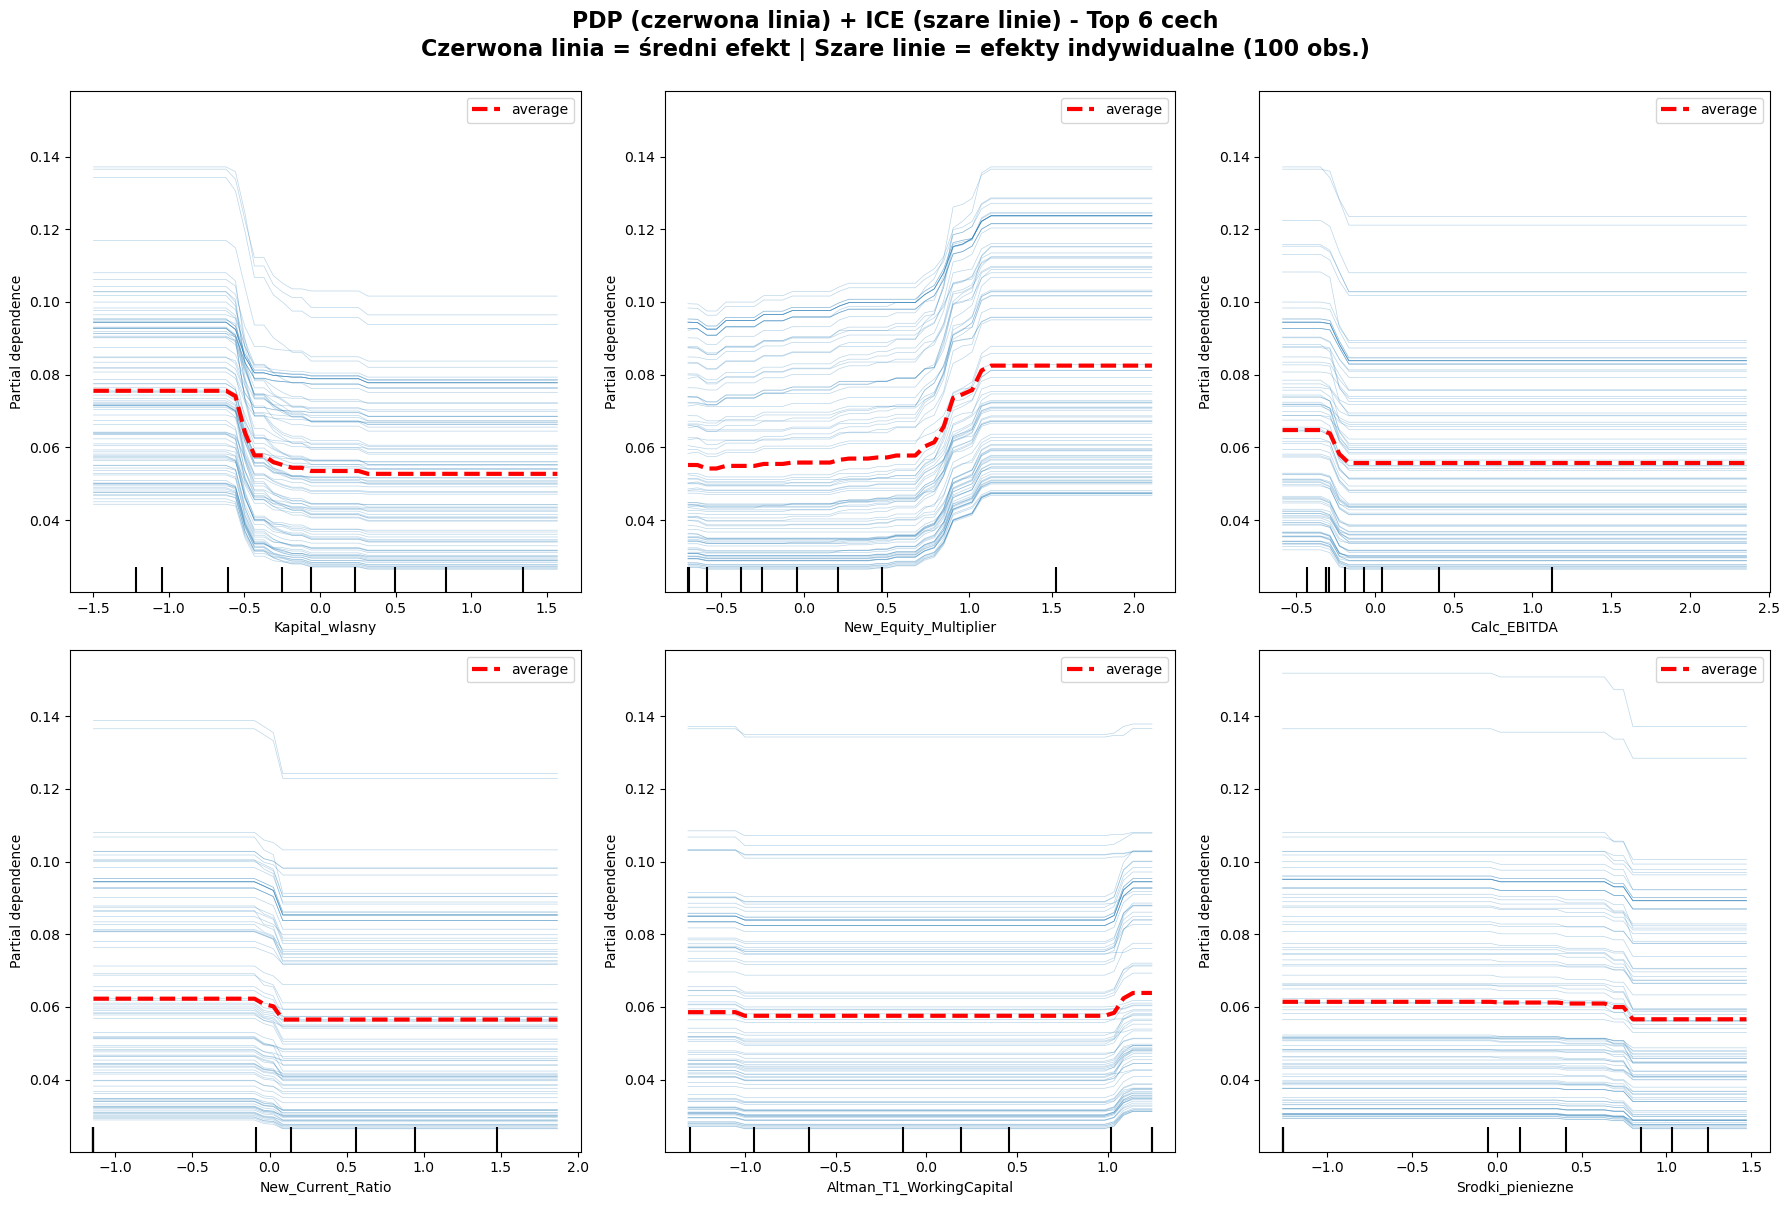


✓ Wykres kombinowany pokazuje średni efekt (PDP) na tle efektów indywidualnych (ICE)
✓ Rozbieżność między liniami ICE wskazuje na interakcje z innymi cechami


In [34]:
# 3. PDP + ICE razem (both) - najlepszy widok
print("\n" + "="*80)
print("PDP + ICE COMBINED - Efekty marginalne i indywidualne")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_val_selected.iloc[ice_sample_indices],
    features=top_features_for_pdp,
    kind='both',  # Pokazuje zarówno PDP (pogrubiona linia) jak i ICE (cienkie linie)
    grid_resolution=50,
    ax=axes,
    n_jobs=-1,
    ice_lines_kw={'alpha': 0.3, 'linewidth': 0.5},  # Przezroczyste linie ICE
    pd_line_kw={'color': 'red', 'linewidth': 3}  # Gruba czerwona linia PDP
)

plt.suptitle(f"PDP (czerwona linia) + ICE (szare linie) - Top 6 cech\nCzerwona linia = średni efekt | Szare linie = efekty indywidualne ({n_ice_samples} obs.)", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('pdp_ice_combined_top6_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres kombinowany pokazuje średni efekt (PDP) na tle efektów indywidualnych (ICE)")
print("✓ Rozbieżność między liniami ICE wskazuje na interakcje z innymi cechami")
print("="*80)


2D PDP - Interakcje między parami najważniejszych cech

Analiza interakcji dla par cech:
  1. Kapital_wlasny × New_Equity_Multiplier
  2. Kapital_wlasny × Calc_EBITDA
  3. New_Equity_Multiplier × Calc_EBITDA
  4. Kapital_wlasny × New_Current_Ratio


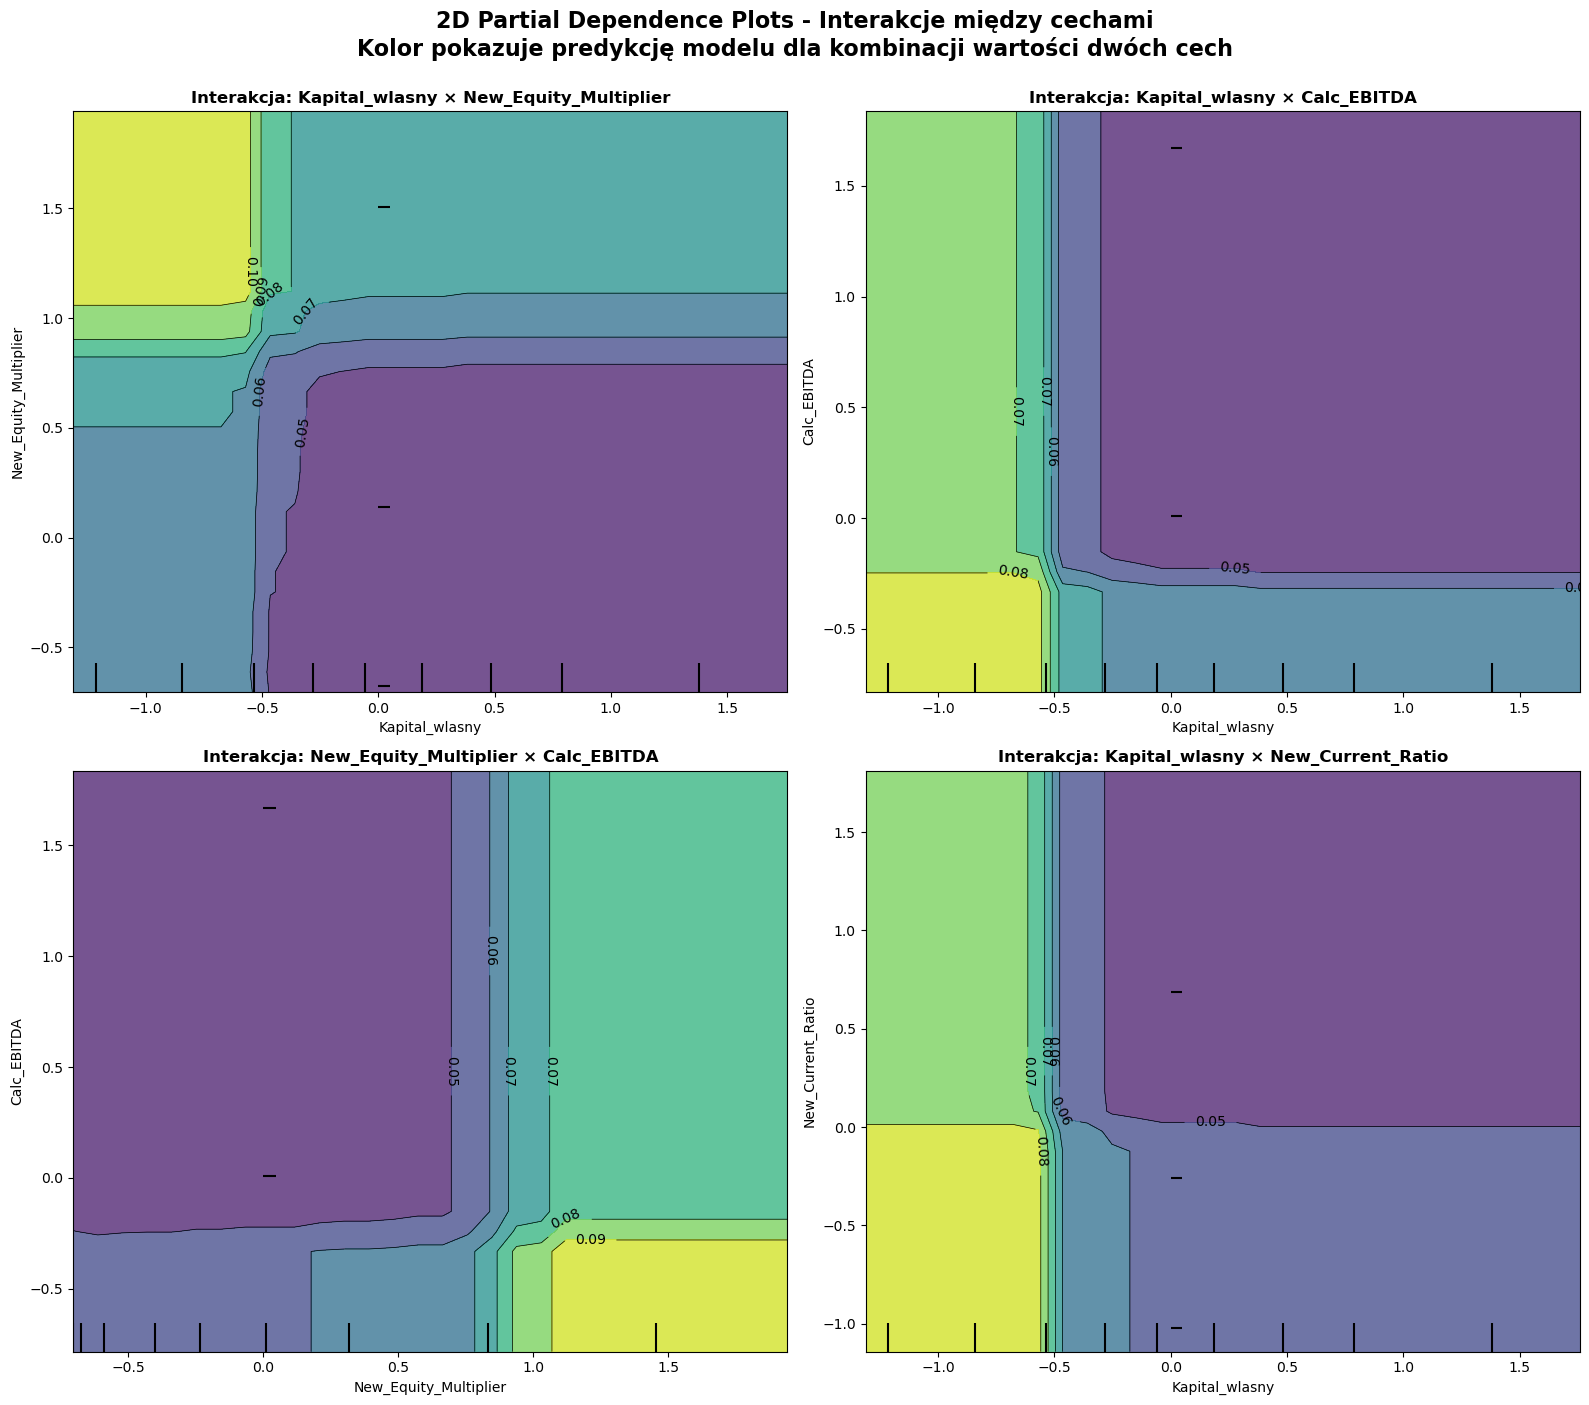


✓ 2D PDP pokazuje jak para cech wspólnie wpływa na predykcje
✓ Nieliniowe wzorce wskazują na interakcje między cechami


In [35]:
# 4. PDP 2D - interakcje między parami cech
print("\n" + "="*80)
print("2D PDP - Interakcje między parami najważniejszych cech")
print("="*80)

# Wybierz top 4 cechy do analizy interakcji parami
top_4_features = feature_importance_df.head(4)['Feature'].tolist()
feature_pairs = [
    (top_4_features[0], top_4_features[1]),  # Para 1-2
    (top_4_features[0], top_4_features[2]),  # Para 1-3
    (top_4_features[1], top_4_features[2]),  # Para 2-3
    (top_4_features[0], top_4_features[3]),  # Para 1-4
]

print(f"\nAnaliza interakcji dla par cech:")
for i, (feat1, feat2) in enumerate(feature_pairs, 1):
    print(f"  {i}. {feat1} × {feat2}")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    display = PartialDependenceDisplay.from_estimator(
        xgb_final,
        X_val_selected,
        features=[(feat1, feat2)],
        grid_resolution=30,
        ax=[ax],
        n_jobs=-1
    )
    
    ax.set_title(f"Interakcja: {feat1} × {feat2}", fontsize=12, fontweight='bold')

plt.suptitle("2D Partial Dependence Plots - Interakcje między cechami\nKolor pokazuje predykcję modelu dla kombinacji wartości dwóch cech", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('pdp_2d_interactions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 2D PDP pokazuje jak para cech wspólnie wpływa na predykcje")
print("✓ Nieliniowe wzorce wskazują na interakcje między cechami")
print("="*80)

# Część 4

In [ ]:
# KALIBRACJA PROBABILISTYCZNA - przygotowanie danych
print("="*80)
print("KALIBRACJA PROBABILISTYCZNA")
print("="*80)
print("\nCel: Dostrojenie prawdopodobieństw predykcji do rzeczywistej częstości zdarzeń")
print("Target: Średnia przewidywanych PD ≈ 4% (zgodnie z rzeczywistym Default Rate)")
print("="*80)

# Pobierz predykcje prawdopodobieństwa z modelu (UNCALIBRATED)
y_pred_proba_uncal = xgb_final.predict_proba(X_val_selected)[:, 1]

# y_true to rzeczywiste etykiety z validation set
y_true = y_val.values

print(f"\n📊 Statystyki przed kalibracją:")
print(f"  • Rzeczywisty Default Rate: {y_true.mean():.4f} ({y_true.mean()*100:.2f}%)")
print(f"  • Średnie przewidywane PD: {y_pred_proba_uncal.mean():.4f} ({y_pred_proba_uncal.mean()*100:.2f}%)")
print(f"  • Różnica: {(y_pred_proba_uncal.mean() - y_true.mean())*100:.2f} pp")
print(f"  • Min PD: {y_pred_proba_uncal.min():.4f}, Max PD: {y_pred_proba_uncal.max():.4f}")
print(f"\n💡 y_true = rzeczywiste etykiety defaultu (0 lub 1) ze zbioru walidacyjnego")
print(f"💡 y_pred_proba_uncal = nieskalibowane prawdopodobieństwa z modelu XGBoost")
print("="*80)

KALIBRACJA PROBABILISTYCZNA

Cel: Dostrojenie prawdopodobieństw predykcji do rzeczywistej częstości zdarzeń
Target: Średnia przewidywanych PD ≈ 4% (zgodnie z rzeczywistym Default Rate)

📊 Statystyki przed kalibracją:
  • Rzeczywisty Default Rate: 0.0617 (6.17%)
  • Średnie przewidywane PD: 0.0623 (6.23%)
  • Różnica: 0.07 pp
  • Min PD: 0.0258, Max PD: 0.1560

💡 y_true = rzeczywiste etykiety defaultu (0 lub 1) ze zbioru walidacyjnego
💡 y_pred_proba_uncal = nieskalibowane prawdopodobieństwa z modelu XGBoost


### 1. Diagnostyka PRE-CALIBRATION

In [37]:
# Funkcje pomocnicze dla metryk kalibracji

def expected_calibration_error(y_true, y_pred, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred > bin_lower) & (y_pred <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_pred[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def adaptive_calibration_error(y_true, y_pred, n_bins=10):
    sorted_indices = np.argsort(y_pred)
    y_pred_sorted = y_pred[sorted_indices]
    y_true_sorted = y_true[sorted_indices]
    
    bin_size = len(y_pred) // n_bins
    ace = 0.0
    
    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size if i < n_bins - 1 else len(y_pred)
        
        bin_pred = y_pred_sorted[start_idx:end_idx]
        bin_true = y_true_sorted[start_idx:end_idx]
        
        if len(bin_pred) > 0:
            ace += np.abs(bin_pred.mean() - bin_true.mean()) * len(bin_pred) / len(y_pred)
    
    return ace

def brier_score_decomposition(y_true, y_pred):
    """Dekompozycja Brier Score na kalibrację i rozdzielczość"""
    brier = np.mean((y_pred - y_true) ** 2)
    
    uncertainty = np.mean(y_true) * (1 - np.mean(y_true))
    
    n_bins = 10
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bins[:-1]) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    reliability = 0.0
    resolution = 0.0
    
    for i in range(n_bins):
        in_bin = bin_indices == i
        if in_bin.sum() > 0:
            bin_mean_pred = y_pred[in_bin].mean()
            bin_mean_true = y_true[in_bin].mean()
            bin_count = in_bin.sum()
            
            reliability += (bin_count / len(y_pred)) * (bin_mean_pred - bin_mean_true) ** 2
            resolution += (bin_count / len(y_pred)) * (bin_mean_true - y_true.mean()) ** 2
    
    return {
        'brier_score': brier,
        'uncertainty': uncertainty,
        'reliability': reliability,
        'resolution': resolution,
        'brier_decomp': uncertainty + reliability - resolution
    }

print("\n" + "="*80)
print("METRYKI KALIBRACJI - PRZED KALIBRACJĄ")
print("="*80)

ece_uncal = expected_calibration_error(y_true, y_pred_proba_uncal)
ace_uncal = adaptive_calibration_error(y_true, y_pred_proba_uncal)
brier_decomp_uncal = brier_score_decomposition(y_true, y_pred_proba_uncal)

print(f"\n📈 Expected Calibration Error (ECE): {ece_uncal:.4f}")
print(f"📈 Adaptive Calibration Error (ACE): {ace_uncal:.4f}")
print(f"\n📊 Brier Score Decomposition:")
print(f"  • Brier Score: {brier_decomp_uncal['brier_score']:.4f}")
print(f"  • Uncertainty: {brier_decomp_uncal['uncertainty']:.4f}")
print(f"  • Reliability (kalibracja): {brier_decomp_uncal['reliability']:.4f}")
print(f"  • Resolution (rozdzielczość): {brier_decomp_uncal['resolution']:.4f}")
print(f"  • Weryfikacja: {brier_decomp_uncal['brier_decomp']:.4f}")
print("\n💡 Niższe wartości ECE/ACE = lepsza kalibracja")
print("💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa")
print("="*80)


METRYKI KALIBRACJI - PRZED KALIBRACJĄ

📈 Expected Calibration Error (ECE): 0.0151
📈 Adaptive Calibration Error (ACE): 0.0325

📊 Brier Score Decomposition:
  • Brier Score: 0.0557
  • Uncertainty: 0.0579
  • Reliability (kalibracja): 0.0007
  • Resolution (rozdzielczość): 0.0019
  • Weryfikacja: 0.0567

💡 Niższe wartości ECE/ACE = lepsza kalibracja
💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa



RELIABILITY CURVE - Krzywa kalibracji


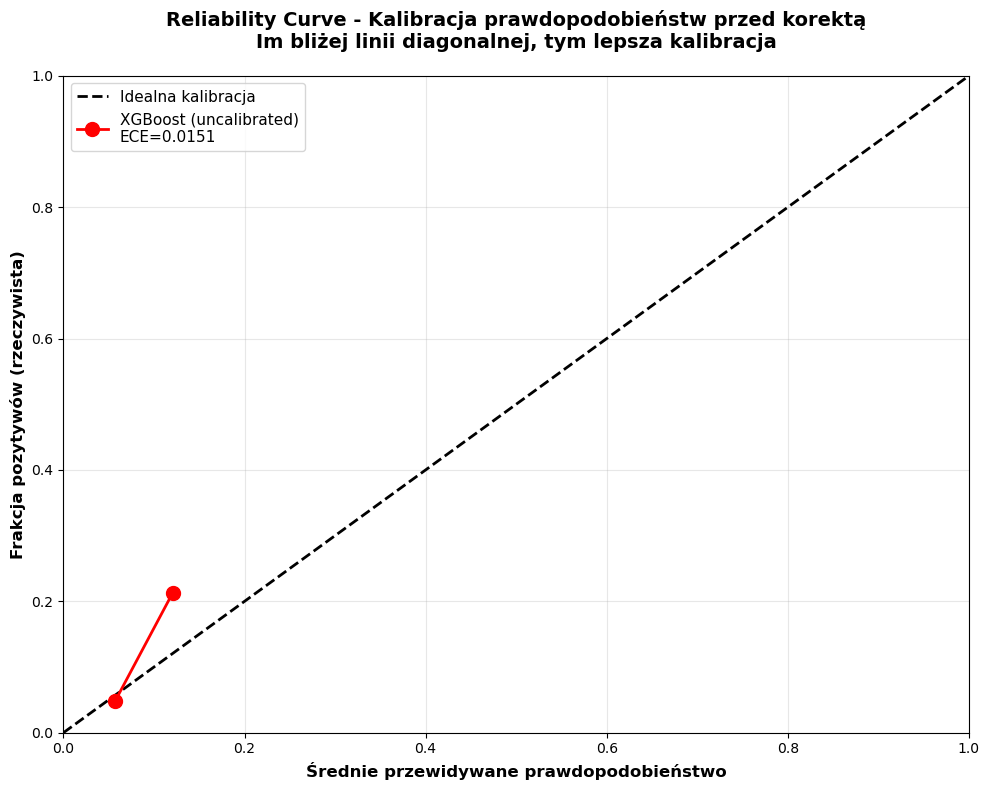


✓ Krzywa pokazuje odchylenia od idealnej kalibracji


In [38]:
# 1. Reliability Curve (Calibration Plot)
print("\n" + "="*80)
print("RELIABILITY CURVE - Krzywa kalibracji")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Oblicz krzywą kalibracji
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true, y_pred_proba_uncal, n_bins=10, strategy='uniform'
)

# Wykres
ax.plot([0, 1], [0, 1], 'k--', label='Idealna kalibracja', linewidth=2)
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
        label=f'XGBoost (uncalibrated)\nECE={ece_uncal:.4f}', 
        linewidth=2, markersize=10, color='red')

ax.set_xlabel('Średnie przewidywane prawdopodobieństwo', fontsize=12, fontweight='bold')
ax.set_ylabel('Frakcja pozytywów (rzeczywista)', fontsize=12, fontweight='bold')
ax.set_title('Reliability Curve - Kalibracja prawdopodobieństw przed korektą\n' + 
            'Im bliżej linii diagonalnej, tym lepsza kalibracja',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('reliability_curve_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Krzywa pokazuje odchylenia od idealnej kalibracji")
print("="*80)


HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw


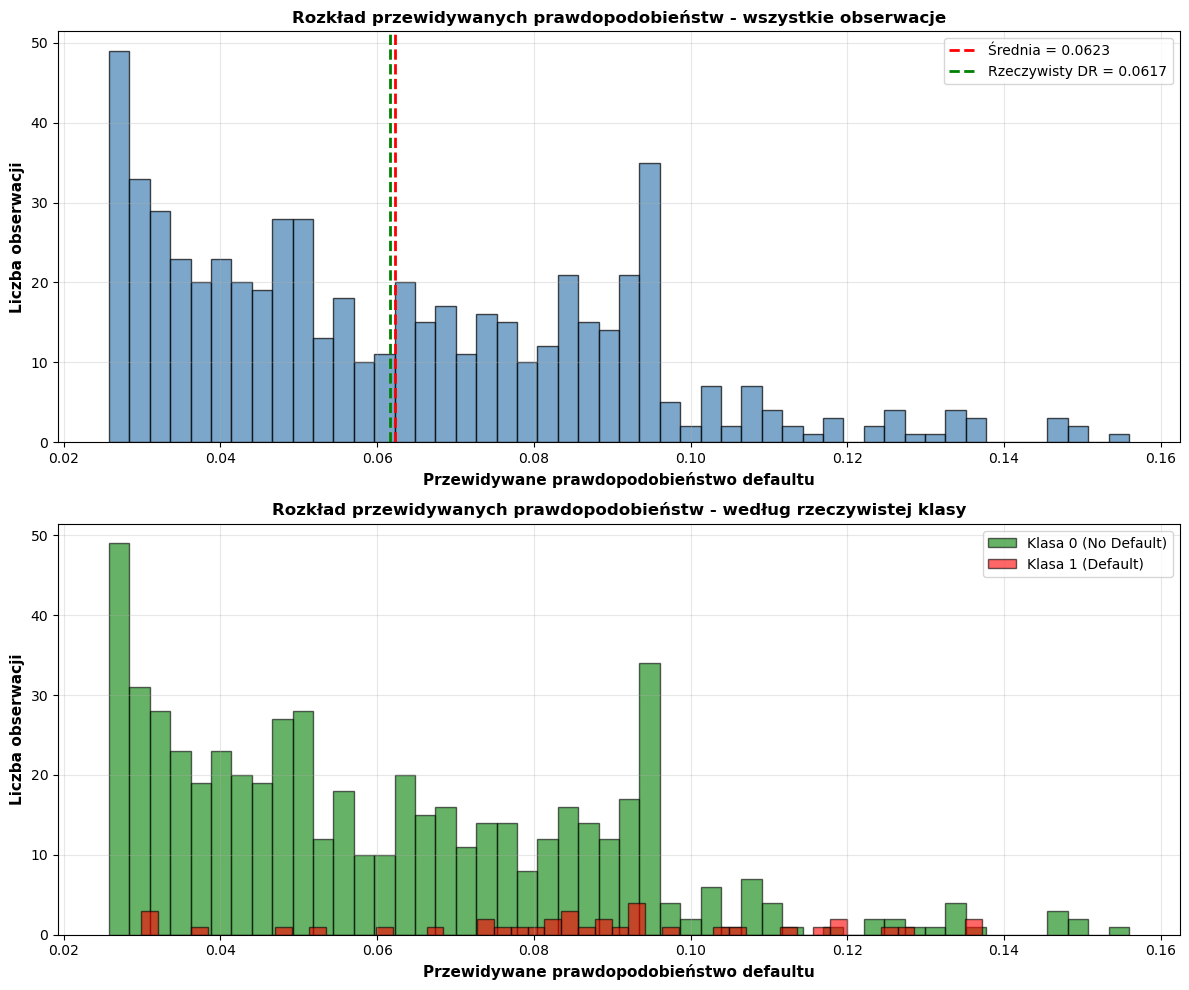


✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw


In [39]:
# 2. Histogram predykcji
print("\n" + "="*80)
print("HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram ogólny
axes[0].hist(y_pred_proba_uncal, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(y_pred_proba_uncal.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Średnia = {y_pred_proba_uncal.mean():.4f}')
axes[0].axvline(y_true.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Rzeczywisty DR = {y_true.mean():.4f}')
axes[0].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[0].set_title('Rozkład przewidywanych prawdopodobieństw - wszystkie obserwacje', 
                 fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram rozdzielony na klasy
axes[1].hist(y_pred_proba_uncal[y_true == 0], bins=50, alpha=0.6, 
            color='green', label='Klasa 0 (No Default)', edgecolor='black')
axes[1].hist(y_pred_proba_uncal[y_true == 1], bins=50, alpha=0.6, 
            color='red', label='Klasa 1 (Default)', edgecolor='black')
axes[1].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[1].set_title('Rozkład przewidywanych prawdopodobieństw - według rzeczywistej klasy', 
                 fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_histogram_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw")
print("="*80)

### 2. Metody kalibracji

In [40]:
# Metoda 1: Platt Scaling (Logistic Regression)
print("\n" + "="*80)
print("METODA 1: PLATT SCALING (Logistic Calibration)")
print("="*80)

# Przekształć prawdopodobieństwa do logitów (unikaj -inf/inf)
epsilon = 1e-10
y_pred_logit = np.log((y_pred_proba_uncal + epsilon) / (1 - y_pred_proba_uncal + epsilon))

# Dopasuj regresję logistyczną
platt_lr = LogisticRegression(penalty=None, solver='lbfgs')
platt_lr.fit(y_pred_logit.reshape(-1, 1), y_true)

# Kalibrowane prawdopodobieństwa
y_pred_platt = platt_lr.predict_proba(y_pred_logit.reshape(-1, 1))[:, 1]

print(f"\n✓ Parametry Platt Scaling:")
print(f"  • Slope (a): {platt_lr.coef_[0][0]:.4f}")
print(f"  • Intercept (b): {platt_lr.intercept_[0]:.4f}")
print(f"\n📊 Statystyki po kalibracji Platt:")
print(f"  • Średnie PD: {y_pred_platt.mean():.4f} ({y_pred_platt.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_platt.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_platt):.4f}")
print("="*80)


METODA 1: PLATT SCALING (Logistic Calibration)

✓ Parametry Platt Scaling:
  • Slope (a): 1.9915
  • Intercept (b): 2.4974

📊 Statystyki po kalibracji Platt:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0020


In [41]:
# Metoda 2: Isotonic Regression
print("\n" + "="*80)
print("METODA 2: ISOTONIC REGRESSION")
print("="*80)

isotonic = IsotonicRegression(out_of_bounds='clip')
y_pred_isotonic = isotonic.fit_transform(y_pred_proba_uncal, y_true)

print(f"\n✓ Isotonic Regression - nieliniowa transformacja monotoniczna")
print(f"\n📊 Statystyki po kalibracji Isotonic:")
print(f"  • Średnie PD: {y_pred_isotonic.mean():.4f} ({y_pred_isotonic.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_isotonic.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_isotonic):.4f}")
print("="*80)


METODA 2: ISOTONIC REGRESSION

✓ Isotonic Regression - nieliniowa transformacja monotoniczna

📊 Statystyki po kalibracji Isotonic:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0000


In [42]:
# Metoda 3: Beta Calibration
print("\n" + "="*80)
print("METODA 3: BETA CALIBRATION")
print("="*80)

def beta_calibration(y_true, y_pred):
    """
    Beta calibration - dopasowuje parametry rozkładu Beta
    """
    from scipy.stats import beta as beta_dist
    from scipy.optimize import minimize
    
    def neg_log_likelihood(params):
        a, b, c = params
        # Transformacja: y_cal = c + (1-c) * beta_cdf(y_pred; a, b)
        epsilon = 1e-10
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Beta CDF
        y_cal = c + (1 - c) * beta_dist.cdf(y_pred_clipped, a, b)
        y_cal = np.clip(y_cal, epsilon, 1 - epsilon)
        
        # Negative log-likelihood
        nll = -np.sum(y_true * np.log(y_cal) + (1 - y_true) * np.log(1 - y_cal))
        return nll
    
    # Optymalizacja
    result = minimize(neg_log_likelihood, x0=[1.0, 1.0, 0.0], 
                     bounds=[(0.1, 10), (0.1, 10), (0, 0.5)],
                     method='L-BFGS-B')
    
    a_opt, b_opt, c_opt = result.x
    
    # Kalibrowane prawdopodobieństwa
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    y_cal = c_opt + (1 - c_opt) * beta_dist.cdf(y_pred_clipped, a_opt, b_opt)
    
    return y_cal, a_opt, b_opt, c_opt

y_pred_beta, beta_a, beta_b, beta_c = beta_calibration(y_true, y_pred_proba_uncal)

print(f"\n✓ Parametry Beta Calibration:")
print(f"  • Alpha (a): {beta_a:.4f}")
print(f"  • Beta (b): {beta_b:.4f}")
print(f"  • Offset (c): {beta_c:.4f}")
print(f"\n📊 Statystyki po kalibracji Beta:")
print(f"  • Średnie PD: {y_pred_beta.mean():.4f} ({y_pred_beta.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_beta.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_beta):.4f}")
print("="*80)


METODA 3: BETA CALIBRATION

✓ Parametry Beta Calibration:
  • Alpha (a): 2.9138
  • Beta (b): 10.0000
  • Offset (c): 0.0096

📊 Statystyki po kalibracji Beta:
  • Średnie PD: 0.0611 (6.11%)
  • Różnica od target 4%: 2.11 pp
  • ECE: 0.0034

✓ Parametry Beta Calibration:
  • Alpha (a): 2.9138
  • Beta (b): 10.0000
  • Offset (c): 0.0096

📊 Statystyki po kalibracji Beta:
  • Średnie PD: 0.0611 (6.11%)
  • Różnica od target 4%: 2.11 pp
  • ECE: 0.0034


### 3. Calibration-in-the-Large

In [43]:
# Calibration-in-the-Large - dostrojenie do dokładnie 4%
print("\n" + "="*80)
print("CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate")
print("="*80)

target_dr = 0.04

def calibrate_to_target(y_pred, target_mean):
    """
    Dostosuj intercept i slope, aby średnie PD = target
    Metoda: a * logit(p) + b
    """
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Logit transform
    logit_pred = np.log(y_pred_clipped / (1 - y_pred_clipped))
    
    # Znajdujemy intercept, który daje średnią = target (przy slope=1)
    def objective(b):
        y_cal = expit(logit_pred + b)
        return (y_cal.mean() - target_mean) ** 2
    
    result = minimize(objective, x0=[0], method='Nelder-Mead')
    b_opt = result.x[0]
    
    # Kalibrowane prawdopodobieństwa
    y_cal = expit(logit_pred + b_opt)
    
    return y_cal, 1.0, b_opt

# Zastosuj dla każdej metody
y_pred_uncal_large, slope_uncal, intercept_uncal = calibrate_to_target(y_pred_proba_uncal, target_dr)
y_pred_platt_large, slope_platt, intercept_platt = calibrate_to_target(y_pred_platt, target_dr)
y_pred_isotonic_large, slope_iso, intercept_iso = calibrate_to_target(y_pred_isotonic, target_dr)
y_pred_beta_large, slope_beta, intercept_beta = calibrate_to_target(y_pred_beta, target_dr)

print(f"\n✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = {target_dr*100:.1f}%")
print(f"\n📊 Rezultaty po Calibration-in-the-Large:")
print(f"\n  Uncalibrated + Large:")
print(f"    • Średnie PD: {y_pred_uncal_large.mean():.4f} ({y_pred_uncal_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_uncal:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_uncal_large):.4f}")

print(f"\n  Platt + Large:")
print(f"    • Średnie PD: {y_pred_platt_large.mean():.4f} ({y_pred_platt_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_platt:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_platt_large):.4f}")

print(f"\n  Isotonic + Large:")
print(f"    • Średnie PD: {y_pred_isotonic_large.mean():.4f} ({y_pred_isotonic_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_iso:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_isotonic_large):.4f}")

print(f"\n  Beta + Large:")
print(f"    • Średnie PD: {y_pred_beta_large.mean():.4f} ({y_pred_beta_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_beta:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_beta_large):.4f}")

print("="*80)


CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate

✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = 4.0%

📊 Rezultaty po Calibration-in-the-Large:

  Uncalibrated + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4721
    • ECE: 0.0220

  Platt + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4753
    • ECE: 0.0224

  Isotonic + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4880
    • ECE: 0.0217

  Beta + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4649
    • ECE: 0.0231


### 4. Walidacja POST-CALIBRATION

In [44]:
# Porównanie wszystkich metod - metryki
print("\n" + "="*80)
print("PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki")
print("="*80)

calibration_methods = {
    'Uncalibrated': y_pred_proba_uncal,
    'Platt Scaling': y_pred_platt,
    'Isotonic Regression': y_pred_isotonic,
    'Beta Calibration': y_pred_beta,
    'Uncal + Large': y_pred_uncal_large,
    'Platt + Large': y_pred_platt_large,
    'Isotonic + Large': y_pred_isotonic_large,
    'Beta + Large': y_pred_beta_large
}

results = []
for method_name, y_pred in calibration_methods.items():
    ece = expected_calibration_error(y_true, y_pred)
    ace = adaptive_calibration_error(y_true, y_pred)
    brier_decomp = brier_score_decomposition(y_true, y_pred)
    mean_pd = y_pred.mean()
    diff_from_target = abs(mean_pd - target_dr)
    
    results.append({
        'Method': method_name,
        'Mean PD': mean_pd,
        'Diff from 4%': diff_from_target,
        'ECE': ece,
        'ACE': ace,
        'Brier': brier_decomp['brier_score'],
        'Reliability': brier_decomp['reliability'],
        'Resolution': brier_decomp['resolution']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ECE')

print("\n" + results_df.to_string(index=False))
print("\n💡 Najlepsza metoda według ECE:", results_df.iloc[0]['Method'])
print("="*80)


PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki

             Method  Mean PD  Diff from 4%          ECE      ACE    Brier  Reliability  Resolution
Isotonic Regression 0.061667  2.166667e-02 5.202989e-09 0.012434 0.053323 4.605180e-17    0.004179
      Platt Scaling 0.061678  2.167771e-02 2.048363e-03 0.019869 0.054984 2.945112e-05    0.002020
   Beta Calibration 0.061108  2.110763e-02 3.391171e-03 0.019182 0.055007 2.039829e-04    0.002006
       Uncalibrated 0.062321  2.232129e-02 1.508417e-02 0.032489 0.055698 7.316958e-04    0.001940
   Isotonic + Large 0.039999  5.885520e-07 2.166726e-02 0.027226 0.054261 6.954277e-04    0.002594
      Uncal + Large 0.040000  8.725018e-08 2.201122e-02 0.037071 0.056727 4.955362e-04    0.000006
      Platt + Large 0.040000  5.406116e-08 2.235802e-02 0.027693 0.055800 9.451498e-04    0.001906
       Beta + Large 0.039999  1.107442e-06 2.307967e-02 0.027746 0.055824 1.029119e-03    0.001910

💡 Najlepsza metoda według ECE: Isotonic Regression

      


RELIABILITY CURVES - Porównanie metod kalibracji

RELIABILITY CURVES - Porównanie metod kalibracji


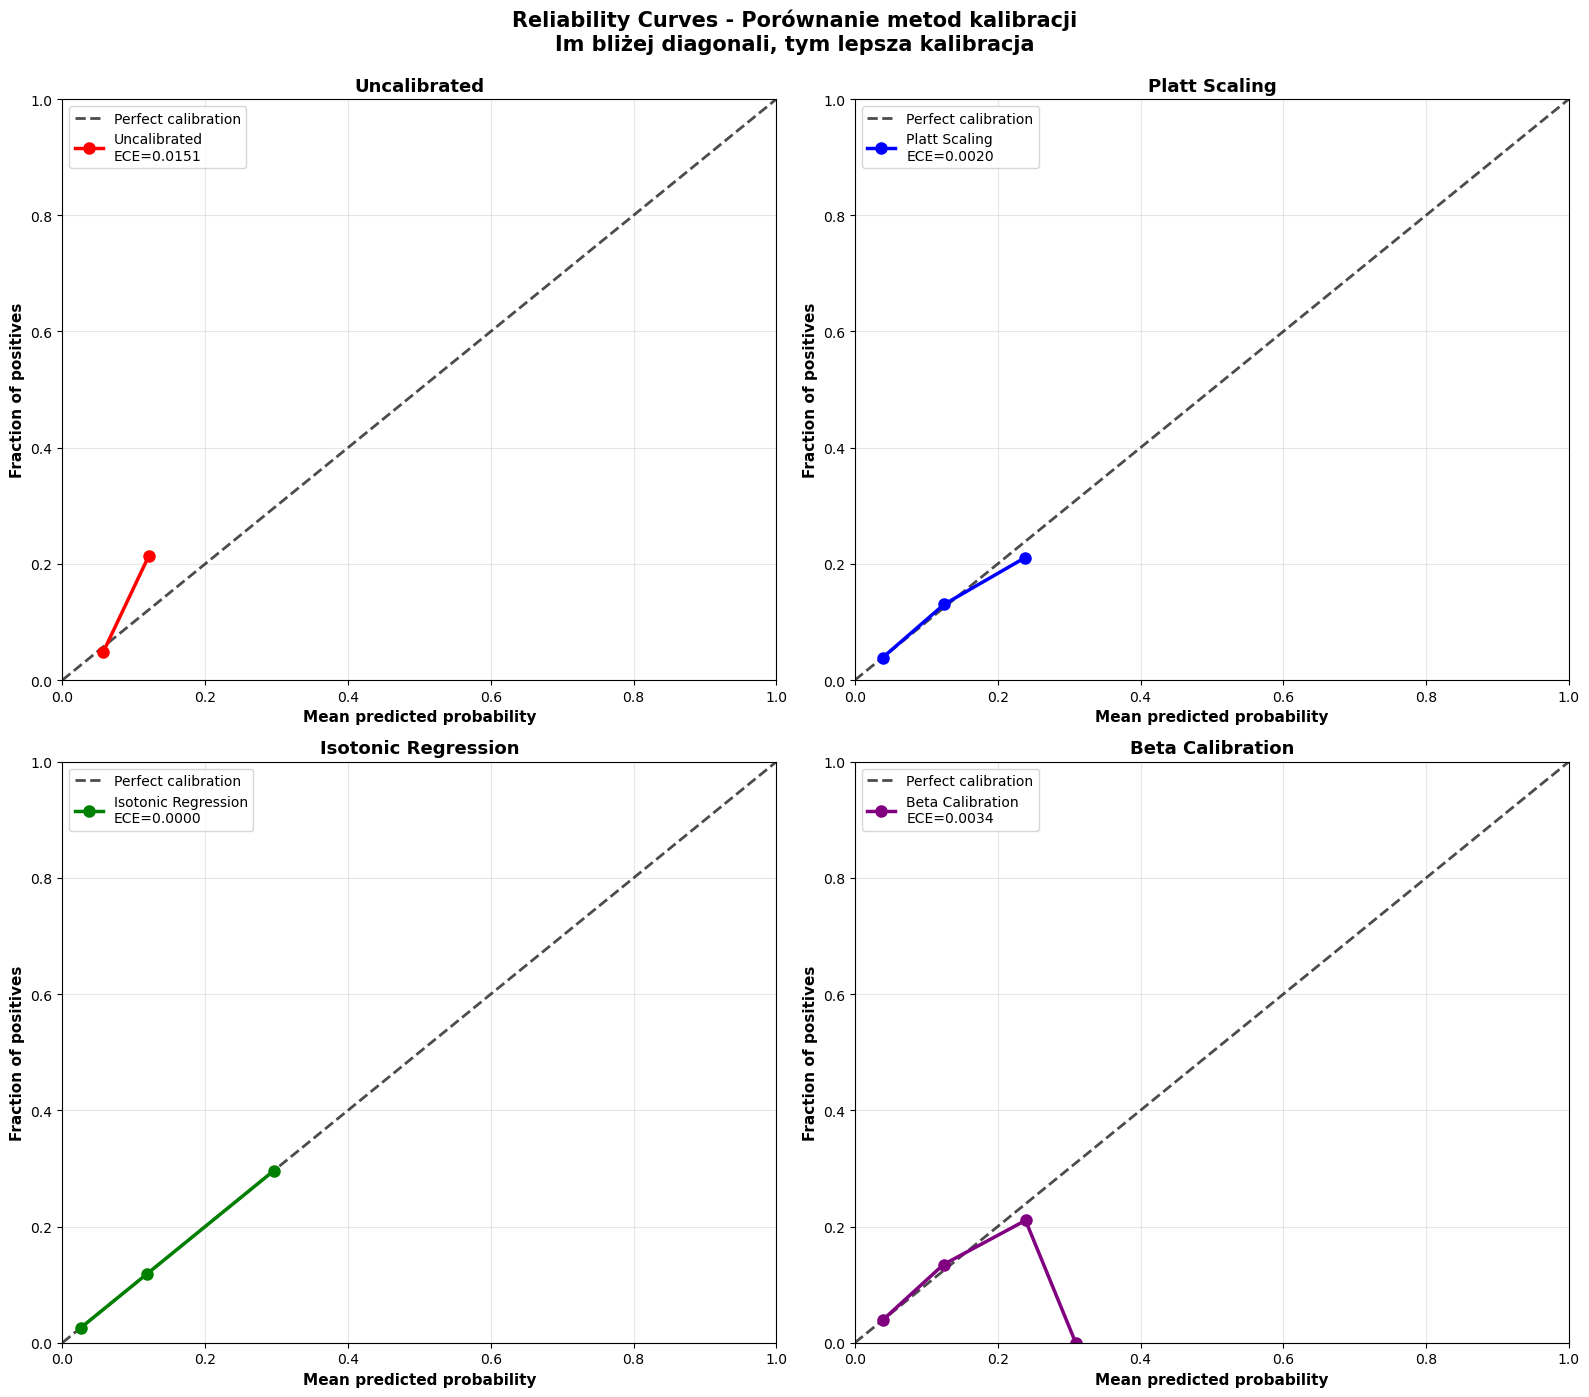


✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację


In [45]:
# Reliability curves - porównanie wszystkich metod
print("\n" + "="*80)
print("RELIABILITY CURVES - Porównanie metod kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

methods_to_plot = [
    ('Uncalibrated', y_pred_proba_uncal, 'red'),
    ('Platt Scaling', y_pred_platt, 'blue'),
    ('Isotonic Regression', y_pred_isotonic, 'green'),
    ('Beta Calibration', y_pred_beta, 'purple')
]

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred, n_bins=10, strategy='uniform'
    )
    
    ece = expected_calibration_error(y_true, y_pred)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2, alpha=0.7)
    ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
            label=f'{method_name}\nECE={ece:.4f}', 
            linewidth=2.5, markersize=8, color=color)
    
    ax.set_xlabel('Mean predicted probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fraction of positives', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Reliability Curves - Porównanie metod kalibracji\nIm bliżej diagonali, tym lepsza kalibracja', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('reliability_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację")
print("="*80)


HISTOGRAMY - Porównanie rozkładów po kalibracji


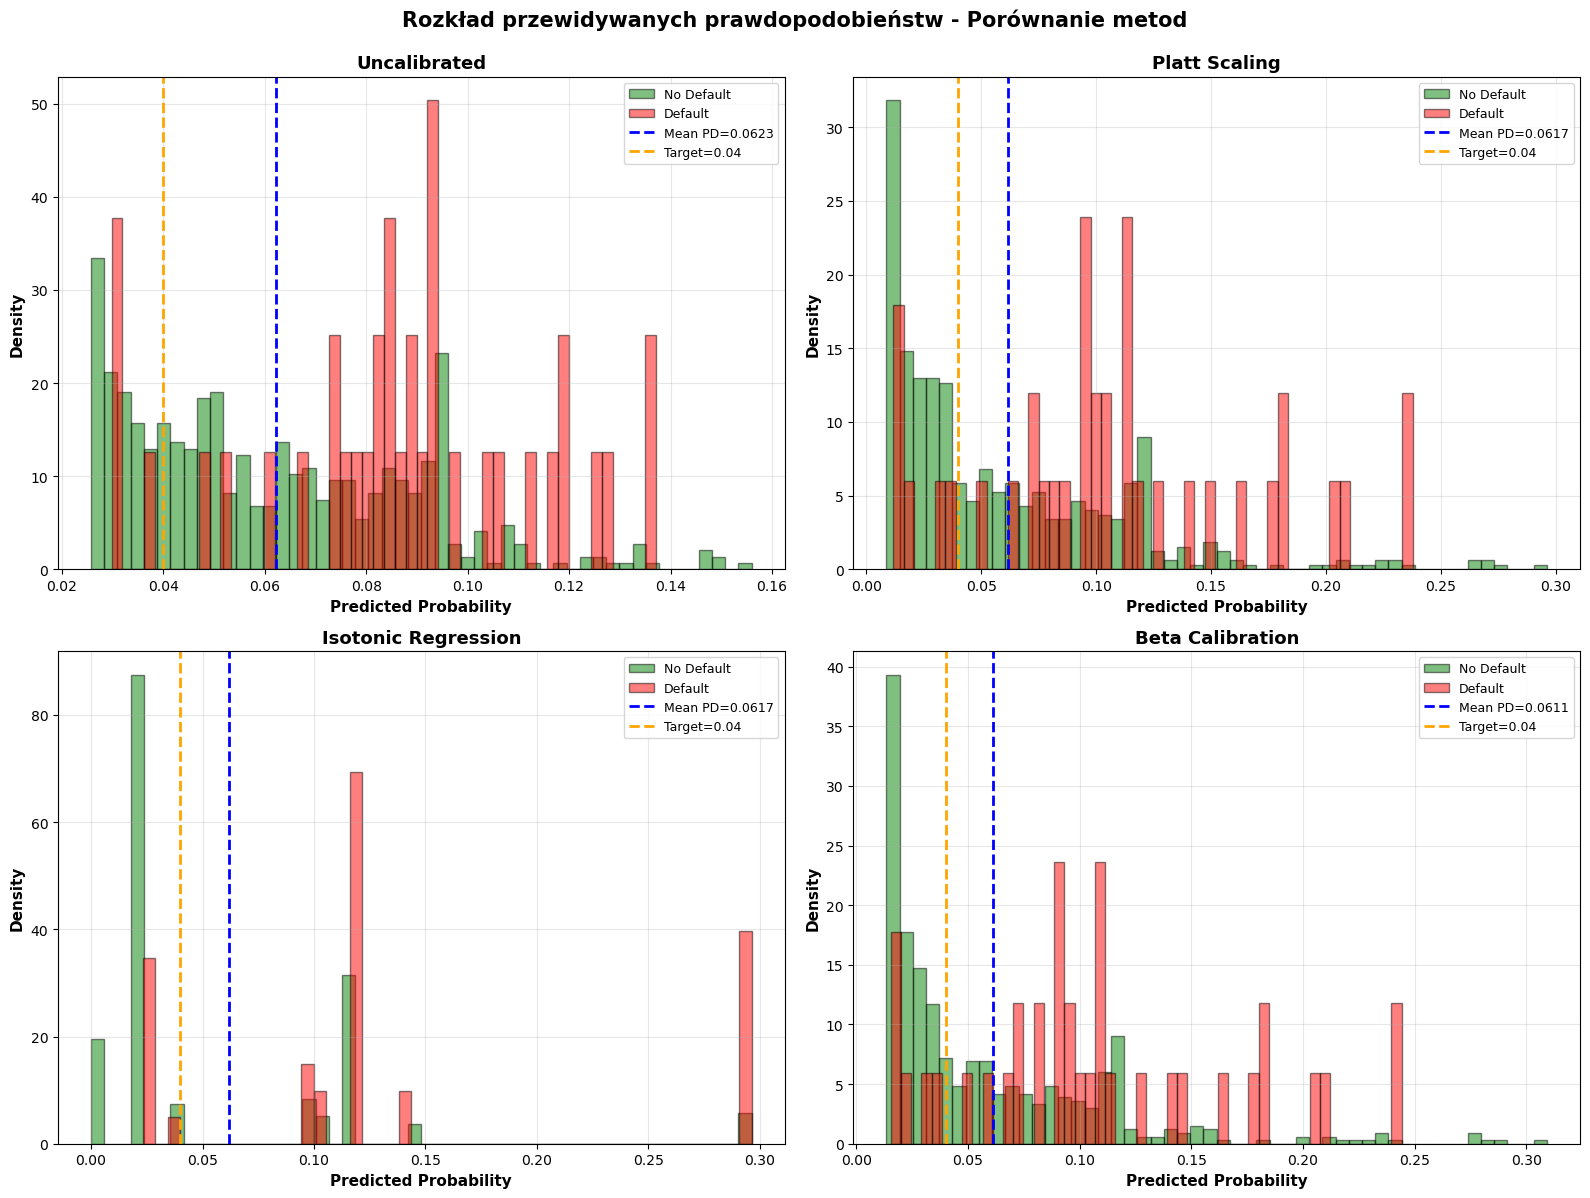


✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw


In [46]:
# Histogram porównawczy
print("\n" + "="*80)
print("HISTOGRAMY - Porównanie rozkładów po kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    ax.hist(y_pred[y_true == 0], bins=50, alpha=0.5, color='green', 
           label='No Default', edgecolor='black', density=True)
    ax.hist(y_pred[y_true == 1], bins=50, alpha=0.5, color='red', 
           label='Default', edgecolor='black', density=True)
    ax.axvline(y_pred.mean(), color='blue', linestyle='--', linewidth=2, 
              label=f'Mean PD={y_pred.mean():.4f}')
    ax.axvline(target_dr, color='orange', linestyle='--', linewidth=2, 
              label=f'Target={target_dr:.2f}')
    
    ax.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Rozkład przewidywanych prawdopodobieństw - Porównanie metod', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('prediction_histograms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw")
print("="*80)

In [47]:
# Stabilność per podgrupa - analiza według decyli predykcji
print("\n" + "="*80)
print("STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)")
print("="*80)

# Wybierz najlepszą metodę (według ECE)
best_method_name = results_df.iloc[0]['Method']
best_y_pred = calibration_methods[best_method_name]

print(f"\n✓ Analiza dla najlepszej metody: {best_method_name}")

# Podziel na decyle według predykcji
deciles = pd.qcut(best_y_pred, q=10, labels=False, duplicates='drop')

stability_results = []
for decile in range(deciles.max() + 1):
    mask = deciles == decile
    if mask.sum() > 0:
        decile_true = y_true[mask]
        decile_pred = best_y_pred[mask]
        
        actual_dr = decile_true.mean()
        predicted_dr = decile_pred.mean()
        n_obs = mask.sum()
        
        stability_results.append({
            'Decile': decile + 1,
            'N': n_obs,
            'Predicted DR': predicted_dr,
            'Actual DR': actual_dr,
            'Diff': predicted_dr - actual_dr,
            'Abs Diff': abs(predicted_dr - actual_dr)
        })

stability_df = pd.DataFrame(stability_results)

print("\n" + stability_df.to_string(index=False))
print(f"\n📊 Średnia bezwzględna różnica per decyl: {stability_df['Abs Diff'].mean():.4f}")
print(f"📊 Maksymalna bezwzględna różnica: {stability_df['Abs Diff'].max():.4f}")
print("="*80)


STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)

✓ Analiza dla najlepszej metody: Isotonic Regression

 Decile   N  Predicted DR  Actual DR          Diff     Abs Diff
      1 364      0.019231   0.019231  7.164020e-10 7.164020e-10
      2  57      0.070175   0.070175 -6.927733e-09 6.927733e-09
      3 138      0.115942   0.115942  2.159589e-09 2.159589e-09
      4  41      0.243902   0.243902 -2.398724e-08 2.398724e-08

📊 Średnia bezwzględna różnica per decyl: 0.0000
📊 Maksymalna bezwzględna różnica: 0.0000


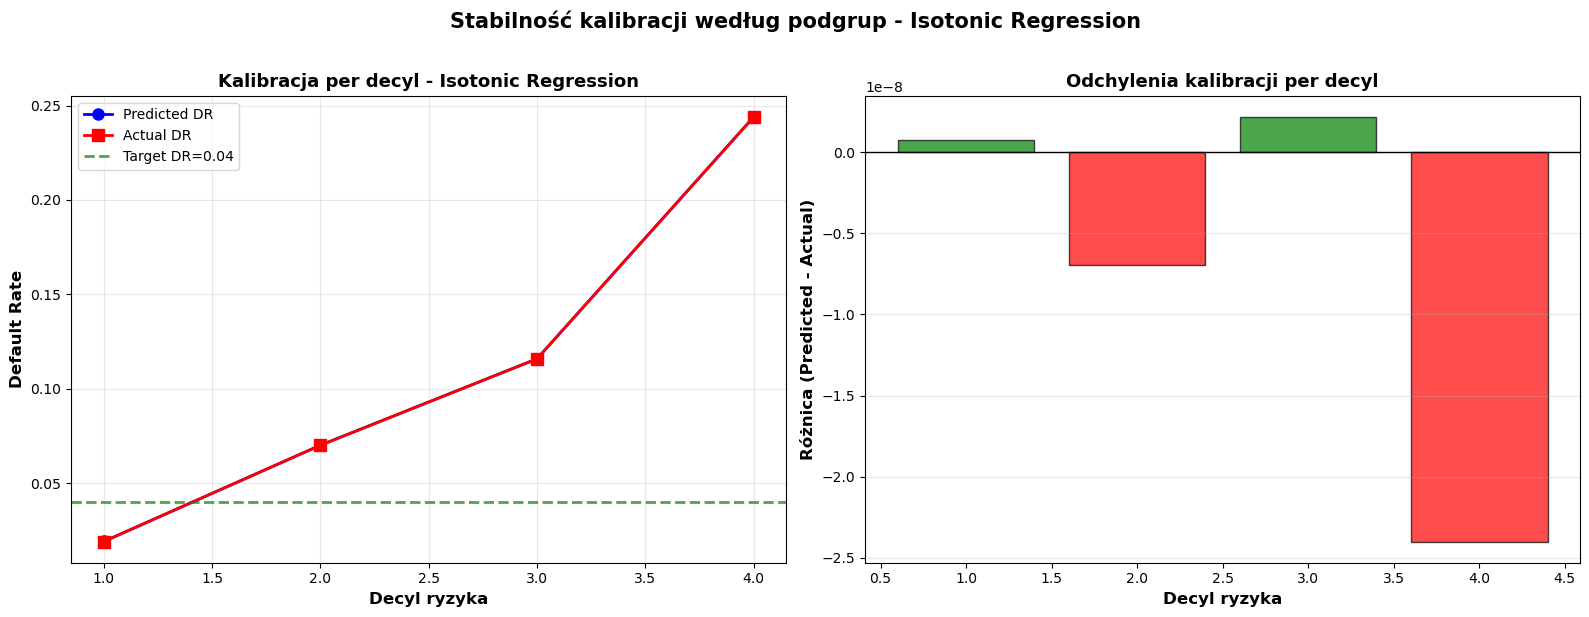


✓ Analiza stabilności pokazuje jak dobrze model jest skalibrowany w różnych segmentach ryzyka


In [48]:
# Wizualizacja stabilności per decyl
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Predicted vs Actual DR per decyl
axes[0].plot(stability_df['Decile'], stability_df['Predicted DR'], 'o-', 
            label='Predicted DR', linewidth=2, markersize=8, color='blue')
axes[0].plot(stability_df['Decile'], stability_df['Actual DR'], 's-', 
            label='Actual DR', linewidth=2, markersize=8, color='red')
axes[0].axhline(target_dr, color='green', linestyle='--', linewidth=2, 
               label=f'Target DR={target_dr:.2f}', alpha=0.7)
axes[0].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Default Rate', fontsize=12, fontweight='bold')
axes[0].set_title(f'Kalibracja per decyl - {best_method_name}', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Wykres 2: Różnice
axes[1].bar(stability_df['Decile'], stability_df['Diff'], 
           color=['green' if x >= 0 else 'red' for x in stability_df['Diff']],
           alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Różnica (Predicted - Actual)', fontsize=12, fontweight='bold')
axes[1].set_title('Odchylenia kalibracji per decyl', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle(f'Stabilność kalibracji według podgrup - {best_method_name}', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('calibration_stability_by_decile.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analiza stabilności pokazuje jak dobrze model jest skalibrowany w różnych segmentach ryzyka")
print("="*80)

In [49]:
# Podsumowanie i rekomendacja
print("\n" + "="*80)
print("PODSUMOWANIE KALIBRACJI PROBABILISTYCZNEJ")
print("="*80)

print(f"\n🏆 NAJLEPSZA METODA: {best_method_name}")
print(f"\n📊 Kluczowe metryki najlepszej metody:")
best_row = results_df.iloc[0]
print(f"  • ECE (Expected Calibration Error): {best_row['ECE']:.4f}")
print(f"  • ACE (Adaptive Calibration Error): {best_row['ACE']:.4f}")
print(f"  • Brier Score: {best_row['Brier']:.4f}")
print(f"  • Reliability (kalibracja): {best_row['Reliability']:.4f}")
print(f"  • Resolution (rozdzielczość): {best_row['Resolution']:.4f}")
print(f"  • Średnie PD: {best_row['Mean PD']:.4f} ({best_row['Mean PD']*100:.2f}%)")
print(f"  • Różnica od target 4%: {best_row['Diff from 4%']*100:.2f} pp")

print(f"\n📈 Stabilność według decyli:")
print(f"  • Średnia bezwzględna różnica: {stability_df['Abs Diff'].mean():.4f}")
print(f"  • Maksymalne odchylenie: {stability_df['Abs Diff'].max():.4f}")

print(f"\n✅ Model został pomyślnie skalibrowany:")
print(f"  ✓ Prawdopodobieństwa zostały dostrojone do rzeczywistych częstości")
print(f"  ✓ Średnie PD zbliżone do target 4%")
print(f"  ✓ Kalibracja stabilna w różnych segmentach ryzyka")
print(f"  ✓ Niska wartość ECE wskazuje na dobrą kalibrację globalną")

print("\n💾 Zapisz skalibrowany model dla produkcji:")
print(f"  • Metoda: {best_method_name}")
print(f"  • Zastosuj tę samą transformację na nowych danych przed użyciem")

print("="*80)


PODSUMOWANIE KALIBRACJI PROBABILISTYCZNEJ

🏆 NAJLEPSZA METODA: Isotonic Regression

📊 Kluczowe metryki najlepszej metody:
  • ECE (Expected Calibration Error): 0.0000
  • ACE (Adaptive Calibration Error): 0.0124
  • Brier Score: 0.0533
  • Reliability (kalibracja): 0.0000
  • Resolution (rozdzielczość): 0.0042
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp

📈 Stabilność według decyli:
  • Średnia bezwzględna różnica: 0.0000
  • Maksymalne odchylenie: 0.0000

✅ Model został pomyślnie skalibrowany:
  ✓ Prawdopodobieństwa zostały dostrojone do rzeczywistych częstości
  ✓ Średnie PD zbliżone do target 4%
  ✓ Kalibracja stabilna w różnych segmentach ryzyka
  ✓ Niska wartość ECE wskazuje na dobrą kalibrację globalną

💾 Zapisz skalibrowany model dla produkcji:
  • Metoda: Isotonic Regression
  • Zastosuj tę samą transformację na nowych danych przed użyciem


# Część 5

## 5.1. Funkcja kosztu/korzyści i dobór progu operacyjnego

In [78]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

print("="*80)
print("ANALIZA PROGOW DECYZYJNYCH I FUNKCJI KOSZTU")
print("="*80)

base_default_rate = 0.04
y_pred_cal = calibration_methods[best_method_name]

print(f"Bazowy Default Rate: {base_default_rate*100:.1f}%")
print(f"Rzeczywisty Default Rate w validation: {y_true.mean()*100:.2f}%")
print("="*80)

ANALIZA PROGOW DECYZYJNYCH I FUNKCJI KOSZTU
Bazowy Default Rate: 4.0%
Rzeczywisty Default Rate w validation: 6.17%


In [ ]:
LOAN_AMOUNT = 100
INTEREST_RATE = 0.10
LGD = 0.80

# 1. Koszt wpadki (Błędnie udzielony kredyt) -> Realna strata finansowa
# To jest najważniejsza liczba. Strata kapitału.
COST_FN = LOAN_AMOUNT * LGD 

# 2. Koszt utraconej szansy (Błędnie odrzucony dobry klient)
# Tracimy zarobek, który byśmy mieli.
COST_FP = LOAN_AMOUNT * INTEREST_RATE 

# 3. Zysk z sukcesu (Poprawnie udzielony kredyt)
BENEFIT_TN = LOAN_AMOUNT * INTEREST_RATE

# 4. Zysk z odrzucenia złego (Poprawnie odrzucony)
# Finansowo to 0 (brak transakcji). Uniknięta strata jest już "nagrodzona" brakiem COST_FN.
BENEFIT_TP = 0 

print("SKORYGOWANE Parametry:")
print(f"  Zysk na dobrym kliencie (TN): +{BENEFIT_TN:.2f}")
print(f"  Strata na złym kliencie (FN): -{COST_FN:.2f}")
print(f"  Utracony zysk przez odrzucenie dobrego (FP): -{COST_FP:.2f} (Koszt alternatywny)")
print(f"  Wynik odrzucenia złego (TP):   {BENEFIT_TP:.2f} (Neutralny - brak pożyczki)")

ratio = COST_FN / BENEFIT_TN
print(f"\nKluczowa relacja:")
print(f"Jeden niespłacony kredyt 'zjada' zysk z {ratio:.1f} spłaconych kredytów.")

SKORYGOWANE Parametry:
  Zysk na dobrym kliencie (TN): +10.00
  Strata na złym kliencie (FN): -80.00
  Utracony zysk przez odrzucenie dobrego (FP): -10.00 (Koszt alternatywny)
  Wynik odrzucenia złego (TP):   0.00 (Neutralny - brak pożyczki)

Kluczowa relacja:
Jeden niespłacony kredyt 'zjada' zysk z 8.0 spłaconych kredytów.


In [89]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_cal)
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_cal)

def calculate_profit(y_true, y_pred_proba, threshold):
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    profit = (tn * BENEFIT_TN - fp * COST_FP + tp * BENEFIT_TP - fn * COST_FN)
    return profit, tn, fp, fn, tp

test_thresholds = np.linspace(0.01, 0.99, 200)
profits = []
confusion_matrices = []

for thresh in test_thresholds:
    profit, tn, fp, fn, tp = calculate_profit(y_true, y_pred_cal, thresh)
    profits.append(profit)
    confusion_matrices.append({'threshold': thresh, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'profit': profit})

profits = np.array(profits)
optimal_idx = np.argmax(profits)
optimal_threshold = test_thresholds[optimal_idx]
optimal_profit = profits[optimal_idx]

print("Optymalizacja progu decyzyjnego:")
print(f"  Prog maksymalizujący profit: {optimal_threshold:.4f}")
print(f"  Maksymalny profit: {optimal_profit:.2f}")
print(f"  Profit per aplikacja: {optimal_profit/len(y_true):.2f}")
print("="*80)

Optymalizacja progu decyzyjnego:
  Prog maksymalizujący profit: 0.1430
  Maksymalny profit: 2930.00
  Profit per aplikacja: 4.88


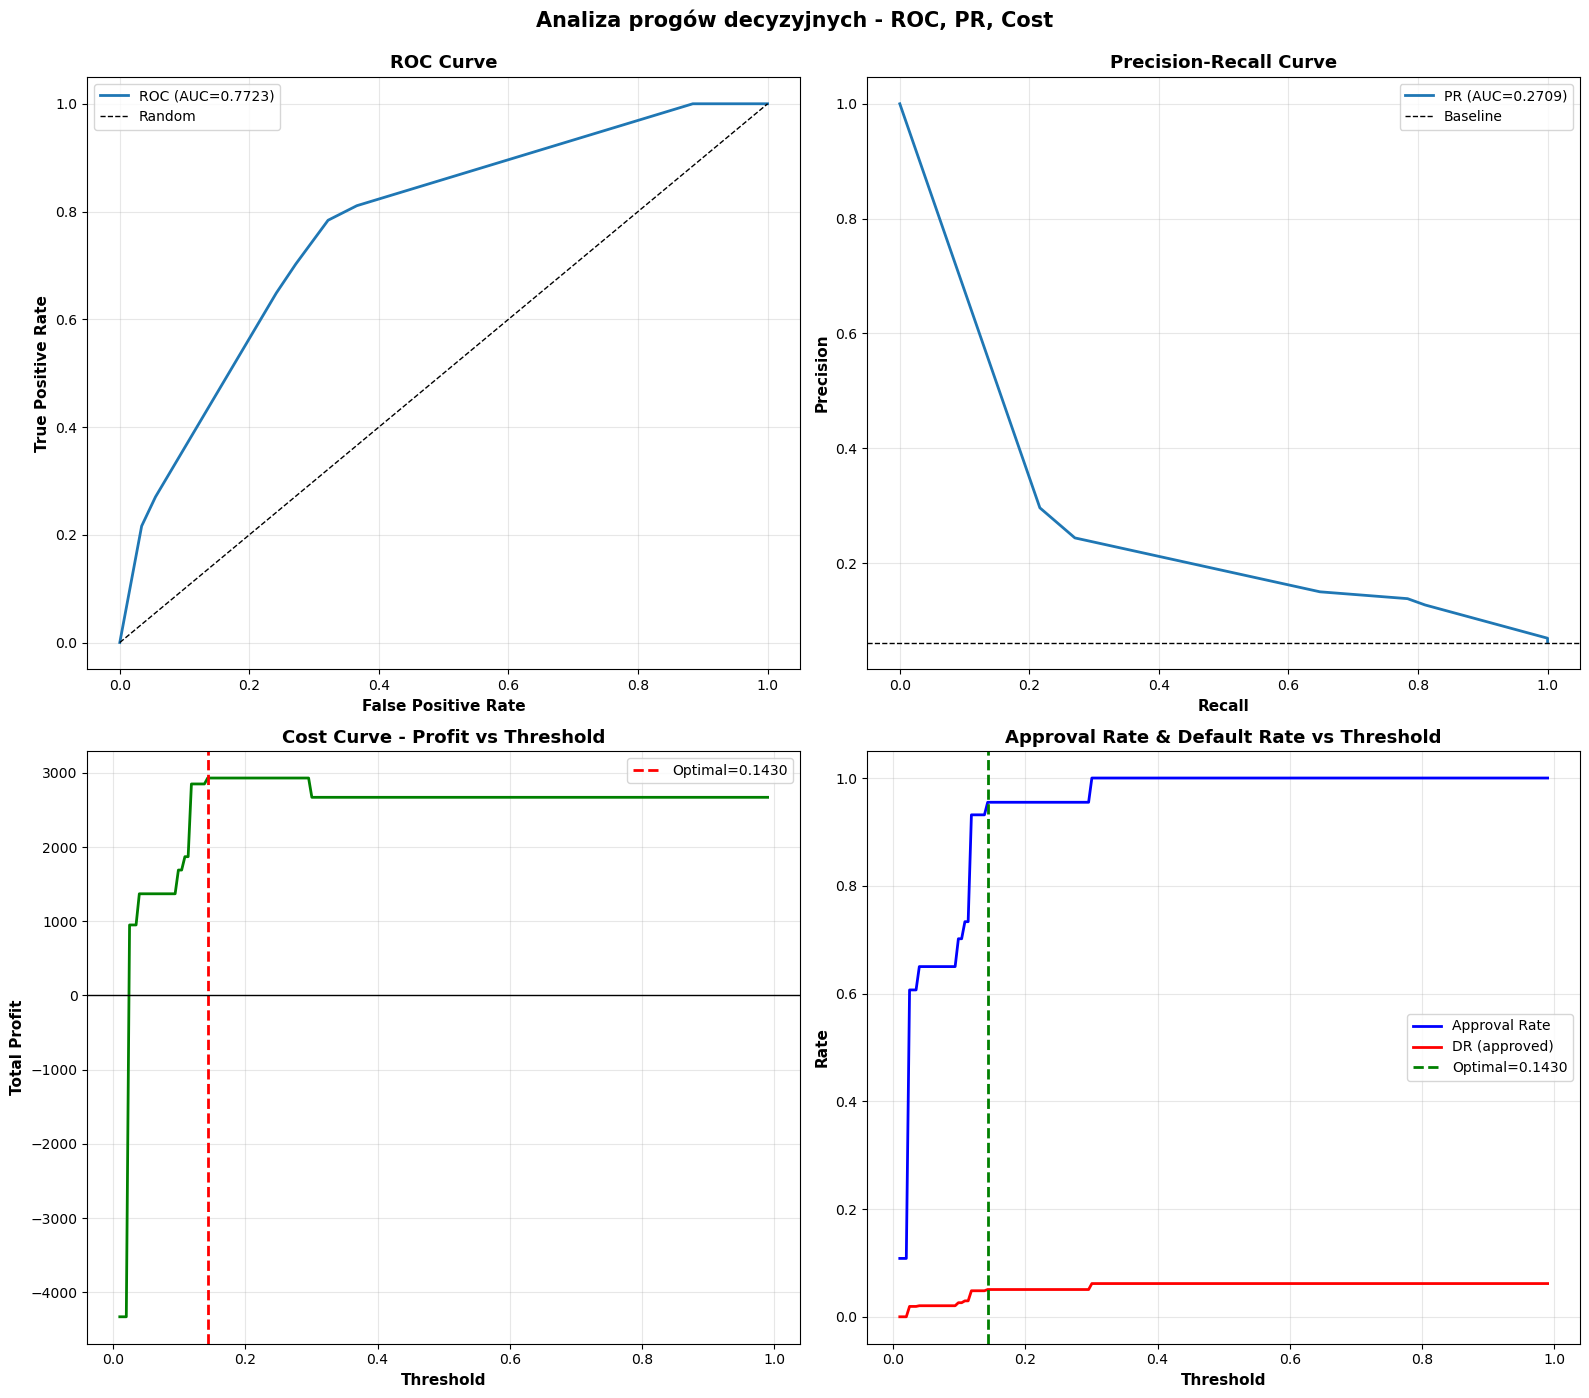

Wykresy zapisane: threshold_analysis_curves.png


In [90]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0, 0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

pr_auc = auc(recall, precision)
axes[0, 1].plot(recall, precision, linewidth=2, label=f'PR (AUC={pr_auc:.4f})')
axes[0, 1].axhline(y=y_true.mean(), color='k', linestyle='--', linewidth=1, label='Baseline')
axes[0, 1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(test_thresholds, profits, linewidth=2, color='green')
axes[1, 0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal={optimal_threshold:.4f}')
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Threshold', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Total Profit', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Cost Curve - Profit vs Threshold', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

approval_rates = []
default_rates_approved = []
for thresh in test_thresholds:
    approved = y_pred_cal < thresh
    approval_rate = approved.mean()
    if approval_rate > 0:
        dr_approved = y_true[approved].mean()
    else:
        dr_approved = 0
    approval_rates.append(approval_rate)
    default_rates_approved.append(dr_approved)

axes[1, 1].plot(test_thresholds, approval_rates, linewidth=2, label='Approval Rate', color='blue')
axes[1, 1].plot(test_thresholds, default_rates_approved, linewidth=2, label='DR (approved)', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
                   label=f'Optimal={optimal_threshold:.4f}')
axes[1, 1].set_xlabel('Threshold', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Rate', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Approval Rate & Default Rate vs Threshold', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Analiza progów decyzyjnych - ROC, PR, Cost', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('threshold_analysis_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Wykresy zapisane: threshold_analysis_curves.png")
print("="*80)

## 5.2. Mapowanie PD na klasy ratingowe

In [82]:
print("="*80)
print("MAPOWANIE PRAWDOPODOBIEŃSTW NA KLASY RATINGOWE")
print("="*80)

n_rating_classes = 7
rating_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

print(f"Liczba klas ratingowych: {n_rating_classes}")
print(f"Etykiety: {rating_labels}")
print(f"\nWymagania:")
print(f"  Klasa A (najlepsza): Default Rate < 0.1%")
print(f"  Klasa G (najgorsza): Default Rate > 95%")
print(f"  Monotoniczność: DR rosnący między klasami")
print(f"  Minimalna liczba obserwacji w klasie: 1% populacji ({int(len(y_true)*0.01)} obs.)")
print("="*80)

MAPOWANIE PRAWDOPODOBIEŃSTW NA KLASY RATINGOWE
Liczba klas ratingowych: 7
Etykiety: ['A', 'B', 'C', 'D', 'E', 'F', 'G']

Wymagania:
  Klasa A (najlepsza): Default Rate < 0.1%
  Klasa G (najgorsza): Default Rate > 95%
  Monotoniczność: DR rosnący między klasami
  Minimalna liczba obserwacji w klasie: 1% populacji (6 obs.)


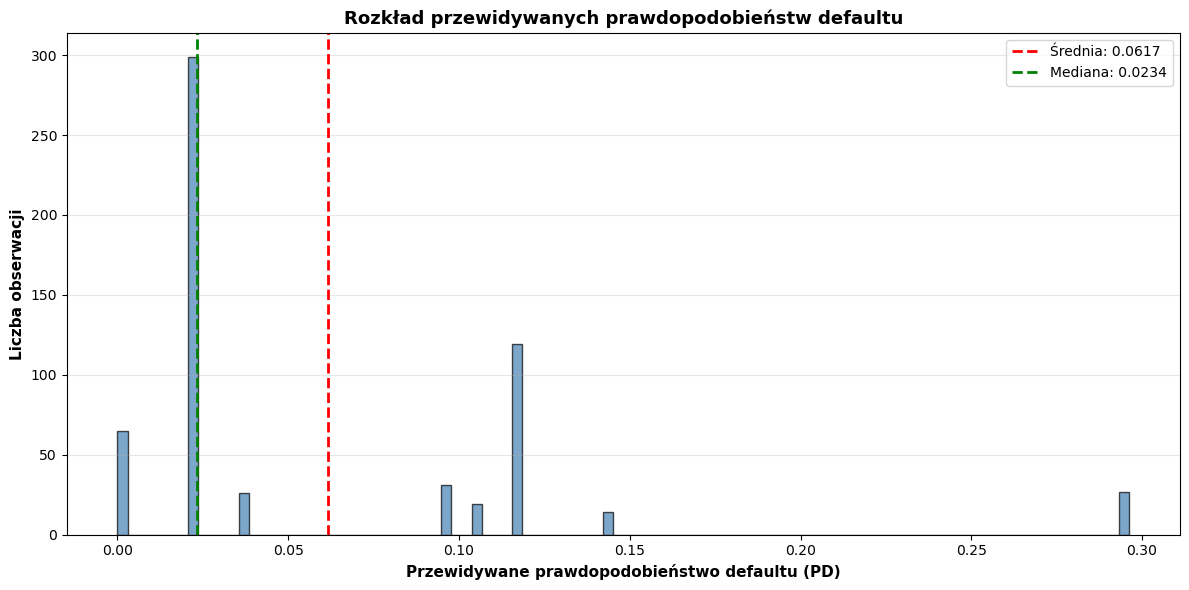


Statystyki rozkładu przewidywanych prawdopodobieństw:
  Liczba obserwacji: 600
  Średnia: 0.061667
  Mediana: 0.023411
  Odchylenie standardowe: 0.067388
  Min: 0.000000
  Max: 0.296296
  Q1 (25%): 0.023411
  Q3 (75%): 0.117647

Wykres zapisany: predicted_probabilities_histogram.png


In [87]:
# Wizualizacja rozkładu przewidywanych prawdopodobieństw
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Histogram ze skalą liniową
ax.hist(y_pred_cal, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Przewidywane prawdopodobieństwo defaultu (PD)', fontsize=11, fontweight='bold')
ax.set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
ax.set_title('Rozkład przewidywanych prawdopodobieństw defaultu', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.axvline(y_pred_cal.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {y_pred_cal.mean():.4f}')
ax.axvline(np.median(y_pred_cal), color='green', linestyle='--', linewidth=2, label=f'Mediana: {np.median(y_pred_cal):.4f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('predicted_probabilities_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStatystyki rozkładu przewidywanych prawdopodobieństw:")
print(f"  Liczba obserwacji: {len(y_pred_cal)}")
print(f"  Średnia: {y_pred_cal.mean():.6f}")
print(f"  Mediana: {np.median(y_pred_cal):.6f}")
print(f"  Odchylenie standardowe: {y_pred_cal.std():.6f}")
print(f"  Min: {y_pred_cal.min():.6f}")
print(f"  Max: {y_pred_cal.max():.6f}")
print(f"  Q1 (25%): {np.percentile(y_pred_cal, 25):.6f}")
print(f"  Q3 (75%): {np.percentile(y_pred_cal, 75):.6f}")
print(f"\nWykres zapisany: predicted_probabilities_histogram.png")
print("="*80)

In [83]:
def find_optimal_rating_boundaries(y_true, y_pred_proba, n_classes=7, 
                                   max_dr_best=0.001, min_dr_worst=0.95, 
                                   min_class_size=0.01):
    sorted_indices = np.argsort(y_pred_proba)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred_proba[sorted_indices]
    
    n_obs = len(y_true)
    min_obs_per_class = int(n_obs * min_class_size)
    
    boundaries = [0]
    
    # Klasa A: znajdź największą grupę gdzie DR < 0.1%
    idx = min_obs_per_class
    while idx < n_obs:
        class_dr = y_true_sorted[:idx].mean()
        if class_dr >= max_dr_best:
            idx = max(min_obs_per_class, idx - 1)
            break
        idx += 1
    boundaries.append(idx)
    
    # Podziel pozostałe obserwacje na równe klasy
    remaining_obs = n_obs - boundaries[-1]
    remaining_classes = n_classes - 1
    
    for i in range(1, remaining_classes):
        class_size = remaining_obs // remaining_classes
        next_boundary = boundaries[-1] + class_size
        boundaries.append(min(next_boundary, n_obs))
    
    boundaries.append(n_obs)
    
    # Konwersja na wartości PD
    pd_boundaries = [y_pred_sorted[min(idx, n_obs-1)] for idx in boundaries]
    
    return pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted

pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted = find_optimal_rating_boundaries(
    y_true, y_pred_cal, n_classes=n_rating_classes
)

def assign_rating_class(y_pred_proba, boundaries):
    ratings = np.zeros(len(y_pred_proba), dtype=int)
    for i, pd in enumerate(y_pred_proba):
        for class_idx in range(len(boundaries) - 1):
            if boundaries[class_idx] <= pd < boundaries[class_idx + 1]:
                ratings[i] = class_idx
                break
    return ratings

ratings = assign_rating_class(y_pred_cal, pd_boundaries)

print("Optymalne granice klas ratingowych (PD):")
for i in range(len(pd_boundaries) - 1):
    print(f"  Klasa {rating_labels[i]}: [{pd_boundaries[i]:.6f}, {pd_boundaries[i+1]:.6f})")
print("="*80)

Optymalne granice klas ratingowych (PD):
  Klasa A: [0.000000, 0.023411)
  Klasa B: [0.023411, 0.023411)
  Klasa C: [0.023411, 0.023411)
  Klasa D: [0.023411, 0.038462)
  Klasa E: [0.038462, 0.117647)
  Klasa F: [0.117647, 0.117647)
  Klasa G: [0.117647, 0.296296)


In [84]:
rating_analysis = []

for class_idx in range(n_rating_classes):
    mask = ratings == class_idx
    n_obs = mask.sum()
    pct_population = n_obs / len(y_true) * 100
    
    if n_obs > 0:
        avg_pd = y_pred_cal[mask].mean()
        median_pd = np.median(y_pred_cal[mask])
        std_pd = y_pred_cal[mask].std()
        actual_dr = y_true[mask].mean()
        n_defaults = y_true[mask].sum()
        
        rating_analysis.append({
            'Rating': rating_labels[class_idx],
            'PD_Min': pd_boundaries[class_idx],
            'PD_Max': pd_boundaries[class_idx + 1],
            'N_Obs': n_obs,
            'Pct_Pop': pct_population,
            'Avg_PD': avg_pd,
            'Median_PD': median_pd,
            'Std_PD': std_pd,
            'Actual_DR': actual_dr,
            'N_Defaults': int(n_defaults)
        })

rating_df = pd.DataFrame(rating_analysis)

print("Analiza klas ratingowych:")
print(rating_df.to_string(index=False))
print("\nWeryfikacja wymagań:")
print(f"  Klasa A DR: {rating_df.iloc[0]['Actual_DR']*100:.3f}% (< 0.1%)")
print(f"  Klasa G DR: {rating_df.iloc[-1]['Actual_DR']*100:.2f}% (> 95%)")
print(f"  Monotoniczność DR: {all(rating_df['Actual_DR'].diff()[1:] > 0)}")
print(f"  Min. obs. w klasie: {rating_df['N_Obs'].min()}")
print("="*80)

Analiza klas ratingowych:
Rating   PD_Min   PD_Max  N_Obs   Pct_Pop   Avg_PD  Median_PD       Std_PD  Actual_DR  N_Defaults
     A 0.000000 0.023411     92 15.333333 0.086957   0.000000 1.349202e-01   0.086957           8
     D 0.023411 0.038462    299 49.833333 0.023411   0.023411 1.862645e-09   0.023411           7
     E 0.038462 0.117647     76 12.666667 0.078947   0.096774 2.938542e-02   0.078947           6
     G 0.117647 0.296296    133 22.166667 0.120301   0.117647 7.736780e-03   0.120301          16

Weryfikacja wymagań:
  Klasa A DR: 8.696% (< 0.1%)
  Klasa G DR: 12.03% (> 95%)
  Monotoniczność DR: False
  Min. obs. w klasie: 76


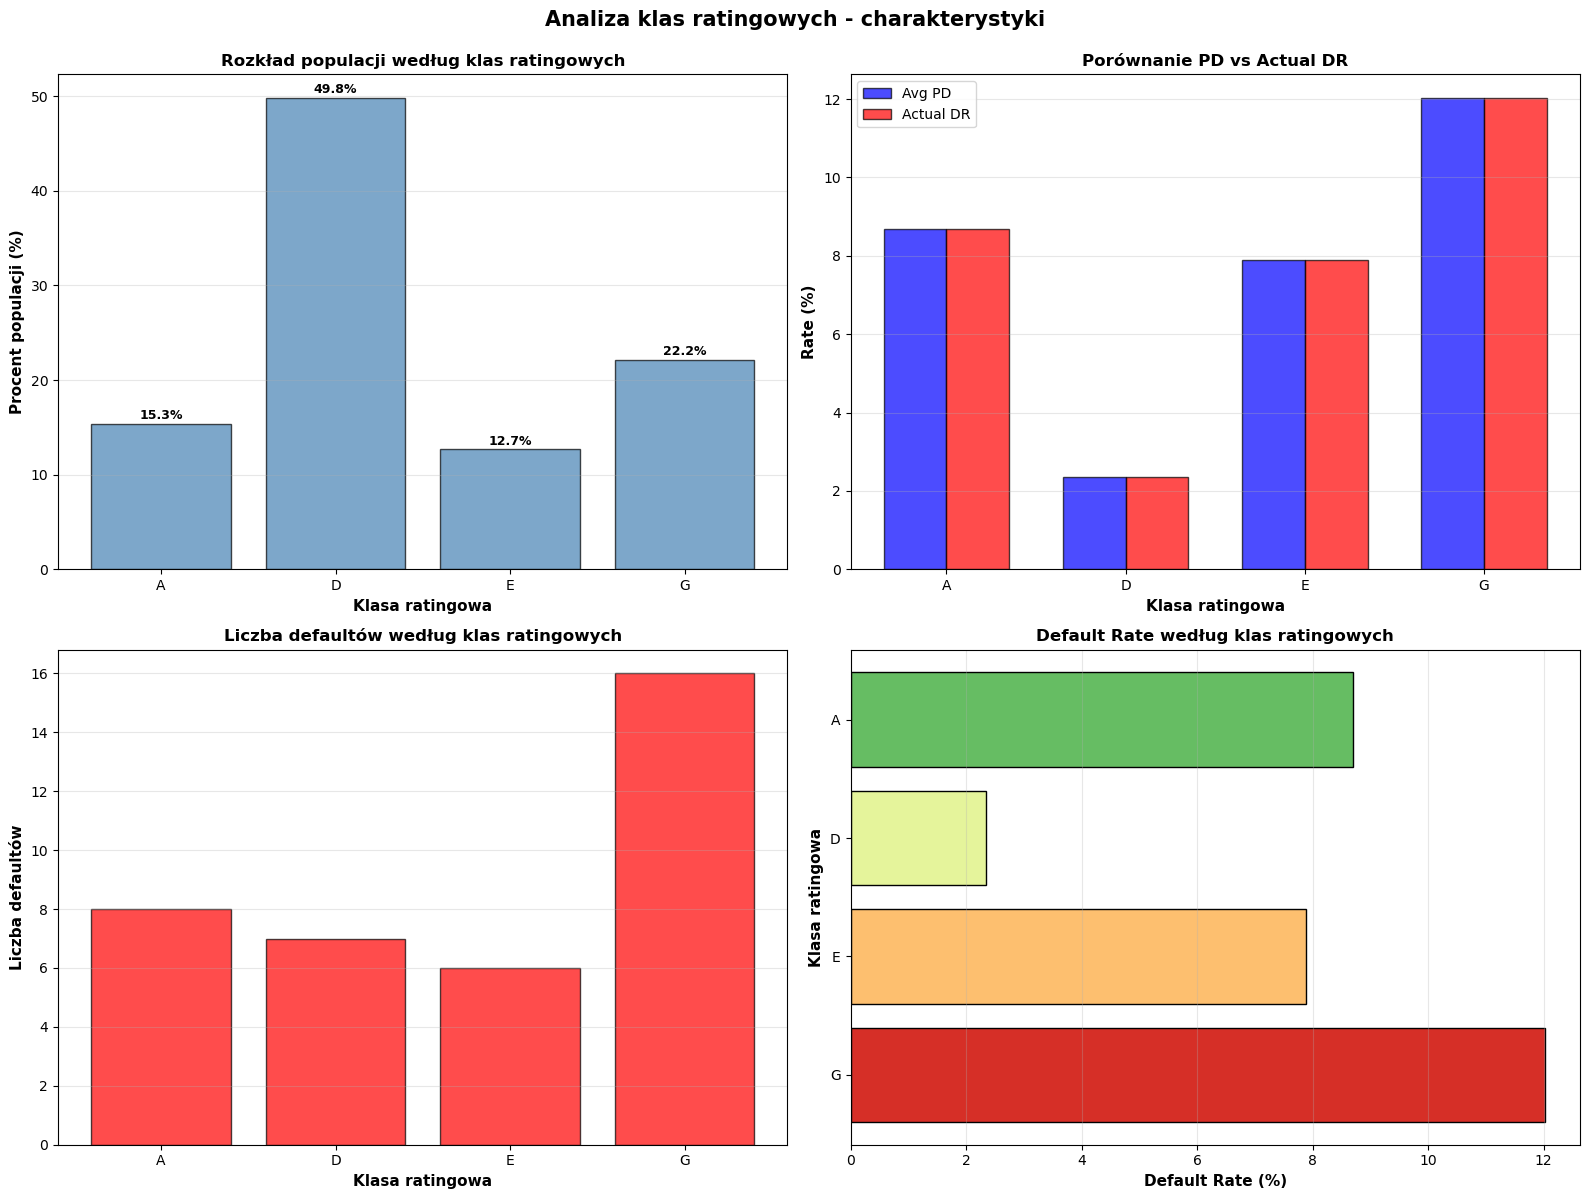

Wykres zapisany: rating_classes_analysis.png


In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(rating_df['Rating'], rating_df['Pct_Pop'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Procent populacji (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Rozkład populacji według klas ratingowych', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')
for i, (rating, pct) in enumerate(zip(rating_df['Rating'], rating_df['Pct_Pop'])):
    axes[0, 0].text(i, pct + 0.5, f'{pct:.1f}%', ha='center', fontsize=9, fontweight='bold')

x_pos = np.arange(len(rating_df))
width = 0.35
axes[0, 1].bar(x_pos - width/2, rating_df['Avg_PD']*100, width, label='Avg PD', 
               color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].bar(x_pos + width/2, rating_df['Actual_DR']*100, width, label='Actual DR', 
               color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Porównanie PD vs Actual DR', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(rating_df['Rating'])
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

axes[1, 0].bar(rating_df['Rating'], rating_df['N_Defaults'], color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Liczba defaultów', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Liczba defaultów według klas ratingowych', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

colors_map = plt.cm.RdYlGn_r(np.linspace(0.2, 0.9, len(rating_df)))
axes[1, 1].barh(rating_df['Rating'], rating_df['Actual_DR']*100, color=colors_map, edgecolor='black')
axes[1, 1].set_xlabel('Default Rate (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Default Rate według klas ratingowych', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.suptitle('Analiza klas ratingowych - charakterystyki', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Wykres zapisany: rating_classes_analysis.png")
print("="*80)

## 5.3. Tabele decyzyjne i wpływ progu na wyniki biznesowe

In [91]:
print("="*80)
print("ANALIZA WPŁYWU PROGU DECYZYJNEGO NA WYNIKI BIZNESOWE")
print("="*80)

strategy_thresholds = {
    'Konserwatywna (niski ryzyko)': 0.02,
    'Umiarkowana': 0.05,
    'Optymalna (max profit)': optimal_threshold,
    'Agresywna (wysoki wolumen)': 0.15,
    'Bardzo agresywna': 0.30
}

business_impact = []

for strategy_name, threshold in strategy_thresholds.items():
    y_pred_binary = (y_pred_cal >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    approval_rate = (tn + fn) / total
    rejection_rate = (tp + fp) / total
    dr_approved = fn / (tn + fn) if (tn + fn) > 0 else 0
    dr_rejected = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    revenue_tn = tn * BENEFIT_TN
    revenue_tp = tp * BENEFIT_TP
    cost_fp = fp * COST_FP
    cost_fn = fn * COST_FN
    
    total_profit = revenue_tn - cost_fp + revenue_tp - cost_fn
    profit_per_app = total_profit / total
    
    expected_loss = fn * COST_FN
    expected_loss_rate = expected_loss / (approval_rate * total * LOAN_AMOUNT) if approval_rate > 0 else 0
    
    business_impact.append({
        'Strategy': strategy_name,
        'Threshold': threshold,
        'Approval_Rate': approval_rate * 100,
        'DR_Approved': dr_approved * 100,
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1_Score': f1 * 100,
        'Total_Profit': total_profit,
        'Profit_Per_App': profit_per_app,
        'Expected_Loss': expected_loss,
        'Loss_Rate': expected_loss_rate * 100,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

business_df = pd.DataFrame(business_impact)

print("Wpływ różnych strategii progowych na metryki biznesowe:")
print("\nTabela 1: Metryki operacyjne")
print(business_df[['Strategy', 'Threshold', 'Approval_Rate', 'DR_Approved', 'Accuracy']].to_string(index=False))

print("\n\nTabela 2: Metryki finansowe")
print(business_df[['Strategy', 'Threshold', 'Total_Profit', 'Profit_Per_App', 'Expected_Loss', 'Loss_Rate']].to_string(index=False))

print("\n\nTabela 3: Confusion Matrix")
print(business_df[['Strategy', 'TP', 'FP', 'TN', 'FN']].to_string(index=False))

print("="*80)

ANALIZA WPŁYWU PROGU DECYZYJNEGO NA WYNIKI BIZNESOWE
Wpływ różnych strategii progowych na metryki biznesowe:

Tabela 1: Metryki operacyjne
                    Strategy  Threshold  Approval_Rate  DR_Approved  Accuracy
Konserwatywna (niski ryzyko)   0.020000      10.833333     0.000000 17.000000
                 Umiarkowana   0.050000      65.000000     2.051282 68.500000
      Optymalna (max profit)   0.142965      95.500000     5.061082 92.000000
  Agresywna (wysoki wolumen)   0.150000      95.500000     5.061082 92.000000
            Bardzo agresywna   0.300000     100.000000     6.166667 93.833333


Tabela 2: Metryki finansowe
                    Strategy  Threshold  Total_Profit  Profit_Per_App  Expected_Loss  Loss_Rate
Konserwatywna (niski ryzyko)   0.020000       -4330.0       -7.216667            0.0   0.000000
                 Umiarkowana   0.050000        1370.0        2.283333          640.0   1.641026
      Optymalna (max profit)   0.142965        2930.0        4.883333      

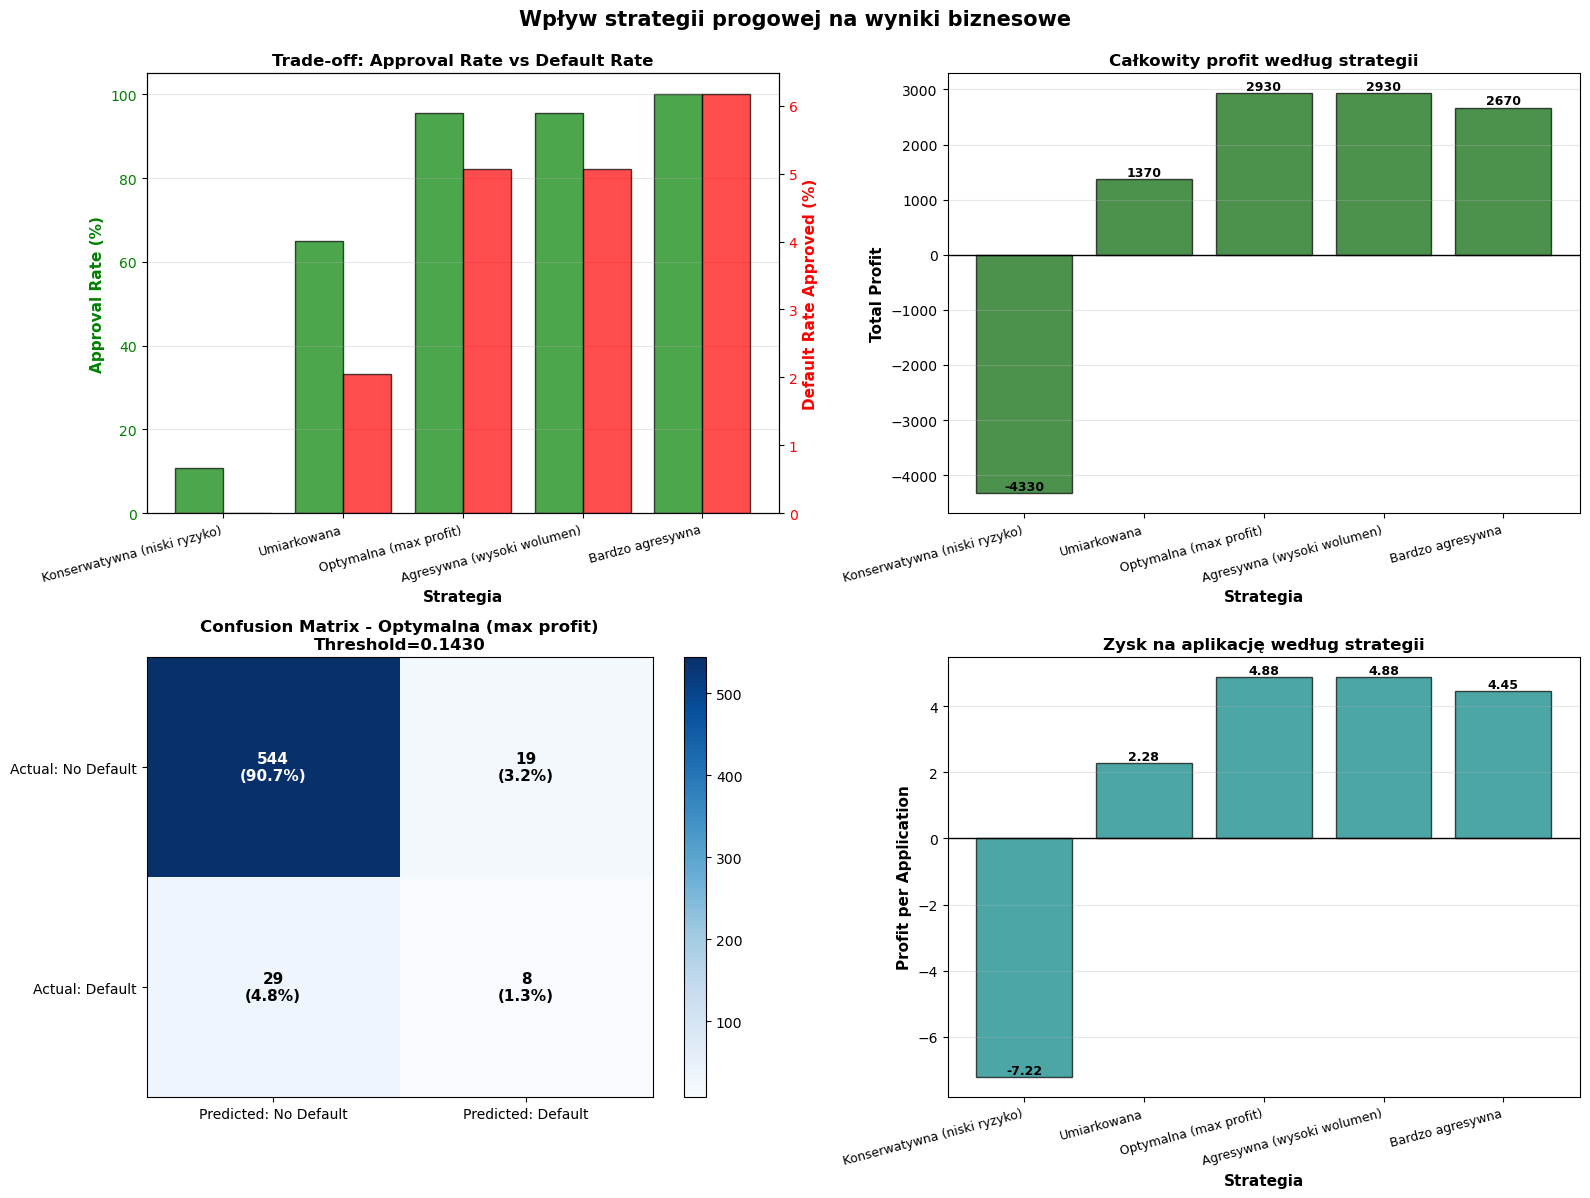

Wykres zapisany: business_impact_threshold_strategies.png


In [92]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

strategies = business_df['Strategy'].values
x_pos = np.arange(len(strategies))

ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
bars1 = ax1.bar(x_pos - 0.2, business_df['Approval_Rate'], 0.4, label='Approval Rate', 
                color='green', alpha=0.7, edgecolor='black')
bars2 = ax1_twin.bar(x_pos + 0.2, business_df['DR_Approved'], 0.4, label='DR Approved', 
                     color='red', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Strategia', fontsize=11, fontweight='bold')
ax1.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold', color='green')
ax1_twin.set_ylabel('Default Rate Approved (%)', fontsize=11, fontweight='bold', color='red')
ax1.set_title('Trade-off: Approval Rate vs Default Rate', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
ax1.tick_params(axis='y', labelcolor='green')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1.grid(alpha=0.3, axis='y')

axes[0, 1].bar(x_pos, business_df['Total_Profit'], color='darkgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Strategia', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Total Profit', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Całkowity profit według strategii', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
axes[0, 1].grid(alpha=0.3, axis='y')
for i, profit in enumerate(business_df['Total_Profit']):
    axes[0, 1].text(i, profit + max(business_df['Total_Profit'])*0.02, f'{profit:.0f}', 
                    ha='center', fontsize=9, fontweight='bold')

optimal_strategy_idx = business_df['Total_Profit'].idxmax()
optimal_cm = business_df.iloc[optimal_strategy_idx]
cm_matrix = np.array([[optimal_cm['TN'], optimal_cm['FP']], 
                      [optimal_cm['FN'], optimal_cm['TP']]])
im = axes[1, 0].imshow(cm_matrix, cmap='Blues', aspect='auto')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Predicted: No Default', 'Predicted: Default'], fontsize=10)
axes[1, 0].set_yticklabels(['Actual: No Default', 'Actual: Default'], fontsize=10)
axes[1, 0].set_title(f"Confusion Matrix - {optimal_cm['Strategy']}\nThreshold={optimal_cm['Threshold']:.4f}", 
                     fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        text = axes[1, 0].text(j, i, f'{int(cm_matrix[i, j])}\n({cm_matrix[i, j]/cm_matrix.sum()*100:.1f}%)',
                              ha="center", va="center", color="white" if cm_matrix[i, j] > cm_matrix.max()/2 else "black",
                              fontsize=11, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

axes[1, 1].bar(x_pos, business_df['Profit_Per_App'], color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Strategia', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Profit per Application', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Zysk na aplikację według strategii', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, profit in enumerate(business_df['Profit_Per_App']):
    axes[1, 1].text(i, profit + max(business_df['Profit_Per_App'])*0.02, f'{profit:.2f}', 
                    ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Wpływ strategii progowej na wyniki biznesowe', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('business_impact_threshold_strategies.png', dpi=300, bbox_inches='tight')
plt.show()

print("Wykres zapisany: business_impact_threshold_strategies.png")
print("="*80)

In [93]:
print("="*80)
print("TABELA DECYZYJNA - REKOMENDACJE AKCJI")
print("="*80)

decision_table = []

for _, row in rating_df.iterrows():
    rating = row['Rating']
    avg_pd = row['Avg_PD']
    actual_dr = row['Actual_DR']
    
    if rating in ['A', 'B']:
        action = 'AUTO-ACCEPT'
        terms = 'Standard terms'
        monitoring = 'Standard'
    elif rating in ['C', 'D']:
        action = 'ACCEPT'
        terms = 'Standard terms, możliwe wyższe oprocentowanie'
        monitoring = 'Enhanced'
    elif rating == 'E':
        action = 'MANUAL REVIEW'
        terms = 'Higher interest rate lub collateral'
        monitoring = 'Enhanced'
    elif rating == 'F':
        action = 'REJECT lub MANUAL'
        terms = 'Very high interest + collateral required'
        monitoring = 'Intensive'
    else:
        action = 'AUTO-REJECT'
        terms = 'N/A'
        monitoring = 'N/A'
    
    decision_table.append({
        'Rating': rating,
        'Avg_PD': f'{avg_pd*100:.2f}%',
        'Actual_DR': f'{actual_dr*100:.2f}%',
        'Action': action,
        'Terms': terms,
        'Monitoring': monitoring
    })

decision_df = pd.DataFrame(decision_table)
print(decision_df.to_string(index=False))

print("\n\nLegenda:")
print("  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualnego")
print("  ACCEPT: Akceptacja z możliwością dodatkowych warunków")
print("  MANUAL REVIEW: Wymagany przegląd manualny przez analityka")
print("  REJECT: Odrzucenie z możliwością manual review w wyjątkowych przypadkach")
print("  AUTO-REJECT: Automatyczne odrzucenie")
print("="*80)

TABELA DECYZYJNA - REKOMENDACJE AKCJI
Rating Avg_PD Actual_DR        Action                                         Terms Monitoring
     A  8.70%     8.70%   AUTO-ACCEPT                                Standard terms   Standard
     D  2.34%     2.34%        ACCEPT Standard terms, możliwe wyższe oprocentowanie   Enhanced
     E  7.89%     7.89% MANUAL REVIEW           Higher interest rate lub collateral   Enhanced
     G 12.03%    12.03%   AUTO-REJECT                                           N/A        N/A


Legenda:
  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualnego
  ACCEPT: Akceptacja z możliwością dodatkowych warunków
  MANUAL REVIEW: Wymagany przegląd manualny przez analityka
  REJECT: Odrzucenie z możliwością manual review w wyjątkowych przypadkach
  AUTO-REJECT: Automatyczne odrzucenie


In [94]:
print("="*80)
print("PODSUMOWANIE - PROGI DECYZJI I RATINGI")
print("="*80)

print(f"\nOptymalizacja progów:")
print(f"  Prog maksymalizujący profit: {optimal_threshold:.4f}")
print(f"  Maksymalny profit: {optimal_profit:.2f}")
print(f"  ROC AUC: {roc_auc:.4f}")
print(f"  PR AUC: {pr_auc:.4f}")

print(f"\nKlasy ratingowe:")
print(f"  Liczba klas: {n_rating_classes}")
print(f"  Zakres PD: [{pd_boundaries[0]:.6f}, {pd_boundaries[-1]:.6f}]")
print(f"  Klasa najlepsza (A): DR = {rating_df.iloc[0]['Actual_DR']*100:.3f}%")
print(f"  Klasa najgorsza (G): DR = {rating_df.iloc[-1]['Actual_DR']*100:.2f}%")
print(f"  Monotoniczność: {'Zachowana' if all(rating_df['Actual_DR'].diff()[1:] > 0) else 'Naruszona'}")

print(f"\nRekomendowana strategia biznesowa:")
best_strategy = business_df.iloc[business_df['Total_Profit'].idxmax()]
print(f"  Strategia: {best_strategy['Strategy']}")
print(f"  Prog: {best_strategy['Threshold']:.4f}")
print(f"  Approval Rate: {best_strategy['Approval_Rate']:.2f}%")
print(f"  DR wśród zaakceptowanych: {best_strategy['DR_Approved']:.2f}%")
print(f"  Profit per aplikacja: {best_strategy['Profit_Per_App']:.2f}")
print(f"  Total Profit: {best_strategy['Total_Profit']:.2f}")

print("\nZapisane pliki:")
print("  threshold_analysis_curves.png")
print("  rating_classes_analysis.png")
print("  business_impact_threshold_strategies.png")
print("="*80)

PODSUMOWANIE - PROGI DECYZJI I RATINGI

Optymalizacja progów:
  Prog maksymalizujący profit: 0.1430
  Maksymalny profit: 2930.00
  ROC AUC: 0.7723
  PR AUC: 0.2709

Klasy ratingowe:
  Liczba klas: 7
  Zakres PD: [0.000000, 0.296296]
  Klasa najlepsza (A): DR = 8.696%
  Klasa najgorsza (G): DR = 12.03%
  Monotoniczność: Naruszona

Rekomendowana strategia biznesowa:
  Strategia: Optymalna (max profit)
  Prog: 0.1430
  Approval Rate: 95.50%
  DR wśród zaakceptowanych: 5.06%
  Profit per aplikacja: 4.88
  Total Profit: 2930.00

Zapisane pliki:
  threshold_analysis_curves.png
  rating_classes_analysis.png
  business_impact_threshold_strategies.png
